In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm
#import pytorch3d

/home/xingchenliu/anaconda3/envs/vae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset:

In [2]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [3]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [4]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

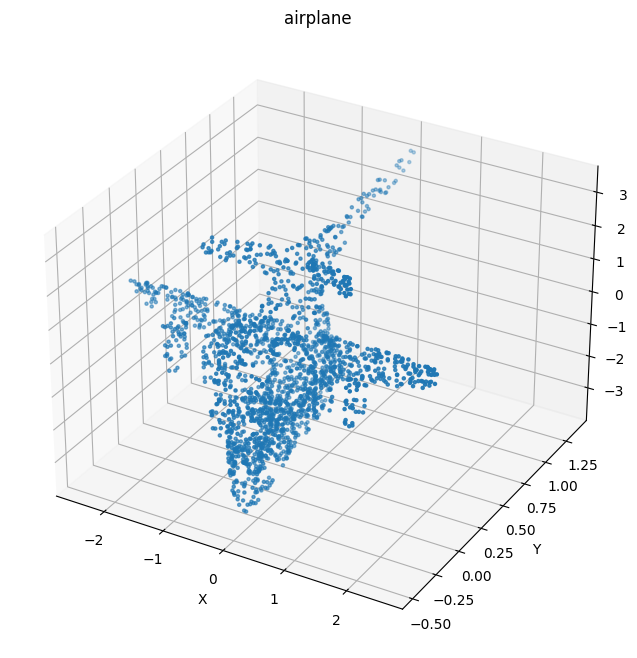

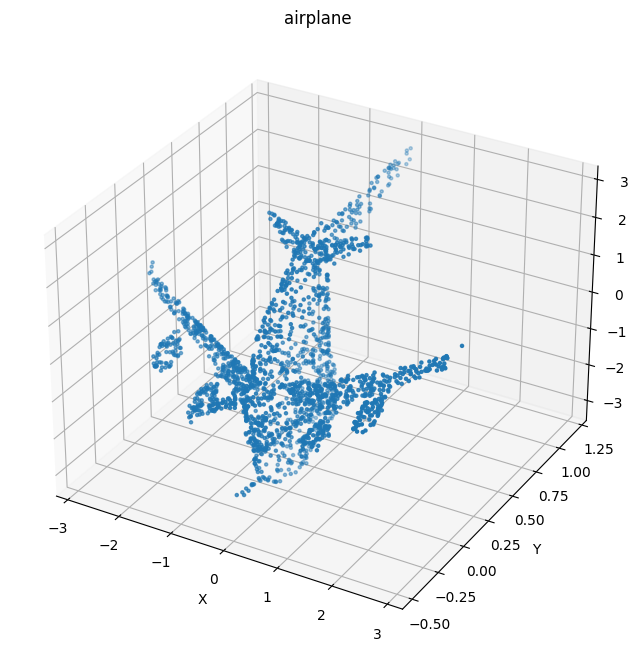

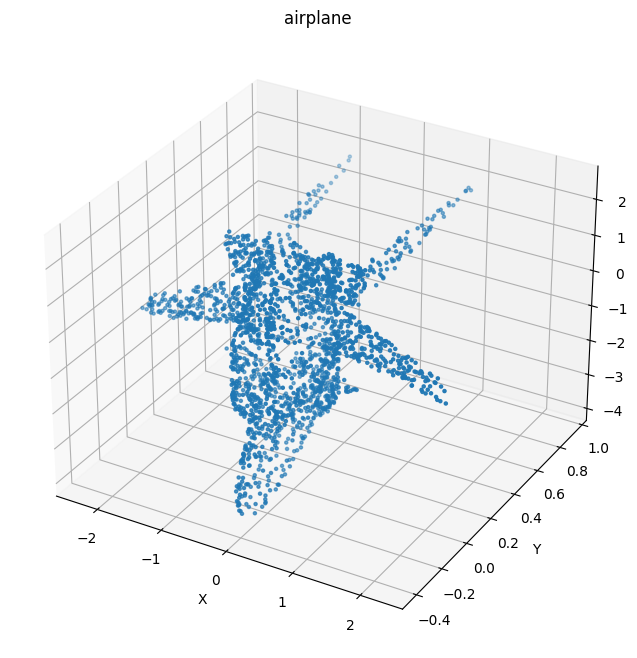

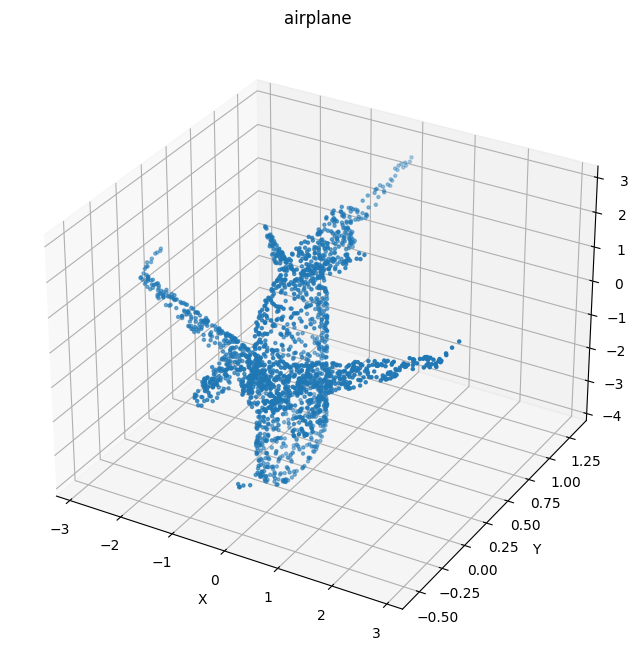

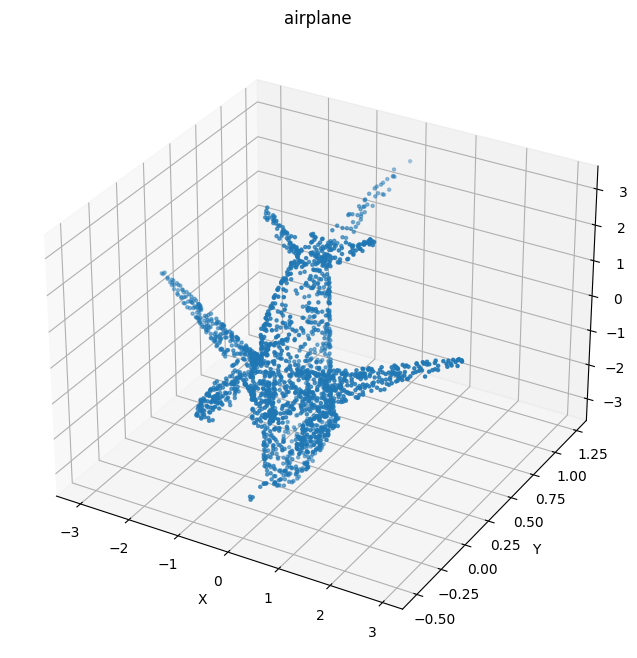

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [6]:
class TransformNet(nn.Module):
    def __init__(self, k=3):
        super(TransformNet, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)  # k*k for transformation matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Initialize the weights/bias with Identity transformation
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.copy_(torch.eye(k).view(-1))

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.gelu(self.bn4(self.fc1(x)))
        x = F.gelu(self.bn5(self.fc2(x)))
        
        x = self.fc3(x)
        
        # Reshape to the transformation matrix
        x = x.view(batch_size, -1)
        iden = torch.eye(self.fc3.out_features // x.size(-1)).view(-1).to(x.device)
        x = x + iden
        x = x.view(batch_size, x.size(1) // int(x.size(1)**0.5), int(x.size(1)**0.5))
        
        return x

In [7]:
class VariationalPointNetEncoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(VariationalPointNetEncoder, self).__init__()
        
        # Input transform
        self.input_transform = TransformNet(k=3)
        
        # Shared MLP
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # Feature transform
        self.feature_transform = TransformNet(k=64)
        
        # Batch Norm layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.transpose(2, 1)
        
        # Apply input transform
        input_transform = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), input_transform).transpose(1, 2)

        
        # Shared MLP layers
        x = F.gelu(self.bn1(self.conv1(x)))
        
        # Apply feature transform
        feature_transform = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), feature_transform).transpose(1, 2)

        
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        # Transition layers
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        
        # Get mu and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        # Reparametrization trick
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        # KL divergence
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z


Decoder:

In [8]:
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointNetDecoder, self).__init__()
        
        self.num_points = num_points
        
        # More expressive layers
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, num_points * 3)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x.view(-1, self.num_points, 3)


In [9]:
def chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two point clouds.
    
    Args:
    - p1 (torch.Tensor): A tensor of shape (B, N, D) representing a batch of point clouds, each of which has N points of dimension D.
    - p2 (torch.Tensor): A tensor of the same shape as p1.
    
    Returns:
    - distance (torch.Tensor): A tensor of shape (B,) representing the Chamfer Distance for each pair of point clouds in the batch.
    """
    
    # Compute the pairwise squared distances between points
    # p1 has shape (B, N, D) and p2 has shape (B, M, D)
    # The resulting dists will have shape (B, N, M)
    dists = torch.sum(p1**2, dim=2).unsqueeze(2) + torch.sum(p2**2, dim=2).unsqueeze(1) - 2 * torch.matmul(p1, p2.permute(0, 2, 1))
    
    # For each point in p1, find the closest distance in p2
    min_dists_p1 = torch.min(dists, dim=2)[0]  # Shape (B, N)
    
    # For each point in p2, find the closest distance in p1
    min_dists_p2 = torch.min(dists, dim=1)[0]  # Shape (B, M)
    
    # Combine the two distances by taking the average
    distance = (torch.sum(min_dists_p1, dim=1) + torch.sum(min_dists_p2, dim=1)) / 2
    
    return distance

# Test with the given point clouds
p1 = torch.tensor([[[8.8977, 4.1709, 1.2839],
                    [8.5640, 7.7767, 9.4214]],
                   [[0.5431, 6.4495, 11.4914],
                    [3.2126, 8.0865, 3.1018]]], dtype=torch.float)
p2 = torch.tensor([[[6.9340, 6.1152, 3.4435],
                    [0.1032, 9.8181, 11.3350]],
                   [[11.4006, 2.2154, 7.9589],
                    [4.2586, 1.4133, 7.2606]]], dtype=torch.float)

print(chamfer_distance(p1, p2))  # Expected output: tensor([ 72.5838, 151.0809])


tensor([ 72.5838, 151.0809])


VAE

In [10]:
class PointCloudVAE(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointCloudVAE, self).__init__()
        
        # Using the VariationalPointNetEncoder
        self.encoder = VariationalPointNetEncoder(num_points=num_points, latent_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        # Encode input point cloud and get latent variable z
        z = self.encoder(x)
        
        # Decode z to get the reconstructed point cloud
        reconstructed = self.decoder(z)
        
        return reconstructed, self.encoder.kl

# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=0.0):
    # Reconstruction loss
    recon_loss = chamfer_distance(reconstructed, original).mean()
    
    # Return combined loss
    return recon_loss + beta * kl_div

# Usage remains largely the same:

# Create a VAE
vae = PointCloudVAE(num_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)


Train

In [11]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_kl_div, total_recon_loss = 0, 0, 0
        
        # Training
        for i, batch in enumerate(tqdm(train_loader)):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
            combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
            
            combined_loss.backward()
            optimizer.step()
            
            total_train_loss += combined_loss.item()
            total_kl_div += kl_div.item()
            total_recon_loss += recon_loss.item()
            
            # Print batch-level losses
            print(f"Epoch {epoch+1}, Batch {i+1} - Combined Loss: {combined_loss.item():.4f}, KL Div: {kl_div.item():.4f}, Recon Loss: {recon_loss.item():.4f}")
            
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_kl_div = total_kl_div / len(train_loader)
        avg_train_recon_loss = total_recon_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss, total_val_kl_div, total_val_recon_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                
                recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
                combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
                
                total_val_loss += combined_loss.item()
                total_val_kl_div += kl_div.item()
                total_val_recon_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_kl_div = total_val_kl_div / len(val_loader)
        avg_val_recon_loss = total_val_recon_loss / len(val_loader)
        
        # Print epoch-level average losses
        print(f"\nEpoch: {epoch+1} Summary:")
        print(f"Train Avg Combined Loss: {avg_train_loss:.4f}, Train Avg KL Div: {avg_train_kl_div:.4f}, Train Avg Recon Loss: {avg_train_recon_loss:.4f}")
        print(f"Val Avg Combined Loss: {avg_val_loss:.4f}, Val Avg KL Div: {avg_val_kl_div:.4f}, Val Avg Recon Loss: {avg_val_recon_loss:.4f}\n")



In [12]:
vae = PointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [13]:
train_vae(vae, train_loader, val_loader, optimizer)

  7%|▋         | 2/27 [00:00<00:05,  4.56it/s]

Epoch 1, Batch 1 - Combined Loss: 2435.0208, KL Div: 832.8795, Recon Loss: 2435.0208
Epoch 1, Batch 2 - Combined Loss: 1862.2439, KL Div: 18149.8711, Recon Loss: 1862.2439


 15%|█▍        | 4/27 [00:00<00:04,  5.52it/s]

Epoch 1, Batch 3 - Combined Loss: 1404.2532, KL Div: 386869.0938, Recon Loss: 1404.2532
Epoch 1, Batch 4 - Combined Loss: 824.9894, KL Div: 56222.3594, Recon Loss: 824.9894


 22%|██▏       | 6/27 [00:01<00:03,  5.87it/s]

Epoch 1, Batch 5 - Combined Loss: 716.7676, KL Div: 49548.1758, Recon Loss: 716.7676
Epoch 1, Batch 6 - Combined Loss: 269.0463, KL Div: 79516.3203, Recon Loss: 269.0463


 30%|██▉       | 8/27 [00:01<00:03,  6.03it/s]

Epoch 1, Batch 7 - Combined Loss: 349.5806, KL Div: 134990.6094, Recon Loss: 349.5806
Epoch 1, Batch 8 - Combined Loss: 395.5516, KL Div: 137412.8906, Recon Loss: 395.5516


 37%|███▋      | 10/27 [00:01<00:02,  6.10it/s]

Epoch 1, Batch 9 - Combined Loss: 176.8705, KL Div: 89563.0469, Recon Loss: 176.8705
Epoch 1, Batch 10 - Combined Loss: 137.3959, KL Div: 57682.5312, Recon Loss: 137.3959


 44%|████▍     | 12/27 [00:02<00:02,  6.14it/s]

Epoch 1, Batch 11 - Combined Loss: 179.5430, KL Div: 43316.5938, Recon Loss: 179.5430
Epoch 1, Batch 12 - Combined Loss: 176.2133, KL Div: 39253.8125, Recon Loss: 176.2133


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 1, Batch 13 - Combined Loss: 129.7847, KL Div: 39908.1797, Recon Loss: 129.7847
Epoch 1, Batch 14 - Combined Loss: 108.8482, KL Div: 42559.5469, Recon Loss: 108.8482


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 1, Batch 15 - Combined Loss: 117.1001, KL Div: 43802.1484, Recon Loss: 117.1001
Epoch 1, Batch 16 - Combined Loss: 132.6443, KL Div: 45442.3125, Recon Loss: 132.6443


 67%|██████▋   | 18/27 [00:03<00:01,  6.16it/s]

Epoch 1, Batch 17 - Combined Loss: 117.6834, KL Div: 43552.4219, Recon Loss: 117.6834
Epoch 1, Batch 18 - Combined Loss: 104.5175, KL Div: 40639.0469, Recon Loss: 104.5175


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 1, Batch 19 - Combined Loss: 92.6168, KL Div: 36033.1250, Recon Loss: 92.6168
Epoch 1, Batch 20 - Combined Loss: 84.9156, KL Div: 33354.0898, Recon Loss: 84.9156


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 1, Batch 21 - Combined Loss: 80.6018, KL Div: 29524.0508, Recon Loss: 80.6018
Epoch 1, Batch 22 - Combined Loss: 79.8564, KL Div: 26761.2070, Recon Loss: 79.8564


 89%|████████▉ | 24/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 23 - Combined Loss: 81.2427, KL Div: 25267.8008, Recon Loss: 81.2427
Epoch 1, Batch 24 - Combined Loss: 79.5963, KL Div: 23820.8867, Recon Loss: 79.5963


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 25 - Combined Loss: 82.5185, KL Div: 22403.9941, Recon Loss: 82.5185
Epoch 1, Batch 26 - Combined Loss: 75.4032, KL Div: 21325.9570, Recon Loss: 75.4032


100%|██████████| 27/27 [00:04<00:00,  6.00it/s]


Epoch 1, Batch 27 - Combined Loss: 77.4579, KL Div: 17957.4727, Recon Loss: 77.4579

Epoch: 1 Summary:
Train Avg Combined Loss: 384.1579, Train Avg KL Div: 58730.0157, Train Avg Recon Loss: 384.1579
Val Avg Combined Loss: 69.1288, Val Avg KL Div: 14693.2928, Val Avg Recon Loss: 69.1288



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 2, Batch 1 - Combined Loss: 70.3316, KL Div: 20059.3750, Recon Loss: 70.3316


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 2, Batch 2 - Combined Loss: 75.9799, KL Div: 19338.0527, Recon Loss: 75.9799


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 3 - Combined Loss: 65.4211, KL Div: 18792.7891, Recon Loss: 65.4211


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 4 - Combined Loss: 74.0166, KL Div: 18941.1445, Recon Loss: 74.0166


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 5 - Combined Loss: 68.7714, KL Div: 17908.0840, Recon Loss: 68.7714


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 6 - Combined Loss: 68.8109, KL Div: 17776.0742, Recon Loss: 68.8109


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 7 - Combined Loss: 68.4538, KL Div: 17163.4902, Recon Loss: 68.4538


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 8 - Combined Loss: 73.1217, KL Div: 16958.3047, Recon Loss: 73.1217


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 9 - Combined Loss: 74.0405, KL Div: 16552.4609, Recon Loss: 74.0405


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 10 - Combined Loss: 65.2533, KL Div: 16011.4004, Recon Loss: 65.2533


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 11 - Combined Loss: 63.7158, KL Div: 16381.7041, Recon Loss: 63.7158


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 2, Batch 12 - Combined Loss: 70.3066, KL Div: 16560.5195, Recon Loss: 70.3066


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 2, Batch 13 - Combined Loss: 68.6434, KL Div: 16680.0469, Recon Loss: 68.6434


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 2, Batch 14 - Combined Loss: 65.6183, KL Div: 16454.5234, Recon Loss: 65.6183


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 2, Batch 15 - Combined Loss: 67.7675, KL Div: 16243.0508, Recon Loss: 67.7675


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 2, Batch 16 - Combined Loss: 67.7737, KL Div: 16461.6855, Recon Loss: 67.7737


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 17 - Combined Loss: 61.9618, KL Div: 16506.0664, Recon Loss: 61.9618


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 18 - Combined Loss: 62.3041, KL Div: 16169.8340, Recon Loss: 62.3041


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 2, Batch 19 - Combined Loss: 67.9177, KL Div: 16633.9414, Recon Loss: 67.9177


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 2, Batch 20 - Combined Loss: 64.1963, KL Div: 16833.3359, Recon Loss: 64.1963


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 21 - Combined Loss: 62.2502, KL Div: 16612.7246, Recon Loss: 62.2502


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 22 - Combined Loss: 61.9638, KL Div: 16677.0293, Recon Loss: 61.9638


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 23 - Combined Loss: 64.2348, KL Div: 17128.5508, Recon Loss: 64.2348


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 24 - Combined Loss: 65.4412, KL Div: 17167.6992, Recon Loss: 65.4412


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 25 - Combined Loss: 68.6046, KL Div: 17076.3730, Recon Loss: 68.6046


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 26 - Combined Loss: 65.0283, KL Div: 16905.4062, Recon Loss: 65.0283


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 2, Batch 27 - Combined Loss: 69.8443, KL Div: 14955.2324, Recon Loss: 69.8443



Epoch: 2 Summary:
Train Avg Combined Loss: 67.4731, Train Avg KL Div: 17072.1815, Train Avg Recon Loss: 67.4731
Val Avg Combined Loss: 59.9590, Val Avg KL Div: 16000.4016, Val Avg Recon Loss: 59.9590



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 3, Batch 1 - Combined Loss: 60.0476, KL Div: 17534.3867, Recon Loss: 60.0476


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 3, Batch 2 - Combined Loss: 65.0199, KL Div: 17393.4648, Recon Loss: 65.0199


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 3 - Combined Loss: 55.4849, KL Div: 17513.2148, Recon Loss: 55.4849


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 4 - Combined Loss: 65.2230, KL Div: 18297.9688, Recon Loss: 65.2230


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 5 - Combined Loss: 61.7933, KL Div: 17900.6719, Recon Loss: 61.7933


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 6 - Combined Loss: 62.2389, KL Div: 18392.3164, Recon Loss: 62.2389


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 3, Batch 7 - Combined Loss: 62.2351, KL Div: 18607.0078, Recon Loss: 62.2351


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 3, Batch 8 - Combined Loss: 65.0369, KL Div: 18810.5938, Recon Loss: 65.0369


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 3, Batch 9 - Combined Loss: 67.5118, KL Div: 18893.4883, Recon Loss: 67.5118


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 3, Batch 10 - Combined Loss: 58.3690, KL Div: 18732.0938, Recon Loss: 58.3690


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 3, Batch 11 - Combined Loss: 58.0599, KL Div: 19286.8555, Recon Loss: 58.0599


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 3, Batch 12 - Combined Loss: 66.1322, KL Div: 19162.6641, Recon Loss: 66.1322


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 3, Batch 13 - Combined Loss: 64.2217, KL Div: 19672.1621, Recon Loss: 64.2217


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 3, Batch 14 - Combined Loss: 60.3845, KL Div: 19307.0176, Recon Loss: 60.3845


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 3, Batch 15 - Combined Loss: 62.9027, KL Div: 19547.7051, Recon Loss: 62.9027


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 3, Batch 16 - Combined Loss: 63.5646, KL Div: 19970.8633, Recon Loss: 63.5646


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 3, Batch 17 - Combined Loss: 58.3712, KL Div: 20343.2949, Recon Loss: 58.3712


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 3, Batch 18 - Combined Loss: 59.1462, KL Div: 19889.0156, Recon Loss: 59.1462


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 3, Batch 19 - Combined Loss: 64.4670, KL Div: 20863.0430, Recon Loss: 64.4670


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 3, Batch 20 - Combined Loss: 60.4292, KL Div: 21260.9727, Recon Loss: 60.4292


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 3, Batch 21 - Combined Loss: 58.6154, KL Div: 20950.4961, Recon Loss: 58.6154


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 3, Batch 22 - Combined Loss: 58.2365, KL Div: 21464.0879, Recon Loss: 58.2365


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 3, Batch 23 - Combined Loss: 60.6702, KL Div: 21985.4199, Recon Loss: 60.6702


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 3, Batch 24 - Combined Loss: 63.5748, KL Div: 22413.4688, Recon Loss: 63.5748


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 3, Batch 25 - Combined Loss: 64.3828, KL Div: 22315.1172, Recon Loss: 64.3828


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 3, Batch 26 - Combined Loss: 61.5544, KL Div: 22504.7500, Recon Loss: 61.5544


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 3, Batch 27 - Combined Loss: 67.0619, KL Div: 19943.0059, Recon Loss: 67.0619



Epoch: 3 Summary:
Train Avg Combined Loss: 62.0273, Train Avg KL Div: 19739.0795, Train Avg Recon Loss: 62.0273
Val Avg Combined Loss: 57.1208, Val Avg KL Div: 22652.1434, Val Avg Recon Loss: 57.1208



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 4, Batch 1 - Combined Loss: 57.4335, KL Div: 24045.0020, Recon Loss: 57.4335


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 4, Batch 2 - Combined Loss: 60.8671, KL Div: 23605.1289, Recon Loss: 60.8671


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 3 - Combined Loss: 53.0307, KL Div: 24156.0781, Recon Loss: 53.0307


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 4 - Combined Loss: 61.2439, KL Div: 25173.8125, Recon Loss: 61.2439


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 5 - Combined Loss: 57.2566, KL Div: 24440.3086, Recon Loss: 57.2566


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 6 - Combined Loss: 59.7057, KL Div: 25028.6836, Recon Loss: 59.7057


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 7 - Combined Loss: 59.1669, KL Div: 25178.3652, Recon Loss: 59.1669


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 8 - Combined Loss: 62.9423, KL Div: 25326.4922, Recon Loss: 62.9423


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 9 - Combined Loss: 64.9049, KL Div: 25781.8613, Recon Loss: 64.9049


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 10 - Combined Loss: 55.9472, KL Div: 25608.4414, Recon Loss: 55.9472


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 11 - Combined Loss: 55.8979, KL Div: 26805.6777, Recon Loss: 55.8979


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 12 - Combined Loss: 63.4661, KL Div: 26103.8906, Recon Loss: 63.4661


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 13 - Combined Loss: 61.2379, KL Div: 26938.8652, Recon Loss: 61.2379


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 14 - Combined Loss: 58.1226, KL Div: 25715.2109, Recon Loss: 58.1226


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 15 - Combined Loss: 60.5568, KL Div: 26154.8066, Recon Loss: 60.5568


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 16 - Combined Loss: 58.9900, KL Div: 27221.1035, Recon Loss: 58.9900


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 17 - Combined Loss: 55.7784, KL Div: 27459.1172, Recon Loss: 55.7784


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 18 - Combined Loss: 55.8622, KL Div: 26736.4082, Recon Loss: 55.8622


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 4, Batch 19 - Combined Loss: 60.7175, KL Div: 27930.1074, Recon Loss: 60.7175


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 4, Batch 20 - Combined Loss: 57.4388, KL Div: 28641.1211, Recon Loss: 57.4388


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 21 - Combined Loss: 55.4146, KL Div: 28367.8320, Recon Loss: 55.4146


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 22 - Combined Loss: 55.4664, KL Div: 28651.3848, Recon Loss: 55.4664


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 23 - Combined Loss: 57.4863, KL Div: 28743.7285, Recon Loss: 57.4863


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 24 - Combined Loss: 60.1020, KL Div: 29787.0430, Recon Loss: 60.1020


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 4, Batch 25 - Combined Loss: 61.9899, KL Div: 29396.2441, Recon Loss: 61.9899


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 4, Batch 26 - Combined Loss: 58.2148, KL Div: 29456.1719, Recon Loss: 58.2148


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 4, Batch 27 - Combined Loss: 60.6556, KL Div: 25852.1914, Recon Loss: 60.6556



Epoch: 4 Summary:
Train Avg Combined Loss: 58.8851, Train Avg KL Div: 26603.8918, Train Avg Recon Loss: 58.8851
Val Avg Combined Loss: 54.5471, Val Avg KL Div: 26463.6301, Val Avg Recon Loss: 54.5471



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 5, Batch 1 - Combined Loss: 54.1938, KL Div: 30985.4570, Recon Loss: 54.1938


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 5, Batch 2 - Combined Loss: 58.3292, KL Div: 30000.4727, Recon Loss: 58.3292


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 3 - Combined Loss: 51.1688, KL Div: 30623.8340, Recon Loss: 51.1688


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 4 - Combined Loss: 57.9901, KL Div: 31971.9004, Recon Loss: 57.9901


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 5, Batch 5 - Combined Loss: 54.5065, KL Div: 30933.9980, Recon Loss: 54.5065


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 5, Batch 6 - Combined Loss: 57.1292, KL Div: 32896.2734, Recon Loss: 57.1292


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 5, Batch 7 - Combined Loss: 57.1421, KL Div: 32632.4883, Recon Loss: 57.1421


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 5, Batch 8 - Combined Loss: 59.4197, KL Div: 33870.5625, Recon Loss: 59.4197


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 9 - Combined Loss: 61.7807, KL Div: 33469.5898, Recon Loss: 61.7807


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 10 - Combined Loss: 51.9172, KL Div: 33285.1875, Recon Loss: 51.9172


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 5, Batch 11 - Combined Loss: 54.0043, KL Div: 35139.0195, Recon Loss: 54.0043


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 12 - Combined Loss: 61.3196, KL Div: 34703.9297, Recon Loss: 61.3196


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 5, Batch 13 - Combined Loss: 57.4645, KL Div: 35379.7344, Recon Loss: 57.4645


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 5, Batch 14 - Combined Loss: 54.9888, KL Div: 34538.7500, Recon Loss: 54.9888


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 15 - Combined Loss: 57.4773, KL Div: 35587.7344, Recon Loss: 57.4773


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 16 - Combined Loss: 57.0677, KL Div: 36941.9414, Recon Loss: 57.0677


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 17 - Combined Loss: 53.2630, KL Div: 37065.6211, Recon Loss: 53.2630


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 5, Batch 18 - Combined Loss: 53.7561, KL Div: 35854.1641, Recon Loss: 53.7561


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 5, Batch 19 - Combined Loss: 57.9925, KL Div: 37426.3281, Recon Loss: 57.9925


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 5, Batch 20 - Combined Loss: 55.6621, KL Div: 38163.4297, Recon Loss: 55.6621


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 21 - Combined Loss: 53.0114, KL Div: 38626.0352, Recon Loss: 53.0114


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 22 - Combined Loss: 53.4739, KL Div: 38444.6602, Recon Loss: 53.4739


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 23 - Combined Loss: 55.1750, KL Div: 38574.1562, Recon Loss: 55.1750


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 5, Batch 24 - Combined Loss: 57.8987, KL Div: 40736.5039, Recon Loss: 57.8987


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 5, Batch 25 - Combined Loss: 58.8529, KL Div: 39563.0938, Recon Loss: 58.8529


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 5, Batch 26 - Combined Loss: 56.6310, KL Div: 40290.1055, Recon Loss: 56.6310


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 5, Batch 27 - Combined Loss: 58.8558, KL Div: 34515.0547, Recon Loss: 58.8558



Epoch: 5 Summary:
Train Avg Combined Loss: 56.3138, Train Avg KL Div: 35267.4083, Train Avg Recon Loss: 56.3138
Val Avg Combined Loss: 52.1254, Val Avg KL Div: 37784.8148, Val Avg Recon Loss: 52.1254



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 6, Batch 1 - Combined Loss: 52.0998, KL Div: 41456.4219, Recon Loss: 52.0998


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 6, Batch 2 - Combined Loss: 56.0453, KL Div: 40297.7891, Recon Loss: 56.0453


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 6, Batch 3 - Combined Loss: 50.2459, KL Div: 41417.1406, Recon Loss: 50.2459


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 6, Batch 4 - Combined Loss: 55.5555, KL Div: 42158.4297, Recon Loss: 55.5555


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 5 - Combined Loss: 52.7025, KL Div: 40963.6523, Recon Loss: 52.7025


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 6 - Combined Loss: 54.7107, KL Div: 42717.7227, Recon Loss: 54.7107


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 6, Batch 7 - Combined Loss: 53.6200, KL Div: 41365.3672, Recon Loss: 53.6200


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 6, Batch 8 - Combined Loss: 57.1206, KL Div: 43492.6094, Recon Loss: 57.1206


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 6, Batch 9 - Combined Loss: 59.3620, KL Div: 43483.0430, Recon Loss: 59.3620


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 10 - Combined Loss: 49.7854, KL Div: 42780.0938, Recon Loss: 49.7854


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 11 - Combined Loss: 50.8789, KL Div: 44422.5820, Recon Loss: 50.8789


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 12 - Combined Loss: 58.5392, KL Div: 45036.5234, Recon Loss: 58.5392


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 6, Batch 13 - Combined Loss: 55.9164, KL Div: 44539.8320, Recon Loss: 55.9164


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 6, Batch 14 - Combined Loss: 52.5060, KL Div: 43799.8281, Recon Loss: 52.5060


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 6, Batch 15 - Combined Loss: 55.4419, KL Div: 45038.7852, Recon Loss: 55.4419


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 16 - Combined Loss: 54.3364, KL Div: 45505.8828, Recon Loss: 54.3364


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 6, Batch 17 - Combined Loss: 50.6312, KL Div: 44370.7969, Recon Loss: 50.6312


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 18 - Combined Loss: 51.2967, KL Div: 43560.9141, Recon Loss: 51.2967


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 6, Batch 19 - Combined Loss: 54.7016, KL Div: 45061.7812, Recon Loss: 54.7016


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 6, Batch 20 - Combined Loss: 52.0723, KL Div: 45477.3594, Recon Loss: 52.0723


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 21 - Combined Loss: 49.4340, KL Div: 46083.1797, Recon Loss: 49.4340


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 22 - Combined Loss: 50.9657, KL Div: 45267.0859, Recon Loss: 50.9657


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 23 - Combined Loss: 52.1148, KL Div: 44777.2969, Recon Loss: 52.1148


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 6, Batch 24 - Combined Loss: 55.3123, KL Div: 47611.8789, Recon Loss: 55.3123


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 6, Batch 25 - Combined Loss: 56.6693, KL Div: 45800.3711, Recon Loss: 56.6693


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 6, Batch 26 - Combined Loss: 53.2190, KL Div: 47235.1641, Recon Loss: 53.2190


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 6, Batch 27 - Combined Loss: 55.7367, KL Div: 40830.9922, Recon Loss: 55.7367



Epoch: 6 Summary:
Train Avg Combined Loss: 53.7415, Train Avg KL Div: 43872.3157, Train Avg Recon Loss: 53.7415
Val Avg Combined Loss: 49.9768, Val Avg KL Div: 42190.5141, Val Avg Recon Loss: 49.9768



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 7, Batch 1 - Combined Loss: 49.7569, KL Div: 48572.7422, Recon Loss: 49.7569


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 7, Batch 2 - Combined Loss: 53.5081, KL Div: 47080.4453, Recon Loss: 53.5081


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 3 - Combined Loss: 47.8175, KL Div: 48160.4023, Recon Loss: 47.8175


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 4 - Combined Loss: 52.8883, KL Div: 48037.0469, Recon Loss: 52.8883


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 5 - Combined Loss: 50.9012, KL Div: 47506.7031, Recon Loss: 50.9012


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 6 - Combined Loss: 52.5025, KL Div: 49102.2266, Recon Loss: 52.5025


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 7 - Combined Loss: 51.4654, KL Div: 48146.6914, Recon Loss: 51.4654


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 8 - Combined Loss: 54.7475, KL Div: 49845.6953, Recon Loss: 54.7475


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 9 - Combined Loss: 57.5414, KL Div: 49775.0039, Recon Loss: 57.5414


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 10 - Combined Loss: 46.9170, KL Div: 47965.5234, Recon Loss: 46.9170


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 11 - Combined Loss: 48.0242, KL Div: 49345.0547, Recon Loss: 48.0242


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 12 - Combined Loss: 55.5577, KL Div: 50300.5625, Recon Loss: 55.5577


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 7, Batch 13 - Combined Loss: 53.1737, KL Div: 49970.0000, Recon Loss: 53.1737


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 7, Batch 14 - Combined Loss: 50.2199, KL Div: 49437.1172, Recon Loss: 50.2199


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 15 - Combined Loss: 53.3662, KL Div: 50076.6289, Recon Loss: 53.3662


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 16 - Combined Loss: 52.2139, KL Div: 50163.1992, Recon Loss: 52.2139


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 17 - Combined Loss: 48.9115, KL Div: 50314.2734, Recon Loss: 48.9115


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 18 - Combined Loss: 48.7276, KL Div: 49233.1797, Recon Loss: 48.7276


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 19 - Combined Loss: 51.8286, KL Div: 51259.6328, Recon Loss: 51.8286


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 20 - Combined Loss: 49.1633, KL Div: 51602.0703, Recon Loss: 49.1633


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 7, Batch 21 - Combined Loss: 47.5363, KL Div: 53165.5781, Recon Loss: 47.5363


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 7, Batch 22 - Combined Loss: 48.0689, KL Div: 52440.7266, Recon Loss: 48.0689


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 23 - Combined Loss: 50.4686, KL Div: 51665.1094, Recon Loss: 50.4686


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 24 - Combined Loss: 53.8445, KL Div: 53722.8594, Recon Loss: 53.8445


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 7, Batch 25 - Combined Loss: 55.6242, KL Div: 51478.7422, Recon Loss: 55.6242


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 7, Batch 26 - Combined Loss: 51.5610, KL Div: 53124.4062, Recon Loss: 51.5610


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 7, Batch 27 - Combined Loss: 53.9222, KL Div: 45964.0898, Recon Loss: 53.9222



Epoch: 7 Summary:
Train Avg Combined Loss: 51.4910, Train Avg KL Div: 49905.7671, Train Avg Recon Loss: 51.4910
Val Avg Combined Loss: 48.6414, Val Avg KL Div: 48240.7234, Val Avg Recon Loss: 48.6414



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 8, Batch 1 - Combined Loss: 48.6923, KL Div: 54722.9805, Recon Loss: 48.6923


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 8, Batch 2 - Combined Loss: 51.2257, KL Div: 53411.9453, Recon Loss: 51.2257


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 3 - Combined Loss: 45.3039, KL Div: 54482.2227, Recon Loss: 45.3039


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 4 - Combined Loss: 51.4063, KL Div: 53544.1172, Recon Loss: 51.4063


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 5 - Combined Loss: 48.7537, KL Div: 52985.7852, Recon Loss: 48.7537


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 8, Batch 6 - Combined Loss: 50.4013, KL Div: 54289.0078, Recon Loss: 50.4013


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 8, Batch 7 - Combined Loss: 49.8054, KL Div: 53556.7461, Recon Loss: 49.8054


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 8, Batch 8 - Combined Loss: 53.5294, KL Div: 55920.9297, Recon Loss: 53.5294


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 9 - Combined Loss: 54.8687, KL Div: 55992.8984, Recon Loss: 54.8687


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 10 - Combined Loss: 45.7160, KL Div: 54620.9531, Recon Loss: 45.7160


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 11 - Combined Loss: 46.3481, KL Div: 55631.6406, Recon Loss: 46.3481


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 12 - Combined Loss: 53.7633, KL Div: 56669.6641, Recon Loss: 53.7633


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 13 - Combined Loss: 51.4062, KL Div: 55170.3125, Recon Loss: 51.4062


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 14 - Combined Loss: 47.5519, KL Div: 54850.0078, Recon Loss: 47.5519


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 15 - Combined Loss: 52.0232, KL Div: 55950.2266, Recon Loss: 52.0232


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 16 - Combined Loss: 51.9171, KL Div: 56448.9688, Recon Loss: 51.9171


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 17 - Combined Loss: 48.9734, KL Div: 57213.8359, Recon Loss: 48.9734


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 18 - Combined Loss: 47.7243, KL Div: 56453.4766, Recon Loss: 47.7243


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 8, Batch 19 - Combined Loss: 51.4258, KL Div: 57320.4492, Recon Loss: 51.4258


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 8, Batch 20 - Combined Loss: 48.5223, KL Div: 57053.8438, Recon Loss: 48.5223


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 21 - Combined Loss: 46.6444, KL Div: 58577.3164, Recon Loss: 46.6444


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 22 - Combined Loss: 46.7505, KL Div: 57716.7500, Recon Loss: 46.7505


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 8, Batch 23 - Combined Loss: 49.2894, KL Div: 58130.9609, Recon Loss: 49.2894


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 8, Batch 24 - Combined Loss: 51.2508, KL Div: 59744.0273, Recon Loss: 51.2508


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 8, Batch 25 - Combined Loss: 54.7384, KL Div: 57956.6211, Recon Loss: 54.7384


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 8, Batch 26 - Combined Loss: 50.4463, KL Div: 59013.5625, Recon Loss: 50.4463


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 8, Batch 27 - Combined Loss: 52.6004, KL Div: 51274.7031, Recon Loss: 52.6004



Epoch: 8 Summary:
Train Avg Combined Loss: 50.0399, Train Avg KL Div: 55877.9242, Train Avg Recon Loss: 50.0399
Val Avg Combined Loss: 47.2362, Val Avg KL Div: 64514.3453, Val Avg Recon Loss: 47.2362



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 9, Batch 1 - Combined Loss: 47.4717, KL Div: 61689.0078, Recon Loss: 47.4717


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 9, Batch 2 - Combined Loss: 49.8953, KL Div: 60837.7109, Recon Loss: 49.8953


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 3 - Combined Loss: 44.3978, KL Div: 61832.3789, Recon Loss: 44.3978


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 4 - Combined Loss: 51.2461, KL Div: 60544.9844, Recon Loss: 51.2461


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 5 - Combined Loss: 47.0439, KL Div: 58994.0664, Recon Loss: 47.0439


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 6 - Combined Loss: 49.7765, KL Div: 60023.3008, Recon Loss: 49.7765


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 9, Batch 7 - Combined Loss: 48.2193, KL Div: 59681.5664, Recon Loss: 48.2193


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 9, Batch 8 - Combined Loss: 53.7141, KL Div: 62311.1875, Recon Loss: 53.7141


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 9, Batch 9 - Combined Loss: 52.8084, KL Div: 62207.7500, Recon Loss: 52.8084


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 9, Batch 10 - Combined Loss: 43.4724, KL Div: 60850.8438, Recon Loss: 43.4724


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 11 - Combined Loss: 45.4740, KL Div: 61666.8359, Recon Loss: 45.4740


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 12 - Combined Loss: 52.8438, KL Div: 62523.3203, Recon Loss: 52.8438


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 9, Batch 13 - Combined Loss: 48.1362, KL Div: 61582.4844, Recon Loss: 48.1362


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 9, Batch 14 - Combined Loss: 45.5483, KL Div: 61003.0234, Recon Loss: 45.5483


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 15 - Combined Loss: 50.9112, KL Div: 62031.8281, Recon Loss: 50.9112


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 16 - Combined Loss: 49.0577, KL Div: 64164.8477, Recon Loss: 49.0577


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 17 - Combined Loss: 47.8017, KL Div: 62584.5000, Recon Loss: 47.8017


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 18 - Combined Loss: 46.1705, KL Div: 61802.0547, Recon Loss: 46.1705


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 9, Batch 19 - Combined Loss: 48.4588, KL Div: 63349.6328, Recon Loss: 48.4588


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 9, Batch 20 - Combined Loss: 45.6065, KL Div: 63353.6797, Recon Loss: 45.6065


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 21 - Combined Loss: 43.7219, KL Div: 64933.0352, Recon Loss: 43.7219


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 22 - Combined Loss: 44.5710, KL Div: 63969.5273, Recon Loss: 44.5710


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 23 - Combined Loss: 47.0592, KL Div: 64254.3047, Recon Loss: 47.0592


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 9, Batch 24 - Combined Loss: 49.1068, KL Div: 64367.2383, Recon Loss: 49.1068


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 9, Batch 25 - Combined Loss: 52.0183, KL Div: 63371.0625, Recon Loss: 52.0183


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 9, Batch 26 - Combined Loss: 48.5490, KL Div: 65264.0625, Recon Loss: 48.5490


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 9, Batch 27 - Combined Loss: 49.5361, KL Div: 56689.1992, Recon Loss: 49.5361



Epoch: 9 Summary:
Train Avg Combined Loss: 48.2451, Train Avg KL Div: 62069.7568, Train Avg Recon Loss: 48.2451
Val Avg Combined Loss: 46.6612, Val Avg KL Div: 50785.9039, Val Avg Recon Loss: 46.6612



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 10, Batch 1 - Combined Loss: 45.0379, KL Div: 66659.9453, Recon Loss: 45.0379


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 10, Batch 2 - Combined Loss: 46.5092, KL Div: 66197.9766, Recon Loss: 46.5092


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 10, Batch 3 - Combined Loss: 41.6160, KL Div: 66204.1406, Recon Loss: 41.6160


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 10, Batch 4 - Combined Loss: 48.7643, KL Div: 65019.5898, Recon Loss: 48.7643


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 10, Batch 5 - Combined Loss: 43.5032, KL Div: 64649.7695, Recon Loss: 43.5032


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 10, Batch 6 - Combined Loss: 46.4025, KL Div: 65606.4453, Recon Loss: 46.4025


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 10, Batch 7 - Combined Loss: 46.0232, KL Div: 65014.4375, Recon Loss: 46.0232


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 10, Batch 8 - Combined Loss: 49.1361, KL Div: 67536.3750, Recon Loss: 49.1361


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 9 - Combined Loss: 48.8586, KL Div: 65666.5000, Recon Loss: 48.8586


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 10 - Combined Loss: 41.9024, KL Div: 65400.3398, Recon Loss: 41.9024


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 11 - Combined Loss: 42.7639, KL Div: 66404.1406, Recon Loss: 42.7639


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 10, Batch 12 - Combined Loss: 49.8093, KL Div: 66930.2422, Recon Loss: 49.8093


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 10, Batch 13 - Combined Loss: 45.7864, KL Div: 66054.6484, Recon Loss: 45.7864


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 10, Batch 14 - Combined Loss: 42.7078, KL Div: 65718.9922, Recon Loss: 42.7078


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 15 - Combined Loss: 49.2441, KL Div: 65994.7656, Recon Loss: 49.2441


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 16 - Combined Loss: 45.2285, KL Div: 68586.9062, Recon Loss: 45.2285


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 17 - Combined Loss: 46.5844, KL Div: 67565.0000, Recon Loss: 46.5844


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 18 - Combined Loss: 44.3935, KL Div: 66499.6250, Recon Loss: 44.3935


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 10, Batch 19 - Combined Loss: 45.5483, KL Div: 68412.0703, Recon Loss: 45.5483


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 10, Batch 20 - Combined Loss: 43.7735, KL Div: 67598.1406, Recon Loss: 43.7735


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 21 - Combined Loss: 42.3161, KL Div: 69193.9688, Recon Loss: 42.3161


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 22 - Combined Loss: 42.9194, KL Div: 68857.5234, Recon Loss: 42.9194


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 23 - Combined Loss: 46.1829, KL Div: 69223.3984, Recon Loss: 46.1829


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 24 - Combined Loss: 46.5572, KL Div: 69083.6406, Recon Loss: 46.5572


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 10, Batch 25 - Combined Loss: 49.2880, KL Div: 68702.0859, Recon Loss: 49.2880


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 10, Batch 26 - Combined Loss: 45.6971, KL Div: 70672.1406, Recon Loss: 45.6971


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 10, Batch 27 - Combined Loss: 48.5706, KL Div: 61919.1367, Recon Loss: 48.5706



Epoch: 10 Summary:
Train Avg Combined Loss: 45.7453, Train Avg KL Div: 66865.6276, Train Avg Recon Loss: 45.7453
Val Avg Combined Loss: 44.6230, Val Avg KL Div: 62170.9211, Val Avg Recon Loss: 44.6230



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 11, Batch 1 - Combined Loss: 44.1767, KL Div: 74086.3906, Recon Loss: 44.1767


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 11, Batch 2 - Combined Loss: 44.0407, KL Div: 73424.9688, Recon Loss: 44.0407


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 11, Batch 3 - Combined Loss: 40.3597, KL Div: 70820.9844, Recon Loss: 40.3597


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 4 - Combined Loss: 48.0403, KL Div: 69841.7500, Recon Loss: 48.0403


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 5 - Combined Loss: 42.7727, KL Div: 68982.1406, Recon Loss: 42.7727


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 6 - Combined Loss: 44.5095, KL Div: 71691.7812, Recon Loss: 44.5095


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 11, Batch 7 - Combined Loss: 43.2910, KL Div: 70148.5000, Recon Loss: 43.2910


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 11, Batch 8 - Combined Loss: 49.2269, KL Div: 73465.1953, Recon Loss: 49.2269


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 11, Batch 9 - Combined Loss: 47.9302, KL Div: 71186.4219, Recon Loss: 47.9302


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 10 - Combined Loss: 41.0236, KL Div: 68997.0234, Recon Loss: 41.0236


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 11 - Combined Loss: 41.3187, KL Div: 69988.5547, Recon Loss: 41.3187


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 12 - Combined Loss: 48.3773, KL Div: 70420.5312, Recon Loss: 48.3773


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 11, Batch 13 - Combined Loss: 43.5698, KL Div: 69630.5469, Recon Loss: 43.5698


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 11, Batch 14 - Combined Loss: 42.5698, KL Div: 69896.6250, Recon Loss: 42.5698


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 15 - Combined Loss: 47.6053, KL Div: 70568.1875, Recon Loss: 47.6053


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 16 - Combined Loss: 44.8194, KL Div: 70967.7500, Recon Loss: 44.8194


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 17 - Combined Loss: 43.7333, KL Div: 68658.0781, Recon Loss: 43.7333


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 11, Batch 18 - Combined Loss: 42.7547, KL Div: 68010.0781, Recon Loss: 42.7547


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 19 - Combined Loss: 43.8095, KL Div: 68677.6641, Recon Loss: 43.8095


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 20 - Combined Loss: 41.7689, KL Div: 69278.5938, Recon Loss: 41.7689


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 11, Batch 21 - Combined Loss: 42.9965, KL Div: 70573.4062, Recon Loss: 42.9965


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 22 - Combined Loss: 42.3038, KL Div: 69930.0156, Recon Loss: 42.3038


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 23 - Combined Loss: 44.7257, KL Div: 68708.2188, Recon Loss: 44.7257


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 24 - Combined Loss: 43.9895, KL Div: 68995.8906, Recon Loss: 43.9895


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 25 - Combined Loss: 45.9922, KL Div: 67740.1562, Recon Loss: 45.9922


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 26 - Combined Loss: 44.4777, KL Div: 69567.6094, Recon Loss: 44.4777


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 11, Batch 27 - Combined Loss: 46.2267, KL Div: 60463.0469, Recon Loss: 46.2267



Epoch: 11 Summary:
Train Avg Combined Loss: 44.3115, Train Avg KL Div: 69804.4485, Train Avg Recon Loss: 44.3115
Val Avg Combined Loss: 43.9462, Val Avg KL Div: 56615.7531, Val Avg Recon Loss: 43.9462



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 12, Batch 1 - Combined Loss: 41.7830, KL Div: 72766.5703, Recon Loss: 41.7830


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 12, Batch 2 - Combined Loss: 42.7471, KL Div: 71671.0625, Recon Loss: 42.7471


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 3 - Combined Loss: 38.5473, KL Div: 69976.6016, Recon Loss: 38.5473


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 4 - Combined Loss: 46.0812, KL Div: 68297.3438, Recon Loss: 46.0812


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 5 - Combined Loss: 41.4079, KL Div: 67885.3281, Recon Loss: 41.4079


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 6 - Combined Loss: 42.9914, KL Div: 68983.9922, Recon Loss: 42.9914


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 12, Batch 7 - Combined Loss: 42.5347, KL Div: 69265.4688, Recon Loss: 42.5347


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 12, Batch 8 - Combined Loss: 48.0527, KL Div: 72746.3750, Recon Loss: 48.0527


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 12, Batch 9 - Combined Loss: 47.3358, KL Div: 70155.1094, Recon Loss: 47.3358


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 12, Batch 10 - Combined Loss: 40.6237, KL Div: 67951.9219, Recon Loss: 40.6237


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 11 - Combined Loss: 40.0931, KL Div: 68080.9531, Recon Loss: 40.0931


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 12 - Combined Loss: 46.6897, KL Div: 67745.5312, Recon Loss: 46.6897


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 12, Batch 13 - Combined Loss: 43.3168, KL Div: 67096.9688, Recon Loss: 43.3168


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 12, Batch 14 - Combined Loss: 40.6123, KL Div: 66969.8672, Recon Loss: 40.6123


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 15 - Combined Loss: 45.2212, KL Div: 67754.4375, Recon Loss: 45.2212


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 16 - Combined Loss: 43.6218, KL Div: 68250.7344, Recon Loss: 43.6218


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 12, Batch 17 - Combined Loss: 42.1013, KL Div: 66857.7031, Recon Loss: 42.1013


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 12, Batch 18 - Combined Loss: 40.9994, KL Div: 66043.8594, Recon Loss: 40.9994


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 12, Batch 19 - Combined Loss: 41.7542, KL Div: 67483.4844, Recon Loss: 41.7542


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 12, Batch 20 - Combined Loss: 41.2526, KL Div: 66623.4375, Recon Loss: 41.2526


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 21 - Combined Loss: 41.7130, KL Div: 66918.9688, Recon Loss: 41.7130


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 22 - Combined Loss: 40.8076, KL Div: 66495.6875, Recon Loss: 40.8076


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 23 - Combined Loss: 42.3961, KL Div: 65039.8633, Recon Loss: 42.3961


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 24 - Combined Loss: 42.3714, KL Div: 67341.9062, Recon Loss: 42.3714


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 12, Batch 25 - Combined Loss: 44.1188, KL Div: 67454.5625, Recon Loss: 44.1188


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 12, Batch 26 - Combined Loss: 42.4220, KL Div: 69336.4688, Recon Loss: 42.4220


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 12, Batch 27 - Combined Loss: 46.5764, KL Div: 59144.9727, Recon Loss: 46.5764



Epoch: 12 Summary:
Train Avg Combined Loss: 42.8953, Train Avg KL Div: 67938.4881, Train Avg Recon Loss: 42.8953
Val Avg Combined Loss: 41.0429, Val Avg KL Div: 61482.9875, Val Avg Recon Loss: 41.0429



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 13, Batch 1 - Combined Loss: 41.2825, KL Div: 69351.2500, Recon Loss: 41.2825


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 13, Batch 2 - Combined Loss: 41.2422, KL Div: 68912.2891, Recon Loss: 41.2422


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 3 - Combined Loss: 38.7701, KL Div: 69351.7344, Recon Loss: 38.7701


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 4 - Combined Loss: 44.5683, KL Div: 69375.9844, Recon Loss: 44.5683


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 5 - Combined Loss: 39.6007, KL Div: 69746.5859, Recon Loss: 39.6007


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 6 - Combined Loss: 41.5993, KL Div: 69059.2812, Recon Loss: 41.5993


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 13, Batch 7 - Combined Loss: 41.3177, KL Div: 69021.4531, Recon Loss: 41.3177


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 13, Batch 8 - Combined Loss: 45.2401, KL Div: 69965.0469, Recon Loss: 45.2401


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 9 - Combined Loss: 45.8404, KL Div: 70827.7344, Recon Loss: 45.8404


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 10 - Combined Loss: 38.2334, KL Div: 71124.2031, Recon Loss: 38.2334


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 11 - Combined Loss: 39.3482, KL Div: 72176.3438, Recon Loss: 39.3482


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 13, Batch 12 - Combined Loss: 43.5244, KL Div: 71254.3984, Recon Loss: 43.5244


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 13, Batch 13 - Combined Loss: 41.1403, KL Div: 70877.8750, Recon Loss: 41.1403


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 13, Batch 14 - Combined Loss: 39.7267, KL Div: 71611.3438, Recon Loss: 39.7267


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 15 - Combined Loss: 43.6000, KL Div: 72074.9531, Recon Loss: 43.6000


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 16 - Combined Loss: 42.3313, KL Div: 73141.6172, Recon Loss: 42.3313


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 17 - Combined Loss: 39.3512, KL Div: 73178.5078, Recon Loss: 39.3512


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 13, Batch 18 - Combined Loss: 39.4856, KL Div: 72672.6328, Recon Loss: 39.4856


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 13, Batch 19 - Combined Loss: 40.7972, KL Div: 74258.9688, Recon Loss: 40.7972


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 13, Batch 20 - Combined Loss: 40.8537, KL Div: 72455.6094, Recon Loss: 40.8537


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 13, Batch 21 - Combined Loss: 39.3582, KL Div: 73116.1562, Recon Loss: 39.3582


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 22 - Combined Loss: 38.7244, KL Div: 73154.5938, Recon Loss: 38.7244


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 23 - Combined Loss: 42.6174, KL Div: 71712.7578, Recon Loss: 42.6174


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 24 - Combined Loss: 40.6041, KL Div: 74600.5000, Recon Loss: 40.6041


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 13, Batch 25 - Combined Loss: 43.4693, KL Div: 73998.1172, Recon Loss: 43.4693


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 13, Batch 26 - Combined Loss: 41.4760, KL Div: 75087.9922, Recon Loss: 41.4760


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 13, Batch 27 - Combined Loss: 44.9853, KL Div: 63957.2031, Recon Loss: 44.9853



Epoch: 13 Summary:
Train Avg Combined Loss: 41.4477, Train Avg KL Div: 71335.7457, Train Avg Recon Loss: 41.4477
Val Avg Combined Loss: 38.5656, Val Avg KL Div: 77389.4094, Val Avg Recon Loss: 38.5656



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 14, Batch 1 - Combined Loss: 40.9352, KL Div: 75721.5938, Recon Loss: 40.9352


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 14, Batch 2 - Combined Loss: 40.4074, KL Div: 75243.9688, Recon Loss: 40.4074


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 3 - Combined Loss: 37.1949, KL Div: 75822.6719, Recon Loss: 37.1949


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 4 - Combined Loss: 41.7299, KL Div: 74829.1016, Recon Loss: 41.7299


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 5 - Combined Loss: 38.9448, KL Div: 74276.0781, Recon Loss: 38.9448


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 14, Batch 6 - Combined Loss: 41.5310, KL Div: 75648.5625, Recon Loss: 41.5310


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 14, Batch 7 - Combined Loss: 40.2527, KL Div: 72079.5625, Recon Loss: 40.2527


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 14, Batch 8 - Combined Loss: 43.6345, KL Div: 74685.0469, Recon Loss: 43.6345


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 9 - Combined Loss: 45.2728, KL Div: 73091.2344, Recon Loss: 45.2728


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 10 - Combined Loss: 38.4867, KL Div: 72548.2031, Recon Loss: 38.4867


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 11 - Combined Loss: 38.4853, KL Div: 75263.6406, Recon Loss: 38.4853


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 14, Batch 12 - Combined Loss: 42.5103, KL Div: 74880.7344, Recon Loss: 42.5103


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 14, Batch 13 - Combined Loss: 40.7123, KL Div: 74170.1406, Recon Loss: 40.7123


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 14, Batch 14 - Combined Loss: 39.0096, KL Div: 73634.1094, Recon Loss: 39.0096


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 15 - Combined Loss: 42.2674, KL Div: 74245.0391, Recon Loss: 42.2674


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 16 - Combined Loss: 40.9566, KL Div: 74331.5469, Recon Loss: 40.9566


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 17 - Combined Loss: 38.4380, KL Div: 73372.3125, Recon Loss: 38.4380


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 18 - Combined Loss: 38.4455, KL Div: 72876.9219, Recon Loss: 38.4455


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 14, Batch 19 - Combined Loss: 40.1227, KL Div: 75026.3359, Recon Loss: 40.1227


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 14, Batch 20 - Combined Loss: 40.1659, KL Div: 73659.2656, Recon Loss: 40.1659


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 14, Batch 21 - Combined Loss: 37.6876, KL Div: 75000.7969, Recon Loss: 37.6876


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 14, Batch 22 - Combined Loss: 38.2482, KL Div: 73233.6250, Recon Loss: 38.2482


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 14, Batch 23 - Combined Loss: 41.8373, KL Div: 71383.1797, Recon Loss: 41.8373


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 14, Batch 24 - Combined Loss: 39.7048, KL Div: 72683.7500, Recon Loss: 39.7048


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 14, Batch 25 - Combined Loss: 41.2175, KL Div: 72380.4688, Recon Loss: 41.2175


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 14, Batch 26 - Combined Loss: 41.8713, KL Div: 74181.7969, Recon Loss: 41.8713


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 14, Batch 27 - Combined Loss: 42.8464, KL Div: 63574.0703, Recon Loss: 42.8464



Epoch: 14 Summary:
Train Avg Combined Loss: 40.4784, Train Avg KL Div: 73623.8429, Train Avg Recon Loss: 40.4784
Val Avg Combined Loss: 40.0391, Val Avg KL Div: 67862.4023, Val Avg Recon Loss: 40.0391



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 15, Batch 1 - Combined Loss: 40.2272, KL Div: 75289.5469, Recon Loss: 40.2272


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 15, Batch 2 - Combined Loss: 40.4642, KL Div: 73862.6797, Recon Loss: 40.4642


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 15, Batch 3 - Combined Loss: 37.6358, KL Div: 72018.5156, Recon Loss: 37.6358


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 15, Batch 4 - Combined Loss: 41.2974, KL Div: 70736.1250, Recon Loss: 41.2974


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 15, Batch 5 - Combined Loss: 38.8465, KL Div: 69794.3594, Recon Loss: 38.8465


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 15, Batch 6 - Combined Loss: 41.4244, KL Div: 73094.2812, Recon Loss: 41.4244


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 15, Batch 7 - Combined Loss: 39.1123, KL Div: 70167.8594, Recon Loss: 39.1123


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 15, Batch 8 - Combined Loss: 42.7171, KL Div: 72058.0312, Recon Loss: 42.7171


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 15, Batch 9 - Combined Loss: 45.0293, KL Div: 70588.2891, Recon Loss: 45.0293


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 15, Batch 10 - Combined Loss: 36.3225, KL Div: 69349.1250, Recon Loss: 36.3225


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 15, Batch 11 - Combined Loss: 37.0054, KL Div: 70208.6094, Recon Loss: 37.0054


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 15, Batch 12 - Combined Loss: 41.6105, KL Div: 69560.8594, Recon Loss: 41.6105


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 15, Batch 13 - Combined Loss: 39.7421, KL Div: 70514.4688, Recon Loss: 39.7421


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 15, Batch 14 - Combined Loss: 38.5940, KL Div: 72011.5156, Recon Loss: 38.5940


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 15, Batch 15 - Combined Loss: 41.3998, KL Div: 72552.5469, Recon Loss: 41.3998


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 15, Batch 16 - Combined Loss: 40.9073, KL Div: 71755.0938, Recon Loss: 40.9073


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 15, Batch 17 - Combined Loss: 37.6144, KL Div: 70287.8438, Recon Loss: 37.6144


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 15, Batch 18 - Combined Loss: 37.4272, KL Div: 69138.0156, Recon Loss: 37.4272


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 15, Batch 19 - Combined Loss: 39.5661, KL Div: 70891.5000, Recon Loss: 39.5661


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 15, Batch 20 - Combined Loss: 39.9848, KL Div: 70887.4141, Recon Loss: 39.9848


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 15, Batch 21 - Combined Loss: 37.3368, KL Div: 73410.1562, Recon Loss: 37.3368


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 22 - Combined Loss: 36.6565, KL Div: 72223.0312, Recon Loss: 36.6565


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 23 - Combined Loss: 40.9842, KL Div: 70025.5312, Recon Loss: 40.9842


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 24 - Combined Loss: 39.3678, KL Div: 71605.1094, Recon Loss: 39.3678


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 25 - Combined Loss: 40.8472, KL Div: 70666.2031, Recon Loss: 40.8472


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 26 - Combined Loss: 40.9650, KL Div: 73137.6875, Recon Loss: 40.9650


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 15, Batch 27 - Combined Loss: 42.5584, KL Div: 62890.3359, Recon Loss: 42.5584



Epoch: 15 Summary:
Train Avg Combined Loss: 39.8387, Train Avg KL Div: 71063.8791, Train Avg Recon Loss: 39.8387
Val Avg Combined Loss: 37.6243, Val Avg KL Div: 69399.3625, Val Avg Recon Loss: 37.6243



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 16, Batch 1 - Combined Loss: 39.3005, KL Div: 74451.6875, Recon Loss: 39.3005


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 16, Batch 2 - Combined Loss: 39.6381, KL Div: 73507.1172, Recon Loss: 39.6381


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 3 - Combined Loss: 38.1294, KL Div: 72106.2969, Recon Loss: 38.1294


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 4 - Combined Loss: 41.3692, KL Div: 71003.0781, Recon Loss: 41.3692


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 5 - Combined Loss: 37.8889, KL Div: 69239.4766, Recon Loss: 37.8889


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 6 - Combined Loss: 39.9785, KL Div: 72126.1250, Recon Loss: 39.9785


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 16, Batch 7 - Combined Loss: 38.6058, KL Div: 69175.5938, Recon Loss: 38.6058


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 16, Batch 8 - Combined Loss: 42.1312, KL Div: 72397.2266, Recon Loss: 42.1312


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 9 - Combined Loss: 43.2967, KL Div: 73287.9688, Recon Loss: 43.2967


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 10 - Combined Loss: 35.6495, KL Div: 72498.0000, Recon Loss: 35.6495


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 11 - Combined Loss: 36.8801, KL Div: 72340.3906, Recon Loss: 36.8801


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 12 - Combined Loss: 41.3594, KL Div: 69784.4922, Recon Loss: 41.3594


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 16, Batch 13 - Combined Loss: 40.5934, KL Div: 69645.0312, Recon Loss: 40.5934


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 16, Batch 14 - Combined Loss: 38.6898, KL Div: 71491.0000, Recon Loss: 38.6898


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 15 - Combined Loss: 40.9666, KL Div: 73150.7812, Recon Loss: 40.9666


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 16 - Combined Loss: 40.7181, KL Div: 73809.1016, Recon Loss: 40.7181


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 17 - Combined Loss: 37.2221, KL Div: 72602.7812, Recon Loss: 37.2221


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 18 - Combined Loss: 37.1518, KL Div: 70658.8750, Recon Loss: 37.1518


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 16, Batch 19 - Combined Loss: 39.2119, KL Div: 69571.5312, Recon Loss: 39.2119


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 16, Batch 20 - Combined Loss: 38.4080, KL Div: 67388.5703, Recon Loss: 38.4080


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 21 - Combined Loss: 36.9747, KL Div: 70612.0938, Recon Loss: 36.9747


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 22 - Combined Loss: 36.9485, KL Div: 71773.8984, Recon Loss: 36.9485


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 23 - Combined Loss: 39.0947, KL Div: 71063.9688, Recon Loss: 39.0947


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 24 - Combined Loss: 39.6014, KL Div: 72358.2188, Recon Loss: 39.6014


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 16, Batch 25 - Combined Loss: 39.8337, KL Div: 69614.6875, Recon Loss: 39.8337


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 16, Batch 26 - Combined Loss: 40.1797, KL Div: 70544.2578, Recon Loss: 40.1797


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 16, Batch 27 - Combined Loss: 43.2894, KL Div: 59963.5391, Recon Loss: 43.2894



Epoch: 16 Summary:
Train Avg Combined Loss: 39.3745, Train Avg KL Div: 70969.1033, Train Avg Recon Loss: 39.3745
Val Avg Combined Loss: 37.5571, Val Avg KL Div: 67728.0578, Val Avg Recon Loss: 37.5571



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 17, Batch 1 - Combined Loss: 38.5134, KL Div: 70694.5391, Recon Loss: 38.5134


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 17, Batch 2 - Combined Loss: 38.8706, KL Div: 71359.0234, Recon Loss: 38.8706


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 3 - Combined Loss: 37.5684, KL Div: 72093.8125, Recon Loss: 37.5684


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 4 - Combined Loss: 42.4652, KL Div: 70976.4219, Recon Loss: 42.4652


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 5 - Combined Loss: 37.4885, KL Div: 68840.7812, Recon Loss: 37.4885


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 6 - Combined Loss: 40.6852, KL Div: 69321.9219, Recon Loss: 40.6852


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 17, Batch 7 - Combined Loss: 39.2188, KL Div: 64506.6602, Recon Loss: 39.2188


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 17, Batch 8 - Combined Loss: 41.8064, KL Div: 67098.8516, Recon Loss: 41.8064


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 9 - Combined Loss: 43.0407, KL Div: 70089.2500, Recon Loss: 43.0407


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 10 - Combined Loss: 36.6213, KL Div: 71659.8750, Recon Loss: 36.6213


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 17, Batch 11 - Combined Loss: 37.9054, KL Div: 72576.5312, Recon Loss: 37.9054


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 12 - Combined Loss: 41.5106, KL Div: 70746.9375, Recon Loss: 41.5106


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 13 - Combined Loss: 39.8753, KL Div: 69682.3438, Recon Loss: 39.8753


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 14 - Combined Loss: 40.0154, KL Div: 68996.2344, Recon Loss: 40.0154


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 15 - Combined Loss: 41.2739, KL Div: 67538.9688, Recon Loss: 41.2739


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 16 - Combined Loss: 38.8518, KL Div: 67138.0156, Recon Loss: 38.8518


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 17 - Combined Loss: 36.8693, KL Div: 68288.5156, Recon Loss: 36.8693


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 18 - Combined Loss: 37.3406, KL Div: 70398.4062, Recon Loss: 37.3406


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 17, Batch 19 - Combined Loss: 39.6578, KL Div: 71213.1094, Recon Loss: 39.6578


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 17, Batch 20 - Combined Loss: 38.1475, KL Div: 68277.0156, Recon Loss: 38.1475


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 21 - Combined Loss: 36.5256, KL Div: 69027.2578, Recon Loss: 36.5256


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 22 - Combined Loss: 37.1619, KL Div: 67367.0078, Recon Loss: 37.1619


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 23 - Combined Loss: 40.0957, KL Div: 64968.2422, Recon Loss: 40.0957


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 24 - Combined Loss: 37.3949, KL Div: 67989.9531, Recon Loss: 37.3949


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 17, Batch 25 - Combined Loss: 41.1617, KL Div: 68907.8828, Recon Loss: 41.1617


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 17, Batch 26 - Combined Loss: 38.2202, KL Div: 72116.4375, Recon Loss: 38.2202


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 17, Batch 27 - Combined Loss: 41.8663, KL Div: 60213.8594, Recon Loss: 41.8663



Epoch: 17 Summary:
Train Avg Combined Loss: 39.2649, Train Avg KL Div: 68966.2169, Train Avg Recon Loss: 39.2649
Val Avg Combined Loss: 37.5117, Val Avg KL Div: 61157.6578, Val Avg Recon Loss: 37.5117



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 18, Batch 1 - Combined Loss: 38.4186, KL Div: 71005.6172, Recon Loss: 38.4186


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 18, Batch 2 - Combined Loss: 38.3098, KL Div: 69304.9688, Recon Loss: 38.3098


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 3 - Combined Loss: 34.2504, KL Div: 67997.4844, Recon Loss: 34.2504


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 4 - Combined Loss: 39.4543, KL Div: 67881.5469, Recon Loss: 39.4543


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 5 - Combined Loss: 37.3141, KL Div: 69772.8125, Recon Loss: 37.3141


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 6 - Combined Loss: 38.2407, KL Div: 72819.3047, Recon Loss: 38.2407


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 18, Batch 7 - Combined Loss: 36.9411, KL Div: 68331.8281, Recon Loss: 36.9411


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 18, Batch 8 - Combined Loss: 40.5561, KL Div: 71004.7344, Recon Loss: 40.5561


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 9 - Combined Loss: 42.4314, KL Div: 70563.0000, Recon Loss: 42.4314


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 10 - Combined Loss: 34.6440, KL Div: 72004.2969, Recon Loss: 34.6440


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 11 - Combined Loss: 35.9987, KL Div: 74037.6484, Recon Loss: 35.9987


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 18, Batch 12 - Combined Loss: 39.3496, KL Div: 73157.8594, Recon Loss: 39.3496


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 18, Batch 13 - Combined Loss: 38.8415, KL Div: 73753.8281, Recon Loss: 38.8415


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 18, Batch 14 - Combined Loss: 37.8647, KL Div: 74921.0703, Recon Loss: 37.8647


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 15 - Combined Loss: 39.1066, KL Div: 73532.4062, Recon Loss: 39.1066


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 16 - Combined Loss: 38.5326, KL Div: 73625.3203, Recon Loss: 38.5326


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 17 - Combined Loss: 35.2866, KL Div: 74045.5625, Recon Loss: 35.2866


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 18 - Combined Loss: 36.4347, KL Div: 75261.1016, Recon Loss: 36.4347


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 18, Batch 19 - Combined Loss: 37.8249, KL Div: 77038.6484, Recon Loss: 37.8249


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 18, Batch 20 - Combined Loss: 37.6208, KL Div: 74697.9531, Recon Loss: 37.6208


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 21 - Combined Loss: 36.0206, KL Div: 76521.5391, Recon Loss: 36.0206


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 22 - Combined Loss: 35.5812, KL Div: 75517.3047, Recon Loss: 35.5812


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 23 - Combined Loss: 38.7484, KL Div: 72808.5156, Recon Loss: 38.7484


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 24 - Combined Loss: 36.6932, KL Div: 74636.8750, Recon Loss: 36.6932


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 18, Batch 25 - Combined Loss: 38.4679, KL Div: 75163.9375, Recon Loss: 38.4679


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 18, Batch 26 - Combined Loss: 37.5744, KL Div: 79093.8281, Recon Loss: 37.5744


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 18, Batch 27 - Combined Loss: 40.3818, KL Div: 66553.0703, Recon Loss: 40.3818



Epoch: 18 Summary:
Train Avg Combined Loss: 37.8107, Train Avg KL Div: 72779.7060, Train Avg Recon Loss: 37.8107
Val Avg Combined Loss: 37.0958, Val Avg KL Div: 72324.8906, Val Avg Recon Loss: 37.0958



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 19, Batch 1 - Combined Loss: 36.7479, KL Div: 78624.8125, Recon Loss: 36.7479


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 19, Batch 2 - Combined Loss: 37.5893, KL Div: 76964.0000, Recon Loss: 37.5893


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 3 - Combined Loss: 34.8084, KL Div: 75560.7500, Recon Loss: 34.8084


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 4 - Combined Loss: 38.9831, KL Div: 74793.3438, Recon Loss: 38.9831


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 5 - Combined Loss: 35.9955, KL Div: 76838.6484, Recon Loss: 35.9955


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 6 - Combined Loss: 38.6972, KL Div: 79672.8750, Recon Loss: 38.6972


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 19, Batch 7 - Combined Loss: 36.2115, KL Div: 74260.1875, Recon Loss: 36.2115


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 19, Batch 8 - Combined Loss: 40.3029, KL Div: 77108.2188, Recon Loss: 40.3029


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 9 - Combined Loss: 41.7590, KL Div: 76768.3281, Recon Loss: 41.7590


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 10 - Combined Loss: 34.2505, KL Div: 77973.2109, Recon Loss: 34.2505


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 11 - Combined Loss: 35.4773, KL Div: 79801.2969, Recon Loss: 35.4773


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 12 - Combined Loss: 39.3288, KL Div: 79144.9688, Recon Loss: 39.3288


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 19, Batch 13 - Combined Loss: 37.8407, KL Div: 79009.7969, Recon Loss: 37.8407


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 19, Batch 14 - Combined Loss: 36.6741, KL Div: 80378.7656, Recon Loss: 36.6741


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 15 - Combined Loss: 38.3850, KL Div: 77973.7266, Recon Loss: 38.3850


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 16 - Combined Loss: 37.4537, KL Div: 77429.5625, Recon Loss: 37.4537


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 17 - Combined Loss: 35.7411, KL Div: 77792.8906, Recon Loss: 35.7411


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 18 - Combined Loss: 35.8289, KL Div: 78207.7656, Recon Loss: 35.8289


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 19, Batch 19 - Combined Loss: 37.1549, KL Div: 80234.1250, Recon Loss: 37.1549


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 19, Batch 20 - Combined Loss: 36.7734, KL Div: 78299.6250, Recon Loss: 36.7734


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 21 - Combined Loss: 34.8494, KL Div: 80774.0156, Recon Loss: 34.8494


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 22 - Combined Loss: 34.9243, KL Div: 79217.6016, Recon Loss: 34.9243


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 23 - Combined Loss: 37.4984, KL Div: 76675.0781, Recon Loss: 37.4984


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 24 - Combined Loss: 35.0708, KL Div: 78176.2656, Recon Loss: 35.0708


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 19, Batch 25 - Combined Loss: 37.0762, KL Div: 77865.9453, Recon Loss: 37.0762


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 19, Batch 26 - Combined Loss: 37.1444, KL Div: 80594.6719, Recon Loss: 37.1444


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 19, Batch 27 - Combined Loss: 38.9086, KL Div: 67716.8359, Recon Loss: 38.9086



Epoch: 19 Summary:
Train Avg Combined Loss: 37.0917, Train Avg KL Div: 77698.4190, Train Avg Recon Loss: 37.0917
Val Avg Combined Loss: 35.0003, Val Avg KL Div: 74187.6562, Val Avg Recon Loss: 35.0003



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 20, Batch 1 - Combined Loss: 35.4214, KL Div: 80200.5625, Recon Loss: 35.4214


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 20, Batch 2 - Combined Loss: 36.6392, KL Div: 79552.5469, Recon Loss: 36.6392


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 3 - Combined Loss: 33.4701, KL Div: 78377.9375, Recon Loss: 33.4701


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 4 - Combined Loss: 38.0708, KL Div: 77499.2344, Recon Loss: 38.0708


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 20, Batch 5 - Combined Loss: 36.2760, KL Div: 78712.5625, Recon Loss: 36.2760


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 20, Batch 6 - Combined Loss: 36.8920, KL Div: 81033.7188, Recon Loss: 36.8920


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 20, Batch 7 - Combined Loss: 35.6517, KL Div: 75347.6562, Recon Loss: 35.6517


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 20, Batch 8 - Combined Loss: 39.0194, KL Div: 77077.4766, Recon Loss: 39.0194


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 9 - Combined Loss: 39.2515, KL Div: 77954.7891, Recon Loss: 39.2515


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 20, Batch 10 - Combined Loss: 33.3023, KL Div: 78378.2031, Recon Loss: 33.3023


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 11 - Combined Loss: 34.8668, KL Div: 80135.6328, Recon Loss: 34.8668


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 12 - Combined Loss: 39.0794, KL Div: 79564.0312, Recon Loss: 39.0794


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 20, Batch 13 - Combined Loss: 37.1698, KL Div: 80062.7344, Recon Loss: 37.1698


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 20, Batch 14 - Combined Loss: 35.6672, KL Div: 80370.2969, Recon Loss: 35.6672


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 15 - Combined Loss: 37.9570, KL Div: 78107.7266, Recon Loss: 37.9570


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 16 - Combined Loss: 37.4896, KL Div: 77821.7891, Recon Loss: 37.4896


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 17 - Combined Loss: 34.9449, KL Div: 77434.5000, Recon Loss: 34.9449


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 18 - Combined Loss: 35.0484, KL Div: 77861.0781, Recon Loss: 35.0484


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 20, Batch 19 - Combined Loss: 36.4741, KL Div: 79593.8594, Recon Loss: 36.4741


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 20, Batch 20 - Combined Loss: 35.4057, KL Div: 77673.3047, Recon Loss: 35.4057


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 21 - Combined Loss: 34.3596, KL Div: 80540.3125, Recon Loss: 34.3596


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 22 - Combined Loss: 33.4432, KL Div: 79672.4375, Recon Loss: 33.4432


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 23 - Combined Loss: 36.7270, KL Div: 76358.1953, Recon Loss: 36.7270


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 24 - Combined Loss: 35.3318, KL Div: 78822.6250, Recon Loss: 35.3318


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 20, Batch 25 - Combined Loss: 36.6560, KL Div: 78227.2812, Recon Loss: 36.6560


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 20, Batch 26 - Combined Loss: 37.1340, KL Div: 80842.0000, Recon Loss: 37.1340


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 20, Batch 27 - Combined Loss: 39.5302, KL Div: 68212.7188, Recon Loss: 39.5302



Epoch: 20 Summary:
Train Avg Combined Loss: 36.3437, Train Avg KL Div: 78349.4523, Train Avg Recon Loss: 36.3437
Val Avg Combined Loss: 35.1230, Val Avg KL Div: 65394.0953, Val Avg Recon Loss: 35.1230



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 21, Batch 1 - Combined Loss: 35.1071, KL Div: 79853.0625, Recon Loss: 35.1071


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 21, Batch 2 - Combined Loss: 36.8759, KL Div: 80877.1250, Recon Loss: 36.8759


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 3 - Combined Loss: 33.6813, KL Div: 78140.0312, Recon Loss: 33.6813


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 4 - Combined Loss: 37.0620, KL Div: 77233.1016, Recon Loss: 37.0620


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 5 - Combined Loss: 35.0420, KL Div: 78545.0469, Recon Loss: 35.0420


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 6 - Combined Loss: 36.8546, KL Div: 80602.9062, Recon Loss: 36.8546


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 7 - Combined Loss: 35.0417, KL Div: 76011.2500, Recon Loss: 35.0417


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 8 - Combined Loss: 38.2200, KL Div: 78933.5391, Recon Loss: 38.2200


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 9 - Combined Loss: 39.3464, KL Div: 79803.1641, Recon Loss: 39.3464


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 10 - Combined Loss: 32.7892, KL Div: 80669.3906, Recon Loss: 32.7892


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 11 - Combined Loss: 33.7896, KL Div: 80978.2422, Recon Loss: 33.7896


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 12 - Combined Loss: 38.6757, KL Div: 80002.9453, Recon Loss: 38.6757


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 13 - Combined Loss: 37.0755, KL Div: 80329.8281, Recon Loss: 37.0755


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 14 - Combined Loss: 34.8648, KL Div: 81264.3438, Recon Loss: 34.8648


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 15 - Combined Loss: 37.5255, KL Div: 80843.7812, Recon Loss: 37.5255


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 16 - Combined Loss: 36.7966, KL Div: 78790.2188, Recon Loss: 36.7966


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 17 - Combined Loss: 34.1561, KL Div: 78123.1250, Recon Loss: 34.1561


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 18 - Combined Loss: 34.3788, KL Div: 78277.4219, Recon Loss: 34.3788


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 21, Batch 19 - Combined Loss: 36.2428, KL Div: 80255.6172, Recon Loss: 36.2428


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 21, Batch 20 - Combined Loss: 34.8679, KL Div: 78080.1406, Recon Loss: 34.8679


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 21 - Combined Loss: 34.4380, KL Div: 81218.8438, Recon Loss: 34.4380


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 21, Batch 22 - Combined Loss: 32.6653, KL Div: 80058.3750, Recon Loss: 32.6653


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 21, Batch 23 - Combined Loss: 36.9108, KL Div: 75326.6641, Recon Loss: 36.9108


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 24 - Combined Loss: 35.6423, KL Div: 77092.7031, Recon Loss: 35.6423


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 25 - Combined Loss: 35.3733, KL Div: 77813.6172, Recon Loss: 35.3733


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 26 - Combined Loss: 35.8610, KL Div: 81472.2344, Recon Loss: 35.8610


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 21, Batch 27 - Combined Loss: 38.1870, KL Div: 69015.4219, Recon Loss: 38.1870



Epoch: 21 Summary:
Train Avg Combined Loss: 35.8323, Train Avg KL Div: 78874.5237, Train Avg Recon Loss: 35.8323
Val Avg Combined Loss: 34.5982, Val Avg KL Div: 70602.3438, Val Avg Recon Loss: 34.5982



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 22, Batch 1 - Combined Loss: 35.5708, KL Div: 80794.6406, Recon Loss: 35.5708


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 22, Batch 2 - Combined Loss: 35.7296, KL Div: 79865.9531, Recon Loss: 35.7296


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 3 - Combined Loss: 32.5991, KL Div: 78322.4531, Recon Loss: 32.5991


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 4 - Combined Loss: 36.1095, KL Div: 78537.3125, Recon Loss: 36.1095


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 5 - Combined Loss: 35.5768, KL Div: 79802.3594, Recon Loss: 35.5768


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 6 - Combined Loss: 35.9858, KL Div: 82539.8672, Recon Loss: 35.9858


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 7 - Combined Loss: 35.3798, KL Div: 77404.9844, Recon Loss: 35.3798


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 8 - Combined Loss: 37.7326, KL Div: 78715.7109, Recon Loss: 37.7326


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 22, Batch 9 - Combined Loss: 39.8567, KL Div: 78474.6875, Recon Loss: 39.8567


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 22, Batch 10 - Combined Loss: 31.9870, KL Div: 78078.7266, Recon Loss: 31.9870


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 11 - Combined Loss: 33.6665, KL Div: 79720.2500, Recon Loss: 33.6665


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 12 - Combined Loss: 38.0486, KL Div: 80046.2031, Recon Loss: 38.0486


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 22, Batch 13 - Combined Loss: 35.5237, KL Div: 80676.3438, Recon Loss: 35.5237


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 22, Batch 14 - Combined Loss: 34.2078, KL Div: 80750.1797, Recon Loss: 34.2078


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 15 - Combined Loss: 37.0245, KL Div: 79276.8438, Recon Loss: 37.0245


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 16 - Combined Loss: 37.2823, KL Div: 77368.1250, Recon Loss: 37.2823


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 17 - Combined Loss: 33.8183, KL Div: 78998.8281, Recon Loss: 33.8183


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 18 - Combined Loss: 32.4518, KL Div: 80236.7344, Recon Loss: 32.4518


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 19 - Combined Loss: 35.3639, KL Div: 81693.9609, Recon Loss: 35.3639


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 20 - Combined Loss: 33.9948, KL Div: 79386.0156, Recon Loss: 33.9948


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 21 - Combined Loss: 33.2600, KL Div: 80881.5312, Recon Loss: 33.2600


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 22 - Combined Loss: 32.7293, KL Div: 79949.3750, Recon Loss: 32.7293


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 23 - Combined Loss: 35.4446, KL Div: 77156.8516, Recon Loss: 35.4446


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 24 - Combined Loss: 33.9726, KL Div: 79147.1797, Recon Loss: 33.9726


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 22, Batch 25 - Combined Loss: 35.1814, KL Div: 78220.0234, Recon Loss: 35.1814


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 22, Batch 26 - Combined Loss: 35.9304, KL Div: 79499.8125, Recon Loss: 35.9304


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 22, Batch 27 - Combined Loss: 37.0442, KL Div: 67805.3438, Recon Loss: 37.0442



Epoch: 22 Summary:
Train Avg Combined Loss: 35.2397, Train Avg KL Div: 79012.9740, Train Avg Recon Loss: 35.2397
Val Avg Combined Loss: 34.9361, Val Avg KL Div: 69415.1344, Val Avg Recon Loss: 34.9361



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 23, Batch 1 - Combined Loss: 34.7444, KL Div: 79490.9297, Recon Loss: 34.7444


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 23, Batch 2 - Combined Loss: 35.2832, KL Div: 81082.6328, Recon Loss: 35.2832


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 23, Batch 3 - Combined Loss: 31.5166, KL Div: 78529.8984, Recon Loss: 31.5166


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 23, Batch 4 - Combined Loss: 36.5615, KL Div: 78892.1719, Recon Loss: 36.5615


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 23, Batch 5 - Combined Loss: 34.3737, KL Div: 78988.5156, Recon Loss: 34.3737


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 23, Batch 6 - Combined Loss: 35.7690, KL Div: 80869.4219, Recon Loss: 35.7690


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 23, Batch 7 - Combined Loss: 34.2992, KL Div: 75416.2188, Recon Loss: 34.2992


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 23, Batch 8 - Combined Loss: 37.4322, KL Div: 78671.4375, Recon Loss: 37.4322


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 9 - Combined Loss: 37.8180, KL Div: 80122.3906, Recon Loss: 37.8180


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 10 - Combined Loss: 32.6463, KL Div: 79803.3438, Recon Loss: 32.6463


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 11 - Combined Loss: 33.0617, KL Div: 80197.9688, Recon Loss: 33.0617


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 12 - Combined Loss: 37.4280, KL Div: 79608.0469, Recon Loss: 37.4280


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 23, Batch 13 - Combined Loss: 35.6339, KL Div: 79721.6719, Recon Loss: 35.6339


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 23, Batch 14 - Combined Loss: 33.3041, KL Div: 79630.8906, Recon Loss: 33.3041


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 15 - Combined Loss: 36.1135, KL Div: 79982.2891, Recon Loss: 36.1135


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 16 - Combined Loss: 36.5077, KL Div: 79353.0469, Recon Loss: 36.5077


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 17 - Combined Loss: 33.1470, KL Div: 79223.3828, Recon Loss: 33.1470


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 18 - Combined Loss: 31.9540, KL Div: 79928.1875, Recon Loss: 31.9540


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 23, Batch 19 - Combined Loss: 35.2009, KL Div: 80953.1094, Recon Loss: 35.2009


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 23, Batch 20 - Combined Loss: 33.3491, KL Div: 78083.9375, Recon Loss: 33.3491


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 21 - Combined Loss: 33.6661, KL Div: 80441.2969, Recon Loss: 33.6661


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 22 - Combined Loss: 32.2233, KL Div: 79654.5781, Recon Loss: 32.2233


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 23 - Combined Loss: 34.5102, KL Div: 76473.1406, Recon Loss: 34.5102


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 24 - Combined Loss: 34.1189, KL Div: 78699.6094, Recon Loss: 34.1189


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 23, Batch 25 - Combined Loss: 33.2771, KL Div: 78612.6328, Recon Loss: 33.2771


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 23, Batch 26 - Combined Loss: 34.6667, KL Div: 80632.0078, Recon Loss: 34.6667


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 23, Batch 27 - Combined Loss: 37.0436, KL Div: 69239.1250, Recon Loss: 37.0436



Epoch: 23 Summary:
Train Avg Combined Loss: 34.6537, Train Avg KL Div: 78974.1438, Train Avg Recon Loss: 34.6537
Val Avg Combined Loss: 33.0878, Val Avg KL Div: 70202.0336, Val Avg Recon Loss: 33.0878



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 24, Batch 1 - Combined Loss: 33.6791, KL Div: 79228.2188, Recon Loss: 33.6791


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 24, Batch 2 - Combined Loss: 34.1646, KL Div: 80058.7734, Recon Loss: 34.1646


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 3 - Combined Loss: 31.4742, KL Div: 77257.5938, Recon Loss: 31.4742


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 4 - Combined Loss: 34.3146, KL Div: 77299.9688, Recon Loss: 34.3146


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 5 - Combined Loss: 33.6482, KL Div: 79176.1250, Recon Loss: 33.6482


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 24, Batch 6 - Combined Loss: 35.2009, KL Div: 81419.6719, Recon Loss: 35.2009


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 7 - Combined Loss: 33.1427, KL Div: 76911.5469, Recon Loss: 33.1427


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 8 - Combined Loss: 35.6246, KL Div: 78337.7500, Recon Loss: 35.6246


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 9 - Combined Loss: 36.5299, KL Div: 78827.1094, Recon Loss: 36.5299


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 10 - Combined Loss: 30.9586, KL Div: 78857.9375, Recon Loss: 30.9586


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 11 - Combined Loss: 32.5379, KL Div: 80852.1094, Recon Loss: 32.5379


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 12 - Combined Loss: 35.4309, KL Div: 82574.1719, Recon Loss: 35.4309


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 24, Batch 13 - Combined Loss: 34.9504, KL Div: 82804.2031, Recon Loss: 34.9504


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 24, Batch 14 - Combined Loss: 33.1360, KL Div: 82270.9688, Recon Loss: 33.1360


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 15 - Combined Loss: 35.3035, KL Div: 81006.8125, Recon Loss: 35.3035


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 16 - Combined Loss: 34.5247, KL Div: 79423.6094, Recon Loss: 34.5247


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 17 - Combined Loss: 32.8795, KL Div: 81301.2500, Recon Loss: 32.8795


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 18 - Combined Loss: 31.6591, KL Div: 82324.0312, Recon Loss: 31.6591


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 19 - Combined Loss: 35.2888, KL Div: 84893.2812, Recon Loss: 35.2888


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 20 - Combined Loss: 33.4977, KL Div: 82022.8281, Recon Loss: 33.4977


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 21 - Combined Loss: 32.5397, KL Div: 83295.0000, Recon Loss: 32.5397


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 22 - Combined Loss: 31.8540, KL Div: 83311.7969, Recon Loss: 31.8540


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 23 - Combined Loss: 34.6007, KL Div: 79685.3047, Recon Loss: 34.6007


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 24 - Combined Loss: 32.9155, KL Div: 81960.9688, Recon Loss: 32.9155


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 24, Batch 25 - Combined Loss: 34.1705, KL Div: 83011.7031, Recon Loss: 34.1705


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 24, Batch 26 - Combined Loss: 34.1766, KL Div: 84037.1719, Recon Loss: 34.1766


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 24, Batch 27 - Combined Loss: 36.8212, KL Div: 70656.1406, Recon Loss: 36.8212



Epoch: 24 Summary:
Train Avg Combined Loss: 33.8898, Train Avg KL Div: 80474.2980, Train Avg Recon Loss: 33.8898
Val Avg Combined Loss: 32.4696, Val Avg KL Div: 83723.8797, Val Avg Recon Loss: 32.4696



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 25, Batch 1 - Combined Loss: 33.9331, KL Div: 83082.9375, Recon Loss: 33.9331


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 25, Batch 2 - Combined Loss: 34.6813, KL Div: 83360.3125, Recon Loss: 34.6813


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 25, Batch 3 - Combined Loss: 31.3661, KL Div: 80939.8203, Recon Loss: 31.3661


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 4 - Combined Loss: 33.6935, KL Div: 80394.9219, Recon Loss: 33.6935


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 5 - Combined Loss: 33.2354, KL Div: 83223.2344, Recon Loss: 33.2354


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 6 - Combined Loss: 34.5601, KL Div: 85394.8359, Recon Loss: 34.5601


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 25, Batch 7 - Combined Loss: 32.3073, KL Div: 81212.4219, Recon Loss: 32.3073


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 25, Batch 8 - Combined Loss: 35.9932, KL Div: 83647.5391, Recon Loss: 35.9932


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 25, Batch 9 - Combined Loss: 36.6411, KL Div: 84070.7188, Recon Loss: 36.6411


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 10 - Combined Loss: 30.8631, KL Div: 83494.4375, Recon Loss: 30.8631


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 11 - Combined Loss: 31.7570, KL Div: 83965.4844, Recon Loss: 31.7570


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 12 - Combined Loss: 35.7635, KL Div: 84592.7500, Recon Loss: 35.7635


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 25, Batch 13 - Combined Loss: 34.3161, KL Div: 85339.0703, Recon Loss: 34.3161


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 25, Batch 14 - Combined Loss: 32.2744, KL Div: 85061.5469, Recon Loss: 32.2744


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 15 - Combined Loss: 34.3801, KL Div: 85523.9922, Recon Loss: 34.3801


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 16 - Combined Loss: 34.4856, KL Div: 82851.8594, Recon Loss: 34.4856


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 17 - Combined Loss: 32.4786, KL Div: 83992.9141, Recon Loss: 32.4786


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 18 - Combined Loss: 31.6204, KL Div: 83650.1250, Recon Loss: 31.6204


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 19 - Combined Loss: 33.1536, KL Div: 84749.4453, Recon Loss: 33.1536


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 20 - Combined Loss: 32.0856, KL Div: 83425.1172, Recon Loss: 32.0856


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 21 - Combined Loss: 31.9138, KL Div: 85957.8750, Recon Loss: 31.9138


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 22 - Combined Loss: 31.5405, KL Div: 86490.5312, Recon Loss: 31.5405


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 23 - Combined Loss: 33.9388, KL Div: 82538.6094, Recon Loss: 33.9388


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 24 - Combined Loss: 33.0763, KL Div: 83570.6562, Recon Loss: 33.0763


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 25, Batch 25 - Combined Loss: 32.5869, KL Div: 83314.1172, Recon Loss: 32.5869


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 25, Batch 26 - Combined Loss: 34.1925, KL Div: 86698.3672, Recon Loss: 34.1925


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 25, Batch 27 - Combined Loss: 35.4362, KL Div: 74112.6562, Recon Loss: 35.4362



Epoch: 25 Summary:
Train Avg Combined Loss: 33.4176, Train Avg KL Div: 83505.7888, Train Avg Recon Loss: 33.4176
Val Avg Combined Loss: 33.3780, Val Avg KL Div: 78222.1875, Val Avg Recon Loss: 33.3780



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 26, Batch 1 - Combined Loss: 33.1034, KL Div: 84679.9375, Recon Loss: 33.1034


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 26, Batch 2 - Combined Loss: 33.9376, KL Div: 85520.4688, Recon Loss: 33.9376


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 26, Batch 3 - Combined Loss: 30.9514, KL Div: 82680.7969, Recon Loss: 30.9514


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 26, Batch 4 - Combined Loss: 33.9525, KL Div: 82361.9844, Recon Loss: 33.9525


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 5 - Combined Loss: 32.3707, KL Div: 83099.1484, Recon Loss: 32.3707


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 6 - Combined Loss: 33.4128, KL Div: 84954.5391, Recon Loss: 33.4128


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 26, Batch 7 - Combined Loss: 32.5117, KL Div: 80576.0156, Recon Loss: 32.5117


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 26, Batch 8 - Combined Loss: 35.2703, KL Div: 83637.0234, Recon Loss: 35.2703


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 9 - Combined Loss: 35.0015, KL Div: 83385.3281, Recon Loss: 35.0015


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 10 - Combined Loss: 30.4296, KL Div: 82208.9219, Recon Loss: 30.4296


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 11 - Combined Loss: 31.2697, KL Div: 84141.0547, Recon Loss: 31.2697


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 12 - Combined Loss: 34.1831, KL Div: 84980.4062, Recon Loss: 34.1831


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 13 - Combined Loss: 33.1887, KL Div: 85242.9609, Recon Loss: 33.1887


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 14 - Combined Loss: 31.7081, KL Div: 84521.3594, Recon Loss: 31.7081


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 15 - Combined Loss: 34.3977, KL Div: 83589.0000, Recon Loss: 34.3977


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 16 - Combined Loss: 33.6313, KL Div: 83074.7578, Recon Loss: 33.6313


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 17 - Combined Loss: 32.1031, KL Div: 84151.3984, Recon Loss: 32.1031


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 18 - Combined Loss: 31.0278, KL Div: 84337.5312, Recon Loss: 31.0278


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 26, Batch 19 - Combined Loss: 32.2591, KL Div: 84622.2734, Recon Loss: 32.2591


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 26, Batch 20 - Combined Loss: 32.1627, KL Div: 82187.6875, Recon Loss: 32.1627


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 21 - Combined Loss: 31.4397, KL Div: 84100.6406, Recon Loss: 31.4397


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 22 - Combined Loss: 31.4505, KL Div: 84564.0625, Recon Loss: 31.4505


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 23 - Combined Loss: 33.4802, KL Div: 81399.6484, Recon Loss: 33.4802


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 24 - Combined Loss: 32.5562, KL Div: 84180.4062, Recon Loss: 32.5562


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 25 - Combined Loss: 33.4229, KL Div: 83273.4453, Recon Loss: 33.4229


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 26 - Combined Loss: 34.3019, KL Div: 84364.3125, Recon Loss: 34.3019


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 26, Batch 27 - Combined Loss: 37.9400, KL Div: 71637.5859, Recon Loss: 37.9400



Epoch: 26 Summary:
Train Avg Combined Loss: 33.0172, Train Avg KL Div: 83239.7295, Train Avg Recon Loss: 33.0172
Val Avg Combined Loss: 33.3820, Val Avg KL Div: 77316.4109, Val Avg Recon Loss: 33.3820



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 27, Batch 1 - Combined Loss: 31.9519, KL Div: 82036.6406, Recon Loss: 31.9519


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 27, Batch 2 - Combined Loss: 34.1946, KL Div: 83686.2344, Recon Loss: 34.1946


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 3 - Combined Loss: 30.7696, KL Div: 80770.6719, Recon Loss: 30.7696


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 27, Batch 4 - Combined Loss: 33.5351, KL Div: 80643.0000, Recon Loss: 33.5351


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 27, Batch 5 - Combined Loss: 32.4226, KL Div: 81969.4688, Recon Loss: 32.4226


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 27, Batch 6 - Combined Loss: 33.8785, KL Div: 83521.3359, Recon Loss: 33.8785


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 27, Batch 7 - Combined Loss: 32.2748, KL Div: 79312.5234, Recon Loss: 32.2748


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 27, Batch 8 - Combined Loss: 35.0602, KL Div: 81152.1172, Recon Loss: 35.0602


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 27, Batch 9 - Combined Loss: 35.5205, KL Div: 82039.0625, Recon Loss: 35.5205


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 27, Batch 10 - Combined Loss: 29.9613, KL Div: 81565.3438, Recon Loss: 29.9613


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 11 - Combined Loss: 31.9536, KL Div: 82489.0391, Recon Loss: 31.9536


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 12 - Combined Loss: 35.0992, KL Div: 83511.4531, Recon Loss: 35.0992


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 27, Batch 13 - Combined Loss: 33.8056, KL Div: 83552.3672, Recon Loss: 33.8056


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 27, Batch 14 - Combined Loss: 32.0272, KL Div: 82988.1719, Recon Loss: 32.0272


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 15 - Combined Loss: 33.8404, KL Div: 83535.4688, Recon Loss: 33.8404


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 16 - Combined Loss: 33.4957, KL Div: 84246.4531, Recon Loss: 33.4957


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 17 - Combined Loss: 31.1897, KL Div: 84745.9531, Recon Loss: 31.1897


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 18 - Combined Loss: 30.2010, KL Div: 86131.2031, Recon Loss: 30.2010


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 27, Batch 19 - Combined Loss: 33.0041, KL Div: 86032.3828, Recon Loss: 33.0041


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 27, Batch 20 - Combined Loss: 31.7030, KL Div: 82060.6797, Recon Loss: 31.7030


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 21 - Combined Loss: 30.7647, KL Div: 83683.7578, Recon Loss: 30.7647


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 22 - Combined Loss: 30.3988, KL Div: 84017.1484, Recon Loss: 30.3988


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 23 - Combined Loss: 33.4783, KL Div: 81045.7109, Recon Loss: 33.4783


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 24 - Combined Loss: 32.3236, KL Div: 84595.6016, Recon Loss: 32.3236


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 27, Batch 25 - Combined Loss: 32.2000, KL Div: 85300.1875, Recon Loss: 32.2000


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 27, Batch 26 - Combined Loss: 32.8775, KL Div: 86719.4453, Recon Loss: 32.8775


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 27, Batch 27 - Combined Loss: 35.5055, KL Div: 72627.1562, Recon Loss: 35.5055



Epoch: 27 Summary:
Train Avg Combined Loss: 32.7199, Train Avg KL Div: 82739.9473, Train Avg Recon Loss: 32.7199
Val Avg Combined Loss: 32.0496, Val Avg KL Div: 76698.3539, Val Avg Recon Loss: 32.0496



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 28, Batch 1 - Combined Loss: 32.7248, KL Div: 83404.9375, Recon Loss: 32.7248


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 28, Batch 2 - Combined Loss: 33.4070, KL Div: 86013.7266, Recon Loss: 33.4070


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 3 - Combined Loss: 29.2523, KL Div: 83076.5000, Recon Loss: 29.2523


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 4 - Combined Loss: 33.5745, KL Div: 84810.1562, Recon Loss: 33.5745


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 5 - Combined Loss: 32.1563, KL Div: 85683.0156, Recon Loss: 32.1563


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 6 - Combined Loss: 33.7271, KL Div: 86525.3438, Recon Loss: 33.7271


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 28, Batch 7 - Combined Loss: 32.3162, KL Div: 81862.9219, Recon Loss: 32.3162


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 28, Batch 8 - Combined Loss: 34.2658, KL Div: 83126.5156, Recon Loss: 34.2658


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 9 - Combined Loss: 35.2184, KL Div: 83290.0391, Recon Loss: 35.2184


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 10 - Combined Loss: 29.2585, KL Div: 83034.8594, Recon Loss: 29.2585


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 11 - Combined Loss: 31.4327, KL Div: 84096.7344, Recon Loss: 31.4327


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 12 - Combined Loss: 34.7160, KL Div: 85422.4766, Recon Loss: 34.7160


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 28, Batch 13 - Combined Loss: 33.3858, KL Div: 85950.7188, Recon Loss: 33.3858


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 28, Batch 14 - Combined Loss: 31.1881, KL Div: 84907.9688, Recon Loss: 31.1881


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 15 - Combined Loss: 33.5288, KL Div: 84128.6328, Recon Loss: 33.5288


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 16 - Combined Loss: 33.3211, KL Div: 83151.9062, Recon Loss: 33.3211


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 17 - Combined Loss: 32.0185, KL Div: 83779.8750, Recon Loss: 32.0185


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 18 - Combined Loss: 29.9916, KL Div: 85238.9531, Recon Loss: 29.9916


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 28, Batch 19 - Combined Loss: 33.8648, KL Div: 86140.1562, Recon Loss: 33.8648


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 28, Batch 20 - Combined Loss: 32.6088, KL Div: 83995.5625, Recon Loss: 32.6088


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 21 - Combined Loss: 30.7022, KL Div: 85353.3203, Recon Loss: 30.7022


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 22 - Combined Loss: 30.6237, KL Div: 86867.8594, Recon Loss: 30.6237


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 23 - Combined Loss: 34.2591, KL Div: 84035.4844, Recon Loss: 34.2591


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 28, Batch 24 - Combined Loss: 32.5218, KL Div: 86494.8438, Recon Loss: 32.5218


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 28, Batch 25 - Combined Loss: 31.6709, KL Div: 86231.0625, Recon Loss: 31.6709


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 28, Batch 26 - Combined Loss: 34.5224, KL Div: 88614.7109, Recon Loss: 34.5224


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 28, Batch 27 - Combined Loss: 36.0151, KL Div: 75233.0156, Recon Loss: 36.0151



Epoch: 28 Summary:
Train Avg Combined Loss: 32.6768, Train Avg KL Div: 84461.8999, Train Avg Recon Loss: 32.6768
Val Avg Combined Loss: 32.0011, Val Avg KL Div: 84375.4344, Val Avg Recon Loss: 32.0011



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 29, Batch 1 - Combined Loss: 33.2410, KL Div: 85238.2500, Recon Loss: 33.2410


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 29, Batch 2 - Combined Loss: 34.4077, KL Div: 85597.9844, Recon Loss: 34.4077


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 29, Batch 3 - Combined Loss: 30.5950, KL Div: 81108.3359, Recon Loss: 30.5950


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 29, Batch 4 - Combined Loss: 33.4258, KL Div: 82406.9062, Recon Loss: 33.4258


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 29, Batch 5 - Combined Loss: 32.3793, KL Div: 86191.4375, Recon Loss: 32.3793


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 29, Batch 6 - Combined Loss: 33.6318, KL Div: 87303.5781, Recon Loss: 33.6318


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 29, Batch 7 - Combined Loss: 31.8876, KL Div: 83052.5938, Recon Loss: 31.8876


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 29, Batch 8 - Combined Loss: 34.6951, KL Div: 84826.0625, Recon Loss: 34.6951


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 9 - Combined Loss: 35.6490, KL Div: 85026.5703, Recon Loss: 35.6490


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 10 - Combined Loss: 31.1524, KL Div: 82963.6719, Recon Loss: 31.1524


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 11 - Combined Loss: 30.9905, KL Div: 85289.3594, Recon Loss: 30.9905


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 12 - Combined Loss: 34.8236, KL Div: 86219.0156, Recon Loss: 34.8236


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 13 - Combined Loss: 33.1313, KL Div: 86306.1016, Recon Loss: 33.1313


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 14 - Combined Loss: 30.7862, KL Div: 86429.0547, Recon Loss: 30.7862


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 15 - Combined Loss: 33.3258, KL Div: 83870.6797, Recon Loss: 33.3258


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 16 - Combined Loss: 34.1981, KL Div: 85197.5000, Recon Loss: 34.1981


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 17 - Combined Loss: 31.8321, KL Div: 84666.9297, Recon Loss: 31.8321


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 18 - Combined Loss: 30.3744, KL Div: 87104.3203, Recon Loss: 30.3744


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 29, Batch 19 - Combined Loss: 32.7388, KL Div: 86610.1719, Recon Loss: 32.7388


 74%|███████▍  | 20/27 [00:03<00:01,  6.14it/s]

Epoch 29, Batch 20 - Combined Loss: 31.4442, KL Div: 85200.5156, Recon Loss: 31.4442


 78%|███████▊  | 21/27 [00:03<00:00,  6.14it/s]

Epoch 29, Batch 21 - Combined Loss: 30.5726, KL Div: 85046.1172, Recon Loss: 30.5726


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 29, Batch 22 - Combined Loss: 30.0595, KL Div: 86701.3281, Recon Loss: 30.0595


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 29, Batch 23 - Combined Loss: 33.9916, KL Div: 81226.4922, Recon Loss: 33.9916


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 24 - Combined Loss: 31.9898, KL Div: 83387.6797, Recon Loss: 31.9898


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 29, Batch 25 - Combined Loss: 32.0731, KL Div: 83395.7500, Recon Loss: 32.0731


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 29, Batch 26 - Combined Loss: 33.6266, KL Div: 85771.2188, Recon Loss: 33.6266


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 29, Batch 27 - Combined Loss: 35.2783, KL Div: 74205.5703, Recon Loss: 35.2783



Epoch: 29 Summary:
Train Avg Combined Loss: 32.6778, Train Avg KL Div: 84457.1554, Train Avg Recon Loss: 32.6778
Val Avg Combined Loss: 32.0412, Val Avg KL Div: 83265.4609, Val Avg Recon Loss: 32.0412



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 30, Batch 1 - Combined Loss: 31.3310, KL Div: 86744.1406, Recon Loss: 31.3310


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 30, Batch 2 - Combined Loss: 33.4236, KL Div: 87895.6250, Recon Loss: 33.4236


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 3 - Combined Loss: 29.8469, KL Div: 82653.4062, Recon Loss: 29.8469


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 4 - Combined Loss: 31.9075, KL Div: 81269.4375, Recon Loss: 31.9075


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 5 - Combined Loss: 31.8081, KL Div: 83786.0469, Recon Loss: 31.8081


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 6 - Combined Loss: 33.0422, KL Div: 84814.3984, Recon Loss: 33.0422


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 30, Batch 7 - Combined Loss: 31.0355, KL Div: 82965.6250, Recon Loss: 31.0355


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 30, Batch 8 - Combined Loss: 35.3759, KL Div: 85077.2656, Recon Loss: 35.3759


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 30, Batch 9 - Combined Loss: 34.8592, KL Div: 85950.1094, Recon Loss: 34.8592


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 30, Batch 10 - Combined Loss: 29.2426, KL Div: 85231.4844, Recon Loss: 29.2426


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 11 - Combined Loss: 30.5947, KL Div: 86779.2031, Recon Loss: 30.5947


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 12 - Combined Loss: 33.4405, KL Div: 87692.2031, Recon Loss: 33.4405


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 30, Batch 13 - Combined Loss: 33.0304, KL Div: 88371.0781, Recon Loss: 33.0304


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 30, Batch 14 - Combined Loss: 30.7403, KL Div: 88676.9688, Recon Loss: 30.7403


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 30, Batch 15 - Combined Loss: 31.7946, KL Div: 87261.9531, Recon Loss: 31.7946


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 30, Batch 16 - Combined Loss: 33.1772, KL Div: 84567.0625, Recon Loss: 33.1772


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 30, Batch 17 - Combined Loss: 31.1397, KL Div: 86070.5938, Recon Loss: 31.1397


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 30, Batch 18 - Combined Loss: 30.6261, KL Div: 86893.7422, Recon Loss: 30.6261


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 19 - Combined Loss: 31.9321, KL Div: 88243.5625, Recon Loss: 31.9321


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 20 - Combined Loss: 31.5101, KL Div: 87155.4375, Recon Loss: 31.5101


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 21 - Combined Loss: 30.6965, KL Div: 89924.1094, Recon Loss: 30.6965


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 22 - Combined Loss: 30.6845, KL Div: 91921.9062, Recon Loss: 30.6845


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 23 - Combined Loss: 33.2308, KL Div: 88828.7188, Recon Loss: 33.2308


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 24 - Combined Loss: 31.5907, KL Div: 90311.3438, Recon Loss: 31.5907


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 25 - Combined Loss: 31.9775, KL Div: 88389.7188, Recon Loss: 31.9775


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 26 - Combined Loss: 33.7792, KL Div: 88300.9141, Recon Loss: 33.7792


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 30, Batch 27 - Combined Loss: 33.9388, KL Div: 75877.9297, Recon Loss: 33.9388



Epoch: 30 Summary:
Train Avg Combined Loss: 32.0650, Train Avg KL Div: 86357.5550, Train Avg Recon Loss: 32.0650
Val Avg Combined Loss: 32.3474, Val Avg KL Div: 94287.6328, Val Avg Recon Loss: 32.3474



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 31, Batch 1 - Combined Loss: 31.9317, KL Div: 88106.1875, Recon Loss: 31.9317


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 31, Batch 2 - Combined Loss: 32.8545, KL Div: 89183.2812, Recon Loss: 32.8545


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 31, Batch 3 - Combined Loss: 29.7339, KL Div: 85066.7344, Recon Loss: 29.7339


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 31, Batch 4 - Combined Loss: 31.9910, KL Div: 84840.8750, Recon Loss: 31.9910


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 5 - Combined Loss: 31.4932, KL Div: 86160.6250, Recon Loss: 31.4932


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 6 - Combined Loss: 33.0349, KL Div: 86817.0703, Recon Loss: 33.0349


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 7 - Combined Loss: 31.6884, KL Div: 84706.6016, Recon Loss: 31.6884


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 8 - Combined Loss: 33.6165, KL Div: 84378.2109, Recon Loss: 33.6165


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 9 - Combined Loss: 33.7952, KL Div: 87685.8594, Recon Loss: 33.7952


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 10 - Combined Loss: 29.7885, KL Div: 86494.1328, Recon Loss: 29.7885


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 11 - Combined Loss: 30.6425, KL Div: 87864.5703, Recon Loss: 30.6425


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 12 - Combined Loss: 33.2996, KL Div: 87353.9844, Recon Loss: 33.2996


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 31, Batch 13 - Combined Loss: 32.3245, KL Div: 89252.8594, Recon Loss: 32.3245


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 31, Batch 14 - Combined Loss: 30.4175, KL Div: 89435.6016, Recon Loss: 30.4175


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 15 - Combined Loss: 33.2620, KL Div: 88038.6562, Recon Loss: 33.2620


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 16 - Combined Loss: 33.4578, KL Div: 89997.0000, Recon Loss: 33.4578


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 17 - Combined Loss: 30.7216, KL Div: 88546.7188, Recon Loss: 30.7216


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 18 - Combined Loss: 30.0544, KL Div: 90358.5312, Recon Loss: 30.0544


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 31, Batch 19 - Combined Loss: 31.3813, KL Div: 90668.7969, Recon Loss: 31.3813


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 31, Batch 20 - Combined Loss: 31.1624, KL Div: 88151.2188, Recon Loss: 31.1624


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 21 - Combined Loss: 30.7139, KL Div: 87745.9297, Recon Loss: 30.7139


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 22 - Combined Loss: 30.0228, KL Div: 90239.3047, Recon Loss: 30.0228


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 23 - Combined Loss: 33.9034, KL Div: 86895.0156, Recon Loss: 33.9034


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 31, Batch 24 - Combined Loss: 30.8555, KL Div: 91336.3281, Recon Loss: 30.8555


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 31, Batch 25 - Combined Loss: 32.3048, KL Div: 90480.4062, Recon Loss: 32.3048


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 31, Batch 26 - Combined Loss: 33.7568, KL Div: 91127.4922, Recon Loss: 33.7568


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 31, Batch 27 - Combined Loss: 35.6582, KL Div: 76639.2656, Recon Loss: 35.6582



Epoch: 31 Summary:
Train Avg Combined Loss: 31.9951, Train Avg KL Div: 87687.8244, Train Avg Recon Loss: 31.9951
Val Avg Combined Loss: 32.7309, Val Avg KL Div: 79897.4172, Val Avg Recon Loss: 32.7309



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 32, Batch 1 - Combined Loss: 31.3466, KL Div: 87173.6094, Recon Loss: 31.3466


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 32, Batch 2 - Combined Loss: 33.0616, KL Div: 89166.1719, Recon Loss: 33.0616


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 3 - Combined Loss: 30.5608, KL Div: 85184.5469, Recon Loss: 30.5608


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 4 - Combined Loss: 32.2480, KL Div: 85903.9375, Recon Loss: 32.2480


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 5 - Combined Loss: 31.4970, KL Div: 88143.3828, Recon Loss: 31.4970


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 6 - Combined Loss: 32.9802, KL Div: 88203.9062, Recon Loss: 32.9802


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 32, Batch 7 - Combined Loss: 32.0376, KL Div: 84616.2031, Recon Loss: 32.0376


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 32, Batch 8 - Combined Loss: 33.8513, KL Div: 85623.9688, Recon Loss: 33.8513


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 9 - Combined Loss: 33.7773, KL Div: 87986.2969, Recon Loss: 33.7773


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 10 - Combined Loss: 28.9605, KL Div: 87005.8281, Recon Loss: 28.9605


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 11 - Combined Loss: 30.9934, KL Div: 88181.7656, Recon Loss: 30.9934


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 12 - Combined Loss: 33.8221, KL Div: 87893.3281, Recon Loss: 33.8221


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 32, Batch 13 - Combined Loss: 31.9636, KL Div: 88331.5781, Recon Loss: 31.9636


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 32, Batch 14 - Combined Loss: 30.8988, KL Div: 88599.2578, Recon Loss: 30.8988


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 15 - Combined Loss: 32.7347, KL Div: 87110.8984, Recon Loss: 32.7347


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 16 - Combined Loss: 32.4343, KL Div: 88093.6016, Recon Loss: 32.4343


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 17 - Combined Loss: 30.2801, KL Div: 88107.1250, Recon Loss: 30.2801


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 18 - Combined Loss: 29.5548, KL Div: 92992.7500, Recon Loss: 29.5548


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 32, Batch 19 - Combined Loss: 31.8365, KL Div: 91677.6953, Recon Loss: 31.8365


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 32, Batch 20 - Combined Loss: 31.3219, KL Div: 87484.4531, Recon Loss: 31.3219


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 21 - Combined Loss: 30.4919, KL Div: 87108.3750, Recon Loss: 30.4919


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 22 - Combined Loss: 29.8782, KL Div: 89382.9922, Recon Loss: 29.8782


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 23 - Combined Loss: 33.8665, KL Div: 86916.1875, Recon Loss: 33.8665


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 32, Batch 24 - Combined Loss: 32.2632, KL Div: 90492.6875, Recon Loss: 32.2632


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 32, Batch 25 - Combined Loss: 31.0661, KL Div: 90507.4062, Recon Loss: 31.0661


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 32, Batch 26 - Combined Loss: 33.8135, KL Div: 91979.2188, Recon Loss: 33.8135


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 32, Batch 27 - Combined Loss: 34.6109, KL Div: 76294.6953, Recon Loss: 34.6109



Epoch: 32 Summary:
Train Avg Combined Loss: 31.9315, Train Avg KL Div: 87783.7729, Train Avg Recon Loss: 31.9315
Val Avg Combined Loss: 32.1156, Val Avg KL Div: 81298.1078, Val Avg Recon Loss: 32.1156



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 33, Batch 1 - Combined Loss: 31.8453, KL Div: 86464.1172, Recon Loss: 31.8453


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 33, Batch 2 - Combined Loss: 33.3224, KL Div: 88501.4531, Recon Loss: 33.3224


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 3 - Combined Loss: 28.5002, KL Div: 84032.4844, Recon Loss: 28.5002


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 4 - Combined Loss: 32.1494, KL Div: 85363.8281, Recon Loss: 32.1494


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 5 - Combined Loss: 31.0517, KL Div: 88441.0312, Recon Loss: 31.0517


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 6 - Combined Loss: 32.0706, KL Div: 90032.4531, Recon Loss: 32.0706


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 33, Batch 7 - Combined Loss: 31.6332, KL Div: 86527.3750, Recon Loss: 31.6332


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 33, Batch 8 - Combined Loss: 33.6768, KL Div: 85364.2344, Recon Loss: 33.6768


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 9 - Combined Loss: 35.0664, KL Div: 87338.2500, Recon Loss: 35.0664


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 10 - Combined Loss: 28.8764, KL Div: 86729.2891, Recon Loss: 28.8764


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 11 - Combined Loss: 30.6246, KL Div: 89436.6172, Recon Loss: 30.6246


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 12 - Combined Loss: 33.8316, KL Div: 91186.8750, Recon Loss: 33.8316


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 33, Batch 13 - Combined Loss: 33.1078, KL Div: 92339.8125, Recon Loss: 33.1078


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 33, Batch 14 - Combined Loss: 30.5013, KL Div: 92863.2656, Recon Loss: 30.5013


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 33, Batch 15 - Combined Loss: 32.8850, KL Div: 88278.0469, Recon Loss: 32.8850


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 33, Batch 16 - Combined Loss: 33.0954, KL Div: 87153.4531, Recon Loss: 33.0954


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 33, Batch 17 - Combined Loss: 31.3379, KL Div: 85290.3281, Recon Loss: 31.3379


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 33, Batch 18 - Combined Loss: 29.4940, KL Div: 92281.9375, Recon Loss: 29.4940


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 33, Batch 19 - Combined Loss: 32.3275, KL Div: 92410.5938, Recon Loss: 32.3275


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 33, Batch 20 - Combined Loss: 31.6870, KL Div: 90995.2969, Recon Loss: 31.6870


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 33, Batch 21 - Combined Loss: 29.6113, KL Div: 88887.1484, Recon Loss: 29.6113


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 33, Batch 22 - Combined Loss: 29.9394, KL Div: 89166.8438, Recon Loss: 29.9394


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 33, Batch 23 - Combined Loss: 33.9641, KL Div: 84881.9531, Recon Loss: 33.9641


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 33, Batch 24 - Combined Loss: 30.6802, KL Div: 88275.7500, Recon Loss: 30.6802


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 33, Batch 25 - Combined Loss: 31.2052, KL Div: 90161.1328, Recon Loss: 31.2052


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 33, Batch 26 - Combined Loss: 32.9713, KL Div: 92756.0234, Recon Loss: 32.9713


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 33, Batch 27 - Combined Loss: 34.3992, KL Div: 79813.7031, Recon Loss: 34.3992



Epoch: 33 Summary:
Train Avg Combined Loss: 31.8465, Train Avg KL Div: 88332.3443, Train Avg Recon Loss: 31.8465
Val Avg Combined Loss: 30.3681, Val Avg KL Div: 83722.2906, Val Avg Recon Loss: 30.3681



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 34, Batch 1 - Combined Loss: 30.6707, KL Div: 90437.6875, Recon Loss: 30.6707


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 34, Batch 2 - Combined Loss: 32.7823, KL Div: 90473.1641, Recon Loss: 32.7823


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 3 - Combined Loss: 28.4138, KL Div: 84192.0781, Recon Loss: 28.4138


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 4 - Combined Loss: 31.3374, KL Div: 86698.5000, Recon Loss: 31.3374


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 5 - Combined Loss: 31.8422, KL Div: 90641.2656, Recon Loss: 31.8422


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 34, Batch 6 - Combined Loss: 32.9236, KL Div: 91759.1094, Recon Loss: 32.9236


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 34, Batch 7 - Combined Loss: 30.2039, KL Div: 88945.9219, Recon Loss: 30.2039


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 34, Batch 8 - Combined Loss: 33.2709, KL Div: 90958.8672, Recon Loss: 33.2709


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 34, Batch 9 - Combined Loss: 34.2924, KL Div: 90463.1562, Recon Loss: 34.2924


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 34, Batch 10 - Combined Loss: 29.0099, KL Div: 87989.0781, Recon Loss: 29.0099


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 11 - Combined Loss: 29.2139, KL Div: 89296.7188, Recon Loss: 29.2139


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 12 - Combined Loss: 33.8508, KL Div: 90176.8125, Recon Loss: 33.8508


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 34, Batch 13 - Combined Loss: 32.5548, KL Div: 92133.7656, Recon Loss: 32.5548


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 34, Batch 14 - Combined Loss: 30.3004, KL Div: 91941.1094, Recon Loss: 30.3004


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 15 - Combined Loss: 32.6318, KL Div: 89848.6719, Recon Loss: 32.6318


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 34, Batch 16 - Combined Loss: 32.2671, KL Div: 89427.4609, Recon Loss: 32.2671


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 17 - Combined Loss: 30.3392, KL Div: 86458.9453, Recon Loss: 30.3392


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 18 - Combined Loss: 30.1939, KL Div: 89821.4844, Recon Loss: 30.1939


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 34, Batch 19 - Combined Loss: 31.2128, KL Div: 91955.4219, Recon Loss: 31.2128


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 34, Batch 20 - Combined Loss: 32.1009, KL Div: 92167.5234, Recon Loss: 32.1009


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 34, Batch 21 - Combined Loss: 29.4994, KL Div: 92126.0312, Recon Loss: 29.4994


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 34, Batch 22 - Combined Loss: 29.3486, KL Div: 92783.7031, Recon Loss: 29.3486


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 34, Batch 23 - Combined Loss: 32.4623, KL Div: 88970.1797, Recon Loss: 32.4623


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 34, Batch 24 - Combined Loss: 30.7209, KL Div: 91800.4375, Recon Loss: 30.7209


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 34, Batch 25 - Combined Loss: 30.5466, KL Div: 92264.6406, Recon Loss: 30.5466


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 34, Batch 26 - Combined Loss: 33.4151, KL Div: 94755.7500, Recon Loss: 33.4151


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 34, Batch 27 - Combined Loss: 34.8854, KL Div: 80540.4844, Recon Loss: 34.8854



Epoch: 34 Summary:
Train Avg Combined Loss: 31.4922, Train Avg KL Div: 89963.9988, Train Avg Recon Loss: 31.4922
Val Avg Combined Loss: 30.2366, Val Avg KL Div: 81741.9484, Val Avg Recon Loss: 30.2366



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 35, Batch 1 - Combined Loss: 30.0390, KL Div: 92077.3516, Recon Loss: 30.0390


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 35, Batch 2 - Combined Loss: 31.9281, KL Div: 92396.0312, Recon Loss: 31.9281


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 3 - Combined Loss: 28.6368, KL Div: 86601.3828, Recon Loss: 28.6368


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 35, Batch 4 - Combined Loss: 31.1542, KL Div: 87550.4219, Recon Loss: 31.1542


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 35, Batch 5 - Combined Loss: 31.0489, KL Div: 91579.7500, Recon Loss: 31.0489


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 35, Batch 6 - Combined Loss: 32.0684, KL Div: 92912.6719, Recon Loss: 32.0684


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 35, Batch 7 - Combined Loss: 30.2252, KL Div: 88693.9453, Recon Loss: 30.2252


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 35, Batch 8 - Combined Loss: 33.2039, KL Div: 89494.3750, Recon Loss: 33.2039


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 35, Batch 9 - Combined Loss: 32.9528, KL Div: 90043.5547, Recon Loss: 32.9528


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 35, Batch 10 - Combined Loss: 28.8784, KL Div: 87202.0156, Recon Loss: 28.8784


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 35, Batch 11 - Combined Loss: 29.8319, KL Div: 89439.9062, Recon Loss: 29.8319


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 35, Batch 12 - Combined Loss: 32.8477, KL Div: 91964.6016, Recon Loss: 32.8477


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 35, Batch 13 - Combined Loss: 32.3030, KL Div: 94236.5078, Recon Loss: 32.3030


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 35, Batch 14 - Combined Loss: 30.7060, KL Div: 93747.7812, Recon Loss: 30.7060


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 35, Batch 15 - Combined Loss: 32.7089, KL Div: 92453.0859, Recon Loss: 32.7089


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 35, Batch 16 - Combined Loss: 32.7887, KL Div: 93188.6250, Recon Loss: 32.7887


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 35, Batch 17 - Combined Loss: 29.9169, KL Div: 89473.8906, Recon Loss: 29.9169


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 35, Batch 18 - Combined Loss: 29.6954, KL Div: 94929.6562, Recon Loss: 29.6954


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 35, Batch 19 - Combined Loss: 32.1207, KL Div: 96002.7031, Recon Loss: 32.1207


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 35, Batch 20 - Combined Loss: 30.9650, KL Div: 94598.7656, Recon Loss: 30.9650


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 35, Batch 21 - Combined Loss: 29.5881, KL Div: 93122.1875, Recon Loss: 29.5881


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 35, Batch 22 - Combined Loss: 30.3854, KL Div: 93877.4141, Recon Loss: 30.3854


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 35, Batch 23 - Combined Loss: 33.1175, KL Div: 88737.5859, Recon Loss: 33.1175


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 35, Batch 24 - Combined Loss: 30.2013, KL Div: 91216.6875, Recon Loss: 30.2013


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 35, Batch 25 - Combined Loss: 30.5359, KL Div: 91103.8594, Recon Loss: 30.5359


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 35, Batch 26 - Combined Loss: 32.4845, KL Div: 92983.4688, Recon Loss: 32.4845


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 35, Batch 27 - Combined Loss: 34.0301, KL Div: 78776.1250, Recon Loss: 34.0301



Epoch: 35 Summary:
Train Avg Combined Loss: 31.2727, Train Avg KL Div: 91052.0130, Train Avg Recon Loss: 31.2727
Val Avg Combined Loss: 31.0246, Val Avg KL Div: 82379.9000, Val Avg Recon Loss: 31.0246



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 36, Batch 1 - Combined Loss: 30.5644, KL Div: 89762.8828, Recon Loss: 30.5644


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 36, Batch 2 - Combined Loss: 32.3142, KL Div: 91245.2031, Recon Loss: 32.3142


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 3 - Combined Loss: 28.5471, KL Div: 85718.7344, Recon Loss: 28.5471


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 4 - Combined Loss: 31.3988, KL Div: 86481.3125, Recon Loss: 31.3988


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 5 - Combined Loss: 30.3945, KL Div: 89293.8047, Recon Loss: 30.3945


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 6 - Combined Loss: 32.5392, KL Div: 90781.7734, Recon Loss: 32.5392


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 36, Batch 7 - Combined Loss: 29.7930, KL Div: 88397.6328, Recon Loss: 29.7930


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 36, Batch 8 - Combined Loss: 32.5847, KL Div: 89615.1250, Recon Loss: 32.5847


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 9 - Combined Loss: 34.0153, KL Div: 90437.1562, Recon Loss: 34.0153


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 10 - Combined Loss: 28.4573, KL Div: 88073.8594, Recon Loss: 28.4573


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 11 - Combined Loss: 29.2277, KL Div: 88947.9219, Recon Loss: 29.2277


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 36, Batch 12 - Combined Loss: 32.3978, KL Div: 90454.4531, Recon Loss: 32.3978


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 36, Batch 13 - Combined Loss: 32.4720, KL Div: 91636.2812, Recon Loss: 32.4720


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 36, Batch 14 - Combined Loss: 30.1463, KL Div: 92812.2031, Recon Loss: 30.1463


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 36, Batch 15 - Combined Loss: 31.1594, KL Div: 91512.3438, Recon Loss: 31.1594


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 16 - Combined Loss: 32.6400, KL Div: 90015.1562, Recon Loss: 32.6400


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 17 - Combined Loss: 29.9723, KL Div: 88898.8438, Recon Loss: 29.9723


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 18 - Combined Loss: 29.7247, KL Div: 92855.0625, Recon Loss: 29.7247


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 19 - Combined Loss: 31.4078, KL Div: 93252.5000, Recon Loss: 31.4078


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 20 - Combined Loss: 30.7609, KL Div: 91587.2422, Recon Loss: 30.7609


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 21 - Combined Loss: 29.1631, KL Div: 91436.5078, Recon Loss: 29.1631


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 22 - Combined Loss: 28.5714, KL Div: 94309.2031, Recon Loss: 28.5714


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 23 - Combined Loss: 32.5438, KL Div: 91250.9062, Recon Loss: 32.5438


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 24 - Combined Loss: 29.7239, KL Div: 92705.2578, Recon Loss: 29.7239


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 36, Batch 25 - Combined Loss: 30.1007, KL Div: 91840.4688, Recon Loss: 30.1007


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 36, Batch 26 - Combined Loss: 31.5374, KL Div: 93699.3125, Recon Loss: 31.5374


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 36, Batch 27 - Combined Loss: 33.4491, KL Div: 79667.3594, Recon Loss: 33.4491



Epoch: 36 Summary:
Train Avg Combined Loss: 30.9484, Train Avg KL Div: 90247.7225, Train Avg Recon Loss: 30.9484
Val Avg Combined Loss: 29.9765, Val Avg KL Div: 87082.1250, Val Avg Recon Loss: 29.9765



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 37, Batch 1 - Combined Loss: 30.6100, KL Div: 92930.4531, Recon Loss: 30.6100


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 37, Batch 2 - Combined Loss: 32.1157, KL Div: 93821.5938, Recon Loss: 32.1157


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 3 - Combined Loss: 27.3907, KL Div: 88158.9844, Recon Loss: 27.3907


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 4 - Combined Loss: 31.0310, KL Div: 88201.4844, Recon Loss: 31.0310


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 5 - Combined Loss: 30.0349, KL Div: 90865.3594, Recon Loss: 30.0349


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 6 - Combined Loss: 31.1761, KL Div: 92404.5938, Recon Loss: 31.1761


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 7 - Combined Loss: 29.7858, KL Div: 90159.8047, Recon Loss: 29.7858


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 8 - Combined Loss: 32.6413, KL Div: 92428.2188, Recon Loss: 32.6413


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 9 - Combined Loss: 32.9415, KL Div: 93222.1484, Recon Loss: 32.9415


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 10 - Combined Loss: 29.3062, KL Div: 90012.8906, Recon Loss: 29.3062


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 11 - Combined Loss: 29.9250, KL Div: 91382.0938, Recon Loss: 29.9250


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 12 - Combined Loss: 33.0695, KL Div: 92317.0625, Recon Loss: 33.0695


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 37, Batch 13 - Combined Loss: 31.9961, KL Div: 94081.5000, Recon Loss: 31.9961


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 37, Batch 14 - Combined Loss: 29.6403, KL Div: 94627.9141, Recon Loss: 29.6403


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 15 - Combined Loss: 30.7181, KL Div: 91695.7031, Recon Loss: 30.7181


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 37, Batch 16 - Combined Loss: 31.6997, KL Div: 89906.6172, Recon Loss: 31.6997


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 37, Batch 17 - Combined Loss: 29.3226, KL Div: 87495.3359, Recon Loss: 29.3226


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 37, Batch 18 - Combined Loss: 29.3564, KL Div: 90975.4375, Recon Loss: 29.3564


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 19 - Combined Loss: 30.7880, KL Div: 92116.7656, Recon Loss: 30.7880


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 20 - Combined Loss: 29.8808, KL Div: 91512.2344, Recon Loss: 29.8808


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 21 - Combined Loss: 28.8634, KL Div: 92763.7031, Recon Loss: 28.8634


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 37, Batch 22 - Combined Loss: 28.8738, KL Div: 95807.4375, Recon Loss: 28.8738


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 37, Batch 23 - Combined Loss: 32.0037, KL Div: 91149.9531, Recon Loss: 32.0037


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 37, Batch 24 - Combined Loss: 30.2788, KL Div: 94472.4844, Recon Loss: 30.2788


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 37, Batch 25 - Combined Loss: 30.3568, KL Div: 94002.7188, Recon Loss: 30.3568


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 37, Batch 26 - Combined Loss: 31.7168, KL Div: 95292.8125, Recon Loss: 31.7168


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 37, Batch 27 - Combined Loss: 32.7116, KL Div: 80815.7578, Recon Loss: 32.7116



Epoch: 37 Summary:
Train Avg Combined Loss: 30.6754, Train Avg KL Div: 91578.5579, Train Avg Recon Loss: 30.6754
Val Avg Combined Loss: 30.8767, Val Avg KL Div: 94838.3328, Val Avg Recon Loss: 30.8767



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 38, Batch 1 - Combined Loss: 30.2272, KL Div: 92016.4219, Recon Loss: 30.2272


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 38, Batch 2 - Combined Loss: 32.2522, KL Div: 93546.9062, Recon Loss: 32.2522


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 3 - Combined Loss: 28.3660, KL Div: 87889.3281, Recon Loss: 28.3660


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 4 - Combined Loss: 30.7102, KL Div: 88081.0781, Recon Loss: 30.7102


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 5 - Combined Loss: 30.1140, KL Div: 92447.2266, Recon Loss: 30.1140


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 38, Batch 6 - Combined Loss: 32.1775, KL Div: 94160.1719, Recon Loss: 32.1775


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 38, Batch 7 - Combined Loss: 29.6149, KL Div: 90760.5781, Recon Loss: 29.6149


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 38, Batch 8 - Combined Loss: 32.8052, KL Div: 92152.7031, Recon Loss: 32.8052


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 9 - Combined Loss: 32.5943, KL Div: 94171.0156, Recon Loss: 32.5943


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 10 - Combined Loss: 28.6191, KL Div: 91870.7812, Recon Loss: 28.6191


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 11 - Combined Loss: 28.6092, KL Div: 93677.8281, Recon Loss: 28.6092


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 38, Batch 12 - Combined Loss: 32.8033, KL Div: 93444.5156, Recon Loss: 32.8033


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 38, Batch 13 - Combined Loss: 31.7218, KL Div: 94802.2266, Recon Loss: 31.7218


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 38, Batch 14 - Combined Loss: 28.8456, KL Div: 96541.4609, Recon Loss: 28.8456


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 15 - Combined Loss: 31.3714, KL Div: 96908.5938, Recon Loss: 31.3714


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 16 - Combined Loss: 31.4428, KL Div: 96830.9844, Recon Loss: 31.4428


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 17 - Combined Loss: 28.7555, KL Div: 93399.2188, Recon Loss: 28.7555


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 38, Batch 18 - Combined Loss: 28.2660, KL Div: 97991.2500, Recon Loss: 28.2660


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 38, Batch 19 - Combined Loss: 30.7657, KL Div: 96018.6719, Recon Loss: 30.7657


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 38, Batch 20 - Combined Loss: 29.9498, KL Div: 93411.3359, Recon Loss: 29.9498


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 21 - Combined Loss: 29.0961, KL Div: 93963.2891, Recon Loss: 29.0961


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 38, Batch 22 - Combined Loss: 28.1298, KL Div: 98106.6094, Recon Loss: 28.1298


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 38, Batch 23 - Combined Loss: 31.9244, KL Div: 95358.3125, Recon Loss: 31.9244


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 38, Batch 24 - Combined Loss: 30.6635, KL Div: 98405.9297, Recon Loss: 30.6635


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 38, Batch 25 - Combined Loss: 30.4836, KL Div: 96360.5078, Recon Loss: 30.4836


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 38, Batch 26 - Combined Loss: 31.9304, KL Div: 97094.0625, Recon Loss: 31.9304


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 38, Batch 27 - Combined Loss: 32.7723, KL Div: 82537.6406, Recon Loss: 32.7723



Epoch: 38 Summary:
Train Avg Combined Loss: 30.5560, Train Avg KL Div: 93775.8759, Train Avg Recon Loss: 30.5560
Val Avg Combined Loss: 29.9387, Val Avg KL Div: 96860.3500, Val Avg Recon Loss: 29.9387



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 39, Batch 1 - Combined Loss: 30.8487, KL Div: 93934.5000, Recon Loss: 30.8487


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 39, Batch 2 - Combined Loss: 32.1692, KL Div: 95466.5312, Recon Loss: 32.1692


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 39, Batch 3 - Combined Loss: 28.2646, KL Div: 88553.8906, Recon Loss: 28.2646


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 39, Batch 4 - Combined Loss: 30.4905, KL Div: 88366.2422, Recon Loss: 30.4905


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 39, Batch 5 - Combined Loss: 30.2714, KL Div: 92702.7656, Recon Loss: 30.2714


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 39, Batch 6 - Combined Loss: 31.8707, KL Div: 94081.7812, Recon Loss: 31.8707


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 39, Batch 7 - Combined Loss: 30.1061, KL Div: 92284.6562, Recon Loss: 30.1061


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 39, Batch 8 - Combined Loss: 33.2487, KL Div: 93004.9219, Recon Loss: 33.2487


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 39, Batch 9 - Combined Loss: 32.8136, KL Div: 96052.3359, Recon Loss: 32.8136


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 39, Batch 10 - Combined Loss: 28.0360, KL Div: 92258.4844, Recon Loss: 28.0360


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 39, Batch 11 - Combined Loss: 29.0040, KL Div: 92293.5000, Recon Loss: 29.0040


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 39, Batch 12 - Combined Loss: 33.1341, KL Div: 93286.1484, Recon Loss: 33.1341


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 39, Batch 13 - Combined Loss: 32.1140, KL Div: 94615.1094, Recon Loss: 32.1140


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 39, Batch 14 - Combined Loss: 29.2003, KL Div: 96648.5156, Recon Loss: 29.2003


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 39, Batch 15 - Combined Loss: 30.9935, KL Div: 95190.2969, Recon Loss: 30.9935


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 39, Batch 16 - Combined Loss: 32.2709, KL Div: 96065.5469, Recon Loss: 32.2709


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 39, Batch 17 - Combined Loss: 29.8737, KL Div: 94385.8281, Recon Loss: 29.8737


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 39, Batch 18 - Combined Loss: 28.5795, KL Div: 98575.3750, Recon Loss: 28.5795


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 39, Batch 19 - Combined Loss: 30.7007, KL Div: 95382.4062, Recon Loss: 30.7007


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 39, Batch 20 - Combined Loss: 29.0557, KL Div: 93232.0312, Recon Loss: 29.0557


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 39, Batch 21 - Combined Loss: 28.6015, KL Div: 91152.7344, Recon Loss: 28.6015


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 39, Batch 22 - Combined Loss: 28.4369, KL Div: 93718.8125, Recon Loss: 28.4369


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 39, Batch 23 - Combined Loss: 31.6970, KL Div: 89745.4219, Recon Loss: 31.6970


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 39, Batch 24 - Combined Loss: 30.5044, KL Div: 93678.3438, Recon Loss: 30.5044


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 39, Batch 25 - Combined Loss: 29.2597, KL Div: 94281.9219, Recon Loss: 29.2597


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 39, Batch 26 - Combined Loss: 31.5291, KL Div: 96672.5078, Recon Loss: 31.5291


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 39, Batch 27 - Combined Loss: 33.5296, KL Div: 82349.2734, Recon Loss: 33.5296



Epoch: 39 Summary:
Train Avg Combined Loss: 30.6150, Train Avg KL Div: 93258.5142, Train Avg Recon Loss: 30.6150
Val Avg Combined Loss: 30.2340, Val Avg KL Div: 82890.1703, Val Avg Recon Loss: 30.2340



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 40, Batch 1 - Combined Loss: 30.4380, KL Div: 94715.6250, Recon Loss: 30.4380


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 40, Batch 2 - Combined Loss: 31.2018, KL Div: 97020.9609, Recon Loss: 31.2018


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 3 - Combined Loss: 28.6030, KL Div: 90604.8672, Recon Loss: 28.6030


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 4 - Combined Loss: 30.5044, KL Div: 90628.9219, Recon Loss: 30.5044


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 5 - Combined Loss: 30.0480, KL Div: 93316.3125, Recon Loss: 30.0480


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 40, Batch 6 - Combined Loss: 31.6666, KL Div: 95116.7891, Recon Loss: 31.6666


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 40, Batch 7 - Combined Loss: 29.4430, KL Div: 93994.1328, Recon Loss: 29.4430


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 40, Batch 8 - Combined Loss: 32.2784, KL Div: 93844.1484, Recon Loss: 32.2784


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 40, Batch 9 - Combined Loss: 31.9619, KL Div: 95513.0078, Recon Loss: 31.9619


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 40, Batch 10 - Combined Loss: 28.3949, KL Div: 94751.3750, Recon Loss: 28.3949


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 40, Batch 11 - Combined Loss: 28.7622, KL Div: 94715.9375, Recon Loss: 28.7622


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 40, Batch 12 - Combined Loss: 32.2286, KL Div: 96112.6484, Recon Loss: 32.2286


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 40, Batch 13 - Combined Loss: 31.1228, KL Div: 97629.2344, Recon Loss: 31.1228


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 40, Batch 14 - Combined Loss: 29.5888, KL Div: 98053.2422, Recon Loss: 29.5888


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 40, Batch 15 - Combined Loss: 31.2109, KL Div: 96294.0469, Recon Loss: 31.2109


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 40, Batch 16 - Combined Loss: 31.1787, KL Div: 95464.7031, Recon Loss: 31.1787


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 40, Batch 17 - Combined Loss: 29.2549, KL Div: 92139.4219, Recon Loss: 29.2549


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 40, Batch 18 - Combined Loss: 27.8577, KL Div: 97674.3750, Recon Loss: 27.8577


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 40, Batch 19 - Combined Loss: 30.7703, KL Div: 97745.7344, Recon Loss: 30.7703


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 40, Batch 20 - Combined Loss: 29.1068, KL Div: 96404.5156, Recon Loss: 29.1068


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 40, Batch 21 - Combined Loss: 28.8663, KL Div: 94804.5000, Recon Loss: 28.8663


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 40, Batch 22 - Combined Loss: 28.9766, KL Div: 96812.8281, Recon Loss: 28.9766


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 40, Batch 23 - Combined Loss: 31.0469, KL Div: 93692.5156, Recon Loss: 31.0469


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 40, Batch 24 - Combined Loss: 30.2315, KL Div: 97243.6875, Recon Loss: 30.2315


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 40, Batch 25 - Combined Loss: 29.1783, KL Div: 96619.4688, Recon Loss: 29.1783


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 40, Batch 26 - Combined Loss: 31.5120, KL Div: 98117.4062, Recon Loss: 31.5120


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 40, Batch 27 - Combined Loss: 32.9554, KL Div: 83290.8281, Recon Loss: 32.9554



Epoch: 40 Summary:
Train Avg Combined Loss: 30.3107, Train Avg KL Div: 94900.7865, Train Avg Recon Loss: 30.3107
Val Avg Combined Loss: 29.8186, Val Avg KL Div: 89375.9094, Val Avg Recon Loss: 29.8186



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 41, Batch 1 - Combined Loss: 29.8266, KL Div: 95959.1719, Recon Loss: 29.8266


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 41, Batch 2 - Combined Loss: 30.9759, KL Div: 98285.4531, Recon Loss: 30.9759


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 3 - Combined Loss: 26.6534, KL Div: 92891.7188, Recon Loss: 26.6534


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 4 - Combined Loss: 30.2908, KL Div: 92408.2422, Recon Loss: 30.2908


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 5 - Combined Loss: 29.7559, KL Div: 95388.9062, Recon Loss: 29.7559


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 41, Batch 6 - Combined Loss: 30.7691, KL Div: 95561.9375, Recon Loss: 30.7691


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 41, Batch 7 - Combined Loss: 29.5217, KL Div: 93311.3750, Recon Loss: 29.5217


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 41, Batch 8 - Combined Loss: 31.8006, KL Div: 94545.3906, Recon Loss: 31.8006


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 41, Batch 9 - Combined Loss: 31.8777, KL Div: 96530.9219, Recon Loss: 31.8777


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 41, Batch 10 - Combined Loss: 28.4111, KL Div: 94113.6016, Recon Loss: 28.4111


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 41, Batch 11 - Combined Loss: 29.3966, KL Div: 94493.6016, Recon Loss: 29.3966


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 41, Batch 12 - Combined Loss: 31.8780, KL Div: 94520.7812, Recon Loss: 31.8780


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 41, Batch 13 - Combined Loss: 30.5889, KL Div: 97158.8281, Recon Loss: 30.5889


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 41, Batch 14 - Combined Loss: 29.7435, KL Div: 98322.5625, Recon Loss: 29.7435


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 41, Batch 15 - Combined Loss: 30.6076, KL Div: 96185.3047, Recon Loss: 30.6076


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 41, Batch 16 - Combined Loss: 31.8376, KL Div: 94196.0312, Recon Loss: 31.8376


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 41, Batch 17 - Combined Loss: 27.8841, KL Div: 94117.8906, Recon Loss: 27.8841


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 41, Batch 18 - Combined Loss: 28.8322, KL Div: 99367.5938, Recon Loss: 28.8322


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 41, Batch 19 - Combined Loss: 31.3682, KL Div: 96512.6172, Recon Loss: 31.3682


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 41, Batch 20 - Combined Loss: 29.9988, KL Div: 96056.7344, Recon Loss: 29.9988


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 41, Batch 21 - Combined Loss: 27.8788, KL Div: 94249.9375, Recon Loss: 27.8788


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 41, Batch 22 - Combined Loss: 27.7522, KL Div: 98100.9219, Recon Loss: 27.7522


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 41, Batch 23 - Combined Loss: 32.3324, KL Div: 96017.8594, Recon Loss: 32.3324


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 41, Batch 24 - Combined Loss: 30.5458, KL Div: 98201.9219, Recon Loss: 30.5458


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 41, Batch 25 - Combined Loss: 29.3630, KL Div: 97144.4688, Recon Loss: 29.3630


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 41, Batch 26 - Combined Loss: 31.5366, KL Div: 99249.3125, Recon Loss: 31.5366


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 41, Batch 27 - Combined Loss: 33.7848, KL Div: 84884.1250, Recon Loss: 33.7848



Epoch: 41 Summary:
Train Avg Combined Loss: 30.1930, Train Avg KL Div: 95473.2300, Train Avg Recon Loss: 30.1930
Val Avg Combined Loss: 29.6402, Val Avg KL Div: 101744.9625, Val Avg Recon Loss: 29.6402



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 42, Batch 1 - Combined Loss: 30.5514, KL Div: 95916.2188, Recon Loss: 30.5514


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 42, Batch 2 - Combined Loss: 30.9230, KL Div: 97163.9375, Recon Loss: 30.9230


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 3 - Combined Loss: 27.0366, KL Div: 91190.0781, Recon Loss: 27.0366


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 4 - Combined Loss: 30.0526, KL Div: 91220.4219, Recon Loss: 30.0526


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 5 - Combined Loss: 30.3316, KL Div: 94512.8125, Recon Loss: 30.3316


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 6 - Combined Loss: 31.6413, KL Div: 96867.2188, Recon Loss: 31.6413


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 42, Batch 7 - Combined Loss: 29.8710, KL Div: 92308.4688, Recon Loss: 29.8710


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 42, Batch 8 - Combined Loss: 32.4421, KL Div: 92588.7500, Recon Loss: 32.4421


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 9 - Combined Loss: 32.4124, KL Div: 94739.9766, Recon Loss: 32.4124


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 10 - Combined Loss: 28.8154, KL Div: 92389.3203, Recon Loss: 28.8154


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 11 - Combined Loss: 29.4878, KL Div: 92133.8281, Recon Loss: 29.4878


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 12 - Combined Loss: 31.6874, KL Div: 92273.8281, Recon Loss: 31.6874


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 42, Batch 13 - Combined Loss: 30.8370, KL Div: 93622.5469, Recon Loss: 30.8370


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 42, Batch 14 - Combined Loss: 29.2473, KL Div: 96015.6250, Recon Loss: 29.2473


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 15 - Combined Loss: 31.6407, KL Div: 94023.7656, Recon Loss: 31.6407


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 16 - Combined Loss: 31.7067, KL Div: 94822.6562, Recon Loss: 31.7067


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 17 - Combined Loss: 29.2382, KL Div: 91225.4375, Recon Loss: 29.2382


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 18 - Combined Loss: 28.3673, KL Div: 96451.2188, Recon Loss: 28.3673


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 42, Batch 19 - Combined Loss: 30.6868, KL Div: 95157.5781, Recon Loss: 30.6868


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 42, Batch 20 - Combined Loss: 30.2214, KL Div: 94208.2344, Recon Loss: 30.2214


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 21 - Combined Loss: 28.9172, KL Div: 92703.0781, Recon Loss: 28.9172


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 22 - Combined Loss: 28.2201, KL Div: 97424.8594, Recon Loss: 28.2201


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 23 - Combined Loss: 32.0392, KL Div: 92671.3281, Recon Loss: 32.0392


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 24 - Combined Loss: 32.0802, KL Div: 97032.4531, Recon Loss: 32.0802


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 42, Batch 25 - Combined Loss: 29.5904, KL Div: 95254.2031, Recon Loss: 29.5904


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 42, Batch 26 - Combined Loss: 31.1452, KL Div: 96434.8281, Recon Loss: 31.1452


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 42, Batch 27 - Combined Loss: 36.3240, KL Div: 82956.6875, Recon Loss: 36.3240



Epoch: 42 Summary:
Train Avg Combined Loss: 30.5746, Train Avg KL Div: 93826.2726, Train Avg Recon Loss: 30.5746
Val Avg Combined Loss: 31.4389, Val Avg KL Div: 88807.2031, Val Avg Recon Loss: 31.4389



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 43, Batch 1 - Combined Loss: 30.7112, KL Div: 93891.5156, Recon Loss: 30.7112


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 43, Batch 2 - Combined Loss: 31.9449, KL Div: 95185.3125, Recon Loss: 31.9449


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 3 - Combined Loss: 27.9603, KL Div: 88806.5938, Recon Loss: 27.9603


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 4 - Combined Loss: 31.2539, KL Div: 90239.6250, Recon Loss: 31.2539


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 5 - Combined Loss: 31.1132, KL Div: 94365.3516, Recon Loss: 31.1132


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 6 - Combined Loss: 32.2581, KL Div: 95854.0000, Recon Loss: 32.2581


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 43, Batch 7 - Combined Loss: 31.6890, KL Div: 94030.0000, Recon Loss: 31.6890


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 43, Batch 8 - Combined Loss: 35.0340, KL Div: 92560.0234, Recon Loss: 35.0340


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 43, Batch 9 - Combined Loss: 32.4293, KL Div: 93431.7969, Recon Loss: 32.4293


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 43, Batch 10 - Combined Loss: 28.6998, KL Div: 91600.2734, Recon Loss: 28.6998


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 43, Batch 11 - Combined Loss: 30.0855, KL Div: 91964.5547, Recon Loss: 30.0855


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 43, Batch 12 - Combined Loss: 33.3611, KL Div: 93623.3125, Recon Loss: 33.3611


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 43, Batch 13 - Combined Loss: 31.4823, KL Div: 96729.7812, Recon Loss: 31.4823


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 43, Batch 14 - Combined Loss: 29.5998, KL Div: 96137.3594, Recon Loss: 29.5998


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 15 - Combined Loss: 32.6509, KL Div: 94308.5859, Recon Loss: 32.6509


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 16 - Combined Loss: 32.8417, KL Div: 96314.5781, Recon Loss: 32.8417


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 17 - Combined Loss: 28.9651, KL Div: 93748.7266, Recon Loss: 28.9651


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 18 - Combined Loss: 28.6659, KL Div: 95288.7188, Recon Loss: 28.6659


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 43, Batch 19 - Combined Loss: 30.8166, KL Div: 94240.6875, Recon Loss: 30.8166


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 43, Batch 20 - Combined Loss: 32.1486, KL Div: 93715.6484, Recon Loss: 32.1486


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 21 - Combined Loss: 29.3048, KL Div: 91455.8750, Recon Loss: 29.3048


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 22 - Combined Loss: 28.4068, KL Div: 93021.3281, Recon Loss: 28.4068


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 23 - Combined Loss: 32.0698, KL Div: 89079.5625, Recon Loss: 32.0698


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 24 - Combined Loss: 32.2643, KL Div: 93773.6250, Recon Loss: 32.2643


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 43, Batch 25 - Combined Loss: 29.5686, KL Div: 93910.4531, Recon Loss: 29.5686


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 43, Batch 26 - Combined Loss: 31.3763, KL Div: 95649.3281, Recon Loss: 31.3763


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 43, Batch 27 - Combined Loss: 33.7903, KL Div: 81294.2891, Recon Loss: 33.7903



Epoch: 43 Summary:
Train Avg Combined Loss: 31.1293, Train Avg KL Div: 93119.2928, Train Avg Recon Loss: 31.1293
Val Avg Combined Loss: 30.6909, Val Avg KL Div: 85861.2563, Val Avg Recon Loss: 30.6909



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 44, Batch 1 - Combined Loss: 29.9318, KL Div: 93699.7188, Recon Loss: 29.9318


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 44, Batch 2 - Combined Loss: 32.8182, KL Div: 92288.8906, Recon Loss: 32.8182


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 3 - Combined Loss: 27.9299, KL Div: 84051.0312, Recon Loss: 27.9299


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 4 - Combined Loss: 30.4848, KL Div: 86290.1406, Recon Loss: 30.4848


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 5 - Combined Loss: 29.5501, KL Div: 89282.8750, Recon Loss: 29.5501


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 6 - Combined Loss: 32.4768, KL Div: 92274.6094, Recon Loss: 32.4768


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 44, Batch 7 - Combined Loss: 30.2769, KL Div: 90737.0234, Recon Loss: 30.2769


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 44, Batch 8 - Combined Loss: 34.0201, KL Div: 90837.0781, Recon Loss: 34.0201


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 9 - Combined Loss: 32.8374, KL Div: 89673.0625, Recon Loss: 32.8374


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 10 - Combined Loss: 28.4362, KL Div: 88609.5156, Recon Loss: 28.4362


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 11 - Combined Loss: 30.6856, KL Div: 90397.2969, Recon Loss: 30.6856


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 12 - Combined Loss: 33.4192, KL Div: 91787.1875, Recon Loss: 33.4192


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 44, Batch 13 - Combined Loss: 31.3675, KL Div: 92875.1562, Recon Loss: 31.3675


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 44, Batch 14 - Combined Loss: 29.3503, KL Div: 91345.1406, Recon Loss: 29.3503


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 44, Batch 15 - Combined Loss: 32.2590, KL Div: 90771.5469, Recon Loss: 32.2590


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 44, Batch 16 - Combined Loss: 32.5838, KL Div: 90434.9688, Recon Loss: 32.5838


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 44, Batch 17 - Combined Loss: 31.0603, KL Div: 92582.7891, Recon Loss: 31.0603


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 44, Batch 18 - Combined Loss: 29.2864, KL Div: 93655.3594, Recon Loss: 29.2864


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 44, Batch 19 - Combined Loss: 30.7532, KL Div: 95346.4609, Recon Loss: 30.7532


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 44, Batch 20 - Combined Loss: 31.4686, KL Div: 92785.5000, Recon Loss: 31.4686


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 21 - Combined Loss: 30.0392, KL Div: 91495.0000, Recon Loss: 30.0392


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 22 - Combined Loss: 28.7731, KL Div: 92494.8438, Recon Loss: 28.7731


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 23 - Combined Loss: 32.3151, KL Div: 90114.6875, Recon Loss: 32.3151


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 24 - Combined Loss: 31.3755, KL Div: 91985.7031, Recon Loss: 31.3755


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 44, Batch 25 - Combined Loss: 30.5985, KL Div: 92178.3047, Recon Loss: 30.5985


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 44, Batch 26 - Combined Loss: 31.6575, KL Div: 93506.8125, Recon Loss: 31.6575


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 44, Batch 27 - Combined Loss: 33.5273, KL Div: 78911.8828, Recon Loss: 33.5273



Epoch: 44 Summary:
Train Avg Combined Loss: 31.0845, Train Avg KL Div: 90756.0217, Train Avg Recon Loss: 31.0845
Val Avg Combined Loss: 30.9030, Val Avg KL Div: 88774.2500, Val Avg Recon Loss: 30.9030



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 45, Batch 1 - Combined Loss: 30.3637, KL Div: 90226.7422, Recon Loss: 30.3637


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 45, Batch 2 - Combined Loss: 32.4320, KL Div: 91205.8906, Recon Loss: 32.4320


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 3 - Combined Loss: 28.2230, KL Div: 87221.7656, Recon Loss: 28.2230


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 4 - Combined Loss: 31.0777, KL Div: 85017.2656, Recon Loss: 31.0777


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 5 - Combined Loss: 30.0743, KL Div: 87476.6406, Recon Loss: 30.0743


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 6 - Combined Loss: 31.2361, KL Div: 89686.2891, Recon Loss: 31.2361


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 45, Batch 7 - Combined Loss: 31.0746, KL Div: 89661.2109, Recon Loss: 31.0746


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 45, Batch 8 - Combined Loss: 34.0171, KL Div: 88045.4844, Recon Loss: 34.0171


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 9 - Combined Loss: 32.9692, KL Div: 92935.1250, Recon Loss: 32.9692


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 10 - Combined Loss: 28.1713, KL Div: 89551.1250, Recon Loss: 28.1713


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 11 - Combined Loss: 29.4404, KL Div: 87552.2188, Recon Loss: 29.4404


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 12 - Combined Loss: 32.6554, KL Div: 88785.5625, Recon Loss: 32.6554


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 45, Batch 13 - Combined Loss: 31.7842, KL Div: 92277.7812, Recon Loss: 31.7842


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 45, Batch 14 - Combined Loss: 29.6115, KL Div: 94667.7344, Recon Loss: 29.6115


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 15 - Combined Loss: 30.3666, KL Div: 93778.1094, Recon Loss: 30.3666


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 16 - Combined Loss: 33.1181, KL Div: 94292.8906, Recon Loss: 33.1181


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 17 - Combined Loss: 28.7211, KL Div: 91623.2266, Recon Loss: 28.7211


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 18 - Combined Loss: 27.6003, KL Div: 94256.5625, Recon Loss: 27.6003


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 45, Batch 19 - Combined Loss: 31.0772, KL Div: 95823.6250, Recon Loss: 31.0772


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 45, Batch 20 - Combined Loss: 30.0143, KL Div: 92971.2109, Recon Loss: 30.0143


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 21 - Combined Loss: 28.4767, KL Div: 92952.0312, Recon Loss: 28.4767


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 22 - Combined Loss: 28.2813, KL Div: 92894.5234, Recon Loss: 28.2813


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 23 - Combined Loss: 31.2213, KL Div: 88382.4141, Recon Loss: 31.2213


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 24 - Combined Loss: 29.9202, KL Div: 91652.7969, Recon Loss: 29.9202


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 45, Batch 25 - Combined Loss: 29.5616, KL Div: 94673.2656, Recon Loss: 29.5616


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 45, Batch 26 - Combined Loss: 32.0696, KL Div: 97904.6406, Recon Loss: 32.0696


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 45, Batch 27 - Combined Loss: 32.1864, KL Div: 82980.3281, Recon Loss: 32.1864



Epoch: 45 Summary:
Train Avg Combined Loss: 30.5831, Train Avg KL Div: 91055.4245, Train Avg Recon Loss: 30.5831
Val Avg Combined Loss: 30.1357, Val Avg KL Div: 95040.0641, Val Avg Recon Loss: 30.1357



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 46, Batch 1 - Combined Loss: 29.5359, KL Div: 93622.2500, Recon Loss: 29.5359


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 46, Batch 2 - Combined Loss: 31.8145, KL Div: 94042.4375, Recon Loss: 31.8145


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 3 - Combined Loss: 27.5630, KL Div: 88164.6562, Recon Loss: 27.5630


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 4 - Combined Loss: 29.7095, KL Div: 87665.1094, Recon Loss: 29.7095


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 5 - Combined Loss: 29.6216, KL Div: 91541.0469, Recon Loss: 29.6216


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 6 - Combined Loss: 30.7977, KL Div: 92826.4531, Recon Loss: 30.7977


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 46, Batch 7 - Combined Loss: 29.8589, KL Div: 90208.9766, Recon Loss: 29.8589


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 46, Batch 8 - Combined Loss: 33.5177, KL Div: 90623.2500, Recon Loss: 33.5177


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 9 - Combined Loss: 32.1730, KL Div: 92988.9219, Recon Loss: 32.1730


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 10 - Combined Loss: 27.7002, KL Div: 92148.9844, Recon Loss: 27.7002


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 11 - Combined Loss: 29.1734, KL Div: 93464.7188, Recon Loss: 29.1734


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 12 - Combined Loss: 31.8669, KL Div: 93818.1250, Recon Loss: 31.8669


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 46, Batch 13 - Combined Loss: 31.1828, KL Div: 93549.8594, Recon Loss: 31.1828


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 46, Batch 14 - Combined Loss: 28.7336, KL Div: 92457.5938, Recon Loss: 28.7336


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 15 - Combined Loss: 30.5433, KL Div: 92012.9844, Recon Loss: 30.5433


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 16 - Combined Loss: 31.0113, KL Div: 92483.6250, Recon Loss: 31.0113


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 17 - Combined Loss: 28.0635, KL Div: 91904.6172, Recon Loss: 28.0635


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 18 - Combined Loss: 27.1700, KL Div: 95749.2812, Recon Loss: 27.1700


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 46, Batch 19 - Combined Loss: 29.7431, KL Div: 95321.1484, Recon Loss: 29.7431


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 46, Batch 20 - Combined Loss: 29.1521, KL Div: 94200.5078, Recon Loss: 29.1521


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 21 - Combined Loss: 28.5812, KL Div: 93869.5859, Recon Loss: 28.5812


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 22 - Combined Loss: 27.8731, KL Div: 94455.0312, Recon Loss: 27.8731


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 23 - Combined Loss: 30.9353, KL Div: 92370.9531, Recon Loss: 30.9353


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 24 - Combined Loss: 29.8240, KL Div: 95386.5625, Recon Loss: 29.8240


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 46, Batch 25 - Combined Loss: 28.8403, KL Div: 95951.3516, Recon Loss: 28.8403


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 46, Batch 26 - Combined Loss: 30.7923, KL Div: 99746.4375, Recon Loss: 30.7923


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 46, Batch 27 - Combined Loss: 32.6212, KL Div: 84915.7500, Recon Loss: 32.6212



Epoch: 46 Summary:
Train Avg Combined Loss: 29.9407, Train Avg KL Div: 92795.9340, Train Avg Recon Loss: 29.9407
Val Avg Combined Loss: 28.3556, Val Avg KL Div: 90040.0078, Val Avg Recon Loss: 28.3556



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 47, Batch 1 - Combined Loss: 28.5506, KL Div: 96543.1172, Recon Loss: 28.5506


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 47, Batch 2 - Combined Loss: 30.0318, KL Div: 97398.7969, Recon Loss: 30.0318


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 3 - Combined Loss: 28.1684, KL Div: 90376.5312, Recon Loss: 28.1684


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 4 - Combined Loss: 31.0507, KL Div: 89455.6250, Recon Loss: 31.0507


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 5 - Combined Loss: 29.3307, KL Div: 93733.6875, Recon Loss: 29.3307


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 6 - Combined Loss: 30.6891, KL Div: 96495.0000, Recon Loss: 30.6891


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 47, Batch 7 - Combined Loss: 29.7034, KL Div: 94370.2812, Recon Loss: 29.7034


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 47, Batch 8 - Combined Loss: 32.6954, KL Div: 94284.4844, Recon Loss: 32.6954


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 9 - Combined Loss: 31.8380, KL Div: 96902.5625, Recon Loss: 31.8380


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 10 - Combined Loss: 27.1213, KL Div: 94803.5547, Recon Loss: 27.1213


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 11 - Combined Loss: 28.6765, KL Div: 95020.8281, Recon Loss: 28.6765


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 12 - Combined Loss: 32.0386, KL Div: 96796.8984, Recon Loss: 32.0386


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 47, Batch 13 - Combined Loss: 30.5743, KL Div: 98709.5625, Recon Loss: 30.5743


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 47, Batch 14 - Combined Loss: 28.6355, KL Div: 99387.5938, Recon Loss: 28.6355


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 47, Batch 15 - Combined Loss: 29.9501, KL Div: 97541.9688, Recon Loss: 29.9501


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 16 - Combined Loss: 30.5771, KL Div: 96488.1250, Recon Loss: 30.5771


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 17 - Combined Loss: 27.5513, KL Div: 95699.5000, Recon Loss: 27.5513


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 18 - Combined Loss: 27.8666, KL Div: 99418.9688, Recon Loss: 27.8666


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 47, Batch 19 - Combined Loss: 29.4489, KL Div: 99883.7344, Recon Loss: 29.4489


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 47, Batch 20 - Combined Loss: 29.4928, KL Div: 98347.8438, Recon Loss: 29.4928


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 21 - Combined Loss: 27.7566, KL Div: 98323.2188, Recon Loss: 27.7566


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 22 - Combined Loss: 27.5534, KL Div: 98307.1484, Recon Loss: 27.5534


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 23 - Combined Loss: 30.5498, KL Div: 95236.7656, Recon Loss: 30.5498


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 24 - Combined Loss: 29.7768, KL Div: 97640.4844, Recon Loss: 29.7768


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 47, Batch 25 - Combined Loss: 28.1345, KL Div: 98564.8906, Recon Loss: 28.1345


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 47, Batch 26 - Combined Loss: 30.7000, KL Div: 101459.2656, Recon Loss: 30.7000


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 47, Batch 27 - Combined Loss: 31.5744, KL Div: 86317.7812, Recon Loss: 31.5744



Epoch: 47 Summary:
Train Avg Combined Loss: 29.6310, Train Avg KL Div: 96204.0081, Train Avg Recon Loss: 29.6310
Val Avg Combined Loss: 27.9967, Val Avg KL Div: 90435.5469, Val Avg Recon Loss: 27.9967



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 48, Batch 1 - Combined Loss: 28.6068, KL Div: 99245.7812, Recon Loss: 28.6068


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 48, Batch 2 - Combined Loss: 30.3477, KL Div: 100948.7344, Recon Loss: 30.3477


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 3 - Combined Loss: 26.9804, KL Div: 94608.2969, Recon Loss: 26.9804


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 4 - Combined Loss: 29.7841, KL Div: 94173.0000, Recon Loss: 29.7841


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 5 - Combined Loss: 29.0730, KL Div: 96539.8750, Recon Loss: 29.0730


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 6 - Combined Loss: 29.8848, KL Div: 98372.2812, Recon Loss: 29.8848


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 48, Batch 7 - Combined Loss: 28.6563, KL Div: 96482.7891, Recon Loss: 28.6563


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 48, Batch 8 - Combined Loss: 31.6548, KL Div: 98484.0625, Recon Loss: 31.6548


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 9 - Combined Loss: 31.5820, KL Div: 100764.4609, Recon Loss: 31.5820


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 10 - Combined Loss: 27.2459, KL Div: 98448.7344, Recon Loss: 27.2459


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 11 - Combined Loss: 28.1648, KL Div: 97771.0469, Recon Loss: 28.1648


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 12 - Combined Loss: 31.2880, KL Div: 98524.5469, Recon Loss: 31.2880


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 48, Batch 13 - Combined Loss: 29.8711, KL Div: 100065.1250, Recon Loss: 29.8711


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 48, Batch 14 - Combined Loss: 28.7609, KL Div: 99732.5625, Recon Loss: 28.7609


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 15 - Combined Loss: 29.8542, KL Div: 99196.4062, Recon Loss: 29.8542


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 16 - Combined Loss: 31.4925, KL Div: 98645.7969, Recon Loss: 31.4925


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 17 - Combined Loss: 27.0122, KL Div: 96495.6875, Recon Loss: 27.0122


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 18 - Combined Loss: 27.5082, KL Div: 99642.2109, Recon Loss: 27.5082


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 48, Batch 19 - Combined Loss: 29.8387, KL Div: 99507.0234, Recon Loss: 29.8387


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 48, Batch 20 - Combined Loss: 29.2800, KL Div: 99242.1016, Recon Loss: 29.2800


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 21 - Combined Loss: 27.9593, KL Div: 100484.7812, Recon Loss: 27.9593


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 22 - Combined Loss: 27.2418, KL Div: 99522.7734, Recon Loss: 27.2418


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 23 - Combined Loss: 30.7353, KL Div: 95904.1719, Recon Loss: 30.7353


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 24 - Combined Loss: 30.5250, KL Div: 97171.1875, Recon Loss: 30.5250


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 48, Batch 25 - Combined Loss: 28.3258, KL Div: 97052.4688, Recon Loss: 28.3258


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 48, Batch 26 - Combined Loss: 30.3599, KL Div: 101058.1797, Recon Loss: 30.3599


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 48, Batch 27 - Combined Loss: 31.5472, KL Div: 85672.8906, Recon Loss: 31.5472



Epoch: 48 Summary:
Train Avg Combined Loss: 29.3919, Train Avg KL Div: 97916.9251, Train Avg Recon Loss: 29.3919
Val Avg Combined Loss: 28.5197, Val Avg KL Div: 101959.5844, Val Avg Recon Loss: 28.5197



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 49, Batch 1 - Combined Loss: 28.6011, KL Div: 98988.9062, Recon Loss: 28.6011


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 49, Batch 2 - Combined Loss: 29.5727, KL Div: 100438.8047, Recon Loss: 29.5727


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 49, Batch 3 - Combined Loss: 26.0417, KL Div: 94776.7734, Recon Loss: 26.0417


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 49, Batch 4 - Combined Loss: 29.1740, KL Div: 94859.3438, Recon Loss: 29.1740


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 49, Batch 5 - Combined Loss: 28.8176, KL Div: 98512.9062, Recon Loss: 28.8176


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 49, Batch 6 - Combined Loss: 30.1237, KL Div: 99687.3047, Recon Loss: 30.1237


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 49, Batch 7 - Combined Loss: 27.7882, KL Div: 96061.1250, Recon Loss: 27.7882


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 49, Batch 8 - Combined Loss: 31.4139, KL Div: 97388.0859, Recon Loss: 31.4139


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 9 - Combined Loss: 30.6788, KL Div: 98466.4453, Recon Loss: 30.6788


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 10 - Combined Loss: 26.5754, KL Div: 96004.7500, Recon Loss: 26.5754


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 11 - Combined Loss: 27.4783, KL Div: 95999.0859, Recon Loss: 27.4783


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 12 - Combined Loss: 31.0244, KL Div: 97805.5078, Recon Loss: 31.0244


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 49, Batch 13 - Combined Loss: 29.9216, KL Div: 99917.6719, Recon Loss: 29.9216


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 49, Batch 14 - Combined Loss: 28.4293, KL Div: 100920.0625, Recon Loss: 28.4293


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 15 - Combined Loss: 29.1469, KL Div: 100435.1875, Recon Loss: 29.1469


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 16 - Combined Loss: 29.6889, KL Div: 98859.3438, Recon Loss: 29.6889


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 17 - Combined Loss: 26.9538, KL Div: 97708.8203, Recon Loss: 26.9538


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 18 - Combined Loss: 26.8286, KL Div: 99455.2812, Recon Loss: 26.8286


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 49, Batch 19 - Combined Loss: 30.1190, KL Div: 101027.8203, Recon Loss: 30.1190


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 49, Batch 20 - Combined Loss: 28.0551, KL Div: 100726.2188, Recon Loss: 28.0551


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 21 - Combined Loss: 26.7636, KL Div: 101114.2109, Recon Loss: 26.7636


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 22 - Combined Loss: 27.3299, KL Div: 101480.1797, Recon Loss: 27.3299


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 23 - Combined Loss: 30.0410, KL Div: 98553.9375, Recon Loss: 30.0410


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 24 - Combined Loss: 29.2960, KL Div: 100091.6250, Recon Loss: 29.2960


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 49, Batch 25 - Combined Loss: 28.3816, KL Div: 97960.5391, Recon Loss: 28.3816


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 49, Batch 26 - Combined Loss: 29.6676, KL Div: 100825.5938, Recon Loss: 29.6676


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 49, Batch 27 - Combined Loss: 31.5080, KL Div: 87288.4141, Recon Loss: 31.5080



Epoch: 49 Summary:
Train Avg Combined Loss: 28.8674, Train Avg KL Div: 98346.4424, Train Avg Recon Loss: 28.8674
Val Avg Combined Loss: 27.8409, Val Avg KL Div: 98152.6969, Val Avg Recon Loss: 27.8409



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 50, Batch 1 - Combined Loss: 27.9694, KL Div: 100184.1250, Recon Loss: 27.9694


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 50, Batch 2 - Combined Loss: 29.8632, KL Div: 100081.3359, Recon Loss: 29.8632


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 3 - Combined Loss: 25.7546, KL Div: 95853.5859, Recon Loss: 25.7546


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 4 - Combined Loss: 29.1225, KL Div: 95174.9297, Recon Loss: 29.1225


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 5 - Combined Loss: 28.7555, KL Div: 99027.4219, Recon Loss: 28.7555


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 6 - Combined Loss: 29.8377, KL Div: 101201.0781, Recon Loss: 29.8377


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 50, Batch 7 - Combined Loss: 28.1667, KL Div: 99480.2812, Recon Loss: 28.1667


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 50, Batch 8 - Combined Loss: 31.0882, KL Div: 99878.8750, Recon Loss: 31.0882


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 9 - Combined Loss: 31.3453, KL Div: 101831.7031, Recon Loss: 31.3453


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 10 - Combined Loss: 27.3230, KL Div: 99883.4688, Recon Loss: 27.3230


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 11 - Combined Loss: 27.1083, KL Div: 100611.4531, Recon Loss: 27.1083


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 12 - Combined Loss: 30.3617, KL Div: 102594.6016, Recon Loss: 30.3617


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 50, Batch 13 - Combined Loss: 29.9826, KL Div: 103058.3906, Recon Loss: 29.9826


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 50, Batch 14 - Combined Loss: 28.2343, KL Div: 102783.0703, Recon Loss: 28.2343


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 50, Batch 15 - Combined Loss: 29.3537, KL Div: 101209.5312, Recon Loss: 29.3537


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 50, Batch 16 - Combined Loss: 29.9273, KL Div: 101311.5391, Recon Loss: 29.9273


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 50, Batch 17 - Combined Loss: 26.8917, KL Div: 101623.0703, Recon Loss: 26.8917


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 50, Batch 18 - Combined Loss: 26.8410, KL Div: 101343.1797, Recon Loss: 26.8410


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 50, Batch 19 - Combined Loss: 29.1061, KL Div: 99945.8516, Recon Loss: 29.1061


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 50, Batch 20 - Combined Loss: 28.2445, KL Div: 99056.7656, Recon Loss: 28.2445


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 21 - Combined Loss: 27.0184, KL Div: 101853.8438, Recon Loss: 27.0184


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 22 - Combined Loss: 26.7891, KL Div: 103287.3281, Recon Loss: 26.7891


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 23 - Combined Loss: 30.1348, KL Div: 99282.9062, Recon Loss: 30.1348


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 24 - Combined Loss: 28.7381, KL Div: 100743.3359, Recon Loss: 28.7381


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 50, Batch 25 - Combined Loss: 27.6467, KL Div: 100872.3047, Recon Loss: 27.6467


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 50, Batch 26 - Combined Loss: 28.9770, KL Div: 103530.6406, Recon Loss: 28.9770


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 50, Batch 27 - Combined Loss: 31.0061, KL Div: 88190.0000, Recon Loss: 31.0061



Epoch: 50 Summary:
Train Avg Combined Loss: 28.7255, Train Avg KL Div: 100144.2451, Train Avg Recon Loss: 28.7255
Val Avg Combined Loss: 28.0742, Val Avg KL Div: 99539.5531, Val Avg Recon Loss: 28.0742



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 51, Batch 1 - Combined Loss: 27.8318, KL Div: 102682.5625, Recon Loss: 27.8318


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 51, Batch 2 - Combined Loss: 29.2671, KL Div: 102672.9922, Recon Loss: 29.2671


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 51, Batch 3 - Combined Loss: 26.5451, KL Div: 97347.0703, Recon Loss: 26.5451


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 51, Batch 4 - Combined Loss: 28.7288, KL Div: 95626.2188, Recon Loss: 28.7288


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 51, Batch 5 - Combined Loss: 27.3065, KL Div: 99330.8984, Recon Loss: 27.3065


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 51, Batch 6 - Combined Loss: 30.1678, KL Div: 101067.0234, Recon Loss: 30.1678


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 51, Batch 7 - Combined Loss: 27.6330, KL Div: 98182.7656, Recon Loss: 27.6330


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 51, Batch 8 - Combined Loss: 30.6099, KL Div: 97288.6719, Recon Loss: 30.6099


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 51, Batch 9 - Combined Loss: 29.7642, KL Div: 100005.5469, Recon Loss: 29.7642


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 51, Batch 10 - Combined Loss: 27.0132, KL Div: 98931.5547, Recon Loss: 27.0132


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 51, Batch 11 - Combined Loss: 27.0171, KL Div: 100699.7422, Recon Loss: 27.0171


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 51, Batch 12 - Combined Loss: 29.8027, KL Div: 101639.7422, Recon Loss: 29.8027


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 51, Batch 13 - Combined Loss: 29.2142, KL Div: 101872.9375, Recon Loss: 29.2142


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 51, Batch 14 - Combined Loss: 27.9422, KL Div: 101711.2031, Recon Loss: 27.9422


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 51, Batch 15 - Combined Loss: 28.9764, KL Div: 100888.2266, Recon Loss: 28.9764


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 51, Batch 16 - Combined Loss: 29.1005, KL Div: 101296.5078, Recon Loss: 29.1005


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 51, Batch 17 - Combined Loss: 26.2005, KL Div: 100004.5469, Recon Loss: 26.2005


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 51, Batch 18 - Combined Loss: 26.4360, KL Div: 100466.6953, Recon Loss: 26.4360


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 51, Batch 19 - Combined Loss: 30.0617, KL Div: 98909.6719, Recon Loss: 30.0617


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 51, Batch 20 - Combined Loss: 27.8429, KL Div: 98591.3438, Recon Loss: 27.8429


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 21 - Combined Loss: 26.2597, KL Div: 99895.6094, Recon Loss: 26.2597


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 51, Batch 22 - Combined Loss: 26.3207, KL Div: 102061.1250, Recon Loss: 26.3207


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 23 - Combined Loss: 29.8152, KL Div: 98614.7656, Recon Loss: 29.8152


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 24 - Combined Loss: 28.4747, KL Div: 100934.9688, Recon Loss: 28.4747


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 51, Batch 25 - Combined Loss: 27.9312, KL Div: 98550.8750, Recon Loss: 27.9312


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 51, Batch 26 - Combined Loss: 29.7185, KL Div: 101407.0703, Recon Loss: 29.7185


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 51, Batch 27 - Combined Loss: 30.4032, KL Div: 87072.3594, Recon Loss: 30.4032



Epoch: 51 Summary:
Train Avg Combined Loss: 28.3846, Train Avg KL Div: 99546.3961, Train Avg Recon Loss: 28.3846
Val Avg Combined Loss: 28.0492, Val Avg KL Div: 101959.5969, Val Avg Recon Loss: 28.0492



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 52, Batch 1 - Combined Loss: 27.5579, KL Div: 100967.8125, Recon Loss: 27.5579


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 52, Batch 2 - Combined Loss: 29.4007, KL Div: 101438.0000, Recon Loss: 29.4007


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 3 - Combined Loss: 25.1202, KL Div: 96210.0312, Recon Loss: 25.1202


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 4 - Combined Loss: 28.2443, KL Div: 93959.4297, Recon Loss: 28.2443


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 5 - Combined Loss: 27.8987, KL Div: 97642.6484, Recon Loss: 27.8987


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 6 - Combined Loss: 29.5648, KL Div: 99798.8594, Recon Loss: 29.5648


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 52, Batch 7 - Combined Loss: 27.6744, KL Div: 97689.6094, Recon Loss: 27.6744


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 52, Batch 8 - Combined Loss: 30.3858, KL Div: 99627.2500, Recon Loss: 30.3858


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 9 - Combined Loss: 29.8637, KL Div: 102012.3906, Recon Loss: 29.8637


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 10 - Combined Loss: 26.6339, KL Div: 100141.4531, Recon Loss: 26.6339


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 11 - Combined Loss: 27.2371, KL Div: 99205.1406, Recon Loss: 27.2371


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 12 - Combined Loss: 30.8688, KL Div: 99799.2656, Recon Loss: 30.8688


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 52, Batch 13 - Combined Loss: 29.0961, KL Div: 100843.4844, Recon Loss: 29.0961


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 52, Batch 14 - Combined Loss: 28.1038, KL Div: 102821.1406, Recon Loss: 28.1038


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 15 - Combined Loss: 29.0648, KL Div: 102344.6875, Recon Loss: 29.0648


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 16 - Combined Loss: 30.3359, KL Div: 102705.9844, Recon Loss: 30.3359


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 17 - Combined Loss: 26.0135, KL Div: 100254.2734, Recon Loss: 26.0135


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 18 - Combined Loss: 27.2038, KL Div: 99661.8516, Recon Loss: 27.2038


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 52, Batch 19 - Combined Loss: 29.9171, KL Div: 98757.6406, Recon Loss: 29.9171


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 52, Batch 20 - Combined Loss: 28.3606, KL Div: 98736.2500, Recon Loss: 28.3606


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 21 - Combined Loss: 26.5140, KL Div: 101010.2344, Recon Loss: 26.5140


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 22 - Combined Loss: 26.3338, KL Div: 101270.6719, Recon Loss: 26.3338


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 23 - Combined Loss: 31.3902, KL Div: 97519.2656, Recon Loss: 31.3902


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 24 - Combined Loss: 28.4625, KL Div: 99031.3828, Recon Loss: 28.4625


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 52, Batch 25 - Combined Loss: 28.0203, KL Div: 97998.7031, Recon Loss: 28.0203


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 52, Batch 26 - Combined Loss: 29.0131, KL Div: 99440.2969, Recon Loss: 29.0131


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 52, Batch 27 - Combined Loss: 30.3475, KL Div: 83882.6250, Recon Loss: 30.3475



Epoch: 52 Summary:
Train Avg Combined Loss: 28.4677, Train Avg KL Div: 99065.5697, Train Avg Recon Loss: 28.4677
Val Avg Combined Loss: 32.2001, Val Avg KL Div: 105928.5625, Val Avg Recon Loss: 32.2001



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 53, Batch 1 - Combined Loss: 28.1711, KL Div: 97477.4688, Recon Loss: 28.1711


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 53, Batch 2 - Combined Loss: 29.3217, KL Div: 98785.0703, Recon Loss: 29.3217


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 3 - Combined Loss: 25.6942, KL Div: 94329.7500, Recon Loss: 25.6942


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 4 - Combined Loss: 28.3745, KL Div: 91667.9219, Recon Loss: 28.3745


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 5 - Combined Loss: 27.8077, KL Div: 94449.3750, Recon Loss: 27.8077


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 6 - Combined Loss: 29.2416, KL Div: 97284.3594, Recon Loss: 29.2416


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 53, Batch 7 - Combined Loss: 28.0941, KL Div: 96570.4141, Recon Loss: 28.0941


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 53, Batch 8 - Combined Loss: 30.8497, KL Div: 96039.6250, Recon Loss: 30.8497


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 9 - Combined Loss: 30.8720, KL Div: 101017.0469, Recon Loss: 30.8720


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 10 - Combined Loss: 26.4462, KL Div: 99555.4219, Recon Loss: 26.4462


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 11 - Combined Loss: 27.5064, KL Div: 99239.9297, Recon Loss: 27.5064


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 12 - Combined Loss: 30.3284, KL Div: 99491.2031, Recon Loss: 30.3284


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 53, Batch 13 - Combined Loss: 29.1764, KL Div: 100248.6562, Recon Loss: 29.1764


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 53, Batch 14 - Combined Loss: 27.6929, KL Div: 99867.9297, Recon Loss: 27.6929


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 15 - Combined Loss: 29.0277, KL Div: 100989.0859, Recon Loss: 29.0277


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 16 - Combined Loss: 31.2690, KL Div: 101291.3750, Recon Loss: 31.2690


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 17 - Combined Loss: 26.7770, KL Div: 98665.2656, Recon Loss: 26.7770


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 18 - Combined Loss: 26.6152, KL Div: 98962.6094, Recon Loss: 26.6152


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 53, Batch 19 - Combined Loss: 30.1007, KL Div: 97816.7734, Recon Loss: 30.1007


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 53, Batch 20 - Combined Loss: 27.9757, KL Div: 94959.5000, Recon Loss: 27.9757


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 21 - Combined Loss: 26.1912, KL Div: 96152.7969, Recon Loss: 26.1912


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 22 - Combined Loss: 27.0990, KL Div: 98710.9531, Recon Loss: 27.0990


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 23 - Combined Loss: 29.8901, KL Div: 94847.2031, Recon Loss: 29.8901


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 24 - Combined Loss: 28.6734, KL Div: 97735.5625, Recon Loss: 28.6734


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 25 - Combined Loss: 28.1132, KL Div: 96427.6719, Recon Loss: 28.1132


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 26 - Combined Loss: 30.2020, KL Div: 99597.7031, Recon Loss: 30.2020


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 53, Batch 27 - Combined Loss: 31.0414, KL Div: 84052.2266, Recon Loss: 31.0414



Epoch: 53 Summary:
Train Avg Combined Loss: 28.6131, Train Avg KL Div: 97267.8851, Train Avg Recon Loss: 28.6131
Val Avg Combined Loss: 28.6790, Val Avg KL Div: 95809.6469, Val Avg Recon Loss: 28.6790



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 54, Batch 1 - Combined Loss: 27.5235, KL Div: 96390.0156, Recon Loss: 27.5235


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 54, Batch 2 - Combined Loss: 29.3460, KL Div: 98157.4453, Recon Loss: 29.3460


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 3 - Combined Loss: 25.2647, KL Div: 93893.5312, Recon Loss: 25.2647


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 4 - Combined Loss: 28.0990, KL Div: 93582.7188, Recon Loss: 28.0990


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 5 - Combined Loss: 27.6666, KL Div: 94713.6172, Recon Loss: 27.6666


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 6 - Combined Loss: 29.5867, KL Div: 94238.2422, Recon Loss: 29.5867


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 54, Batch 7 - Combined Loss: 27.5474, KL Div: 91766.0781, Recon Loss: 27.5474


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 54, Batch 8 - Combined Loss: 29.5866, KL Div: 91706.4375, Recon Loss: 29.5866


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 9 - Combined Loss: 29.3012, KL Div: 97228.4922, Recon Loss: 29.3012


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 10 - Combined Loss: 26.4493, KL Div: 95611.5703, Recon Loss: 26.4493


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 11 - Combined Loss: 27.7220, KL Div: 94905.6016, Recon Loss: 27.7220


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 12 - Combined Loss: 30.1340, KL Div: 94986.2812, Recon Loss: 30.1340


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 54, Batch 13 - Combined Loss: 29.4971, KL Div: 94679.8281, Recon Loss: 29.4971


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 54, Batch 14 - Combined Loss: 27.4709, KL Div: 95045.0000, Recon Loss: 27.4709


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 15 - Combined Loss: 28.0205, KL Div: 95481.0234, Recon Loss: 28.0205


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 16 - Combined Loss: 29.6256, KL Div: 95643.3984, Recon Loss: 29.6256


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 17 - Combined Loss: 26.6772, KL Div: 97076.1094, Recon Loss: 26.6772


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 18 - Combined Loss: 26.4413, KL Div: 98644.0625, Recon Loss: 26.4413


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 54, Batch 19 - Combined Loss: 29.0475, KL Div: 95397.3281, Recon Loss: 29.0475


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 54, Batch 20 - Combined Loss: 28.8237, KL Div: 94298.1172, Recon Loss: 28.8237


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 21 - Combined Loss: 26.8312, KL Div: 94731.6875, Recon Loss: 26.8312


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 22 - Combined Loss: 26.4889, KL Div: 97061.3125, Recon Loss: 26.4889


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 23 - Combined Loss: 29.4125, KL Div: 93024.3906, Recon Loss: 29.4125


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 24 - Combined Loss: 29.0785, KL Div: 95920.6875, Recon Loss: 29.0785


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 54, Batch 25 - Combined Loss: 28.2498, KL Div: 95718.7188, Recon Loss: 28.2498


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 54, Batch 26 - Combined Loss: 29.2647, KL Div: 98640.5703, Recon Loss: 29.2647


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 54, Batch 27 - Combined Loss: 31.2630, KL Div: 83247.0156, Recon Loss: 31.2630



Epoch: 54 Summary:
Train Avg Combined Loss: 28.3118, Train Avg KL Div: 94881.0845, Train Avg Recon Loss: 28.3118
Val Avg Combined Loss: 27.9947, Val Avg KL Div: 88171.2734, Val Avg Recon Loss: 27.9947



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 55, Batch 1 - Combined Loss: 27.4599, KL Div: 94795.1562, Recon Loss: 27.4599


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 55, Batch 2 - Combined Loss: 29.1188, KL Div: 96209.3906, Recon Loss: 29.1188


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 3 - Combined Loss: 26.5117, KL Div: 90168.2656, Recon Loss: 26.5117


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 4 - Combined Loss: 28.0224, KL Div: 90760.9844, Recon Loss: 28.0224


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 5 - Combined Loss: 28.5835, KL Div: 93952.4219, Recon Loss: 28.5835


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 6 - Combined Loss: 29.0888, KL Div: 95252.2734, Recon Loss: 29.0888


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 55, Batch 7 - Combined Loss: 27.8430, KL Div: 92605.5469, Recon Loss: 27.8430


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 55, Batch 8 - Combined Loss: 29.9905, KL Div: 90269.0391, Recon Loss: 29.9905


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 9 - Combined Loss: 31.0160, KL Div: 94010.1875, Recon Loss: 31.0160


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 55, Batch 10 - Combined Loss: 25.9544, KL Div: 94186.7969, Recon Loss: 25.9544


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 55, Batch 11 - Combined Loss: 27.1137, KL Div: 93784.6797, Recon Loss: 27.1137


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 12 - Combined Loss: 30.5799, KL Div: 95203.7031, Recon Loss: 30.5799


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 55, Batch 13 - Combined Loss: 29.5509, KL Div: 95073.3984, Recon Loss: 29.5509


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 55, Batch 14 - Combined Loss: 27.4154, KL Div: 92823.0547, Recon Loss: 27.4154


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 15 - Combined Loss: 28.5474, KL Div: 92648.1562, Recon Loss: 28.5474


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 16 - Combined Loss: 29.3972, KL Div: 91989.6094, Recon Loss: 29.3972


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 17 - Combined Loss: 26.5040, KL Div: 90439.7656, Recon Loss: 26.5040


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 18 - Combined Loss: 26.5178, KL Div: 96127.3359, Recon Loss: 26.5178


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 55, Batch 19 - Combined Loss: 29.3459, KL Div: 96599.1875, Recon Loss: 29.3459


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 55, Batch 20 - Combined Loss: 27.7096, KL Div: 94018.5156, Recon Loss: 27.7096


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 55, Batch 21 - Combined Loss: 26.2311, KL Div: 92268.5703, Recon Loss: 26.2311


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 55, Batch 22 - Combined Loss: 26.9164, KL Div: 92922.4531, Recon Loss: 26.9164


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 55, Batch 23 - Combined Loss: 29.1915, KL Div: 91871.9922, Recon Loss: 29.1915


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 55, Batch 24 - Combined Loss: 28.3181, KL Div: 95372.6328, Recon Loss: 28.3181


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 55, Batch 25 - Combined Loss: 27.9230, KL Div: 95734.3750, Recon Loss: 27.9230


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 55, Batch 26 - Combined Loss: 28.5604, KL Div: 97663.5312, Recon Loss: 28.5604


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 55, Batch 27 - Combined Loss: 30.1375, KL Div: 83324.6016, Recon Loss: 30.1375



Epoch: 55 Summary:
Train Avg Combined Loss: 28.2796, Train Avg KL Div: 93336.1343, Train Avg Recon Loss: 28.2796
Val Avg Combined Loss: 29.1203, Val Avg KL Div: 105017.1531, Val Avg Recon Loss: 29.1203



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 56, Batch 1 - Combined Loss: 27.4190, KL Div: 93976.0625, Recon Loss: 27.4190


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 56, Batch 2 - Combined Loss: 30.1064, KL Div: 95779.9844, Recon Loss: 30.1064


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 3 - Combined Loss: 24.9005, KL Div: 91211.0469, Recon Loss: 24.9005


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 4 - Combined Loss: 28.3710, KL Div: 93088.7656, Recon Loss: 28.3710


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 5 - Combined Loss: 28.3595, KL Div: 95071.3281, Recon Loss: 28.3595


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 56, Batch 6 - Combined Loss: 29.1530, KL Div: 95654.3594, Recon Loss: 29.1530


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 56, Batch 7 - Combined Loss: 27.5413, KL Div: 93545.6641, Recon Loss: 27.5413


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 56, Batch 8 - Combined Loss: 29.7361, KL Div: 92144.2500, Recon Loss: 29.7361


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 56, Batch 9 - Combined Loss: 29.3843, KL Div: 94725.0547, Recon Loss: 29.3843


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 10 - Combined Loss: 25.7103, KL Div: 94197.4219, Recon Loss: 25.7103


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 11 - Combined Loss: 27.1289, KL Div: 94126.1719, Recon Loss: 27.1289


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 12 - Combined Loss: 29.7507, KL Div: 95501.7656, Recon Loss: 29.7507


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 56, Batch 13 - Combined Loss: 28.8959, KL Div: 95996.0781, Recon Loss: 28.8959


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 56, Batch 14 - Combined Loss: 27.1156, KL Div: 95692.7656, Recon Loss: 27.1156


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 15 - Combined Loss: 28.1973, KL Div: 92988.3125, Recon Loss: 28.1973


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 16 - Combined Loss: 29.3518, KL Div: 92102.5312, Recon Loss: 29.3518


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 17 - Combined Loss: 26.0809, KL Div: 91963.5000, Recon Loss: 26.0809


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 18 - Combined Loss: 25.7982, KL Div: 98000.3359, Recon Loss: 25.7982


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 56, Batch 19 - Combined Loss: 28.6932, KL Div: 98924.7188, Recon Loss: 28.6932


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 56, Batch 20 - Combined Loss: 27.9024, KL Div: 97718.5234, Recon Loss: 27.9024


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 21 - Combined Loss: 26.4691, KL Div: 94887.5234, Recon Loss: 26.4691


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 22 - Combined Loss: 26.1347, KL Div: 95969.2969, Recon Loss: 26.1347


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 23 - Combined Loss: 29.8293, KL Div: 92894.6406, Recon Loss: 29.8293


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 24 - Combined Loss: 28.1778, KL Div: 95901.9922, Recon Loss: 28.1778


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 56, Batch 25 - Combined Loss: 27.8050, KL Div: 96622.7891, Recon Loss: 27.8050


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 56, Batch 26 - Combined Loss: 29.5665, KL Div: 100077.9297, Recon Loss: 29.5665


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 56, Batch 27 - Combined Loss: 30.6400, KL Div: 85054.4297, Recon Loss: 30.6400



Epoch: 56 Summary:
Train Avg Combined Loss: 28.0822, Train Avg KL Div: 94585.8238, Train Avg Recon Loss: 28.0822
Val Avg Combined Loss: 27.1071, Val Avg KL Div: 96125.0203, Val Avg Recon Loss: 27.1071



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 57, Batch 1 - Combined Loss: 26.8638, KL Div: 97846.7188, Recon Loss: 26.8638


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 57, Batch 2 - Combined Loss: 28.3851, KL Div: 99182.9531, Recon Loss: 28.3851


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 3 - Combined Loss: 24.6339, KL Div: 93050.7188, Recon Loss: 24.6339


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 4 - Combined Loss: 27.1965, KL Div: 92696.2344, Recon Loss: 27.1965


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 5 - Combined Loss: 28.2739, KL Div: 95505.2656, Recon Loss: 28.2739


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 6 - Combined Loss: 28.7123, KL Div: 98052.7344, Recon Loss: 28.7123


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 57, Batch 7 - Combined Loss: 27.9307, KL Div: 97029.8438, Recon Loss: 27.9307


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 57, Batch 8 - Combined Loss: 29.4448, KL Div: 97976.5781, Recon Loss: 29.4448


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 9 - Combined Loss: 28.5273, KL Div: 99155.9844, Recon Loss: 28.5273


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 10 - Combined Loss: 25.9588, KL Div: 98044.2734, Recon Loss: 25.9588


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 11 - Combined Loss: 26.2010, KL Div: 96018.1016, Recon Loss: 26.2010


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 12 - Combined Loss: 29.2241, KL Div: 96858.5625, Recon Loss: 29.2241


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 57, Batch 13 - Combined Loss: 28.3734, KL Div: 98573.6797, Recon Loss: 28.3734


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 57, Batch 14 - Combined Loss: 26.7494, KL Div: 98031.0312, Recon Loss: 26.7494


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 57, Batch 15 - Combined Loss: 27.8762, KL Div: 97426.6797, Recon Loss: 27.8762


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 57, Batch 16 - Combined Loss: 28.9187, KL Div: 97235.2891, Recon Loss: 28.9187


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 57, Batch 17 - Combined Loss: 26.2387, KL Div: 93099.2891, Recon Loss: 26.2387


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 57, Batch 18 - Combined Loss: 26.0972, KL Div: 97965.5781, Recon Loss: 26.0972


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 57, Batch 19 - Combined Loss: 28.5624, KL Div: 98460.0312, Recon Loss: 28.5624


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 57, Batch 20 - Combined Loss: 28.1027, KL Div: 97994.3828, Recon Loss: 28.1027


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 21 - Combined Loss: 26.0332, KL Div: 96579.4688, Recon Loss: 26.0332


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 22 - Combined Loss: 26.4046, KL Div: 96728.2031, Recon Loss: 26.4046


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 23 - Combined Loss: 28.5474, KL Div: 94714.8438, Recon Loss: 28.5474


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 24 - Combined Loss: 28.1480, KL Div: 95251.2344, Recon Loss: 28.1480


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 57, Batch 25 - Combined Loss: 27.2118, KL Div: 96496.0938, Recon Loss: 27.2118


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 57, Batch 26 - Combined Loss: 28.6717, KL Div: 100550.6094, Recon Loss: 28.6717


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 57, Batch 27 - Combined Loss: 29.1380, KL Div: 86840.5859, Recon Loss: 29.1380



Epoch: 57 Summary:
Train Avg Combined Loss: 27.6454, Train Avg KL Div: 96569.0729, Train Avg Recon Loss: 27.6454
Val Avg Combined Loss: 26.5968, Val Avg KL Div: 95135.1531, Val Avg Recon Loss: 26.5968



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 58, Batch 1 - Combined Loss: 26.1081, KL Div: 98014.5781, Recon Loss: 26.1081


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 58, Batch 2 - Combined Loss: 28.5857, KL Div: 99168.4219, Recon Loss: 28.5857


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 58, Batch 3 - Combined Loss: 24.6170, KL Div: 94482.5859, Recon Loss: 24.6170


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 4 - Combined Loss: 27.1428, KL Div: 93153.6797, Recon Loss: 27.1428


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 5 - Combined Loss: 27.7875, KL Div: 95723.1016, Recon Loss: 27.7875


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 6 - Combined Loss: 28.6641, KL Div: 97887.3750, Recon Loss: 28.6641


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 58, Batch 7 - Combined Loss: 27.3490, KL Div: 97995.8125, Recon Loss: 27.3490


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 58, Batch 8 - Combined Loss: 29.3213, KL Div: 98725.3438, Recon Loss: 29.3213


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 9 - Combined Loss: 28.7433, KL Div: 100397.2344, Recon Loss: 28.7433


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 10 - Combined Loss: 26.0004, KL Div: 98634.0156, Recon Loss: 26.0004


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 11 - Combined Loss: 26.5676, KL Div: 97952.5859, Recon Loss: 26.5676


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 12 - Combined Loss: 29.2622, KL Div: 99462.7656, Recon Loss: 29.2622


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 58, Batch 13 - Combined Loss: 28.3459, KL Div: 99485.7656, Recon Loss: 28.3459


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 58, Batch 14 - Combined Loss: 26.8268, KL Div: 98372.5312, Recon Loss: 26.8268


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 15 - Combined Loss: 28.0753, KL Div: 97728.6406, Recon Loss: 28.0753


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 16 - Combined Loss: 28.6414, KL Div: 96624.5938, Recon Loss: 28.6414


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 58, Batch 17 - Combined Loss: 26.1704, KL Div: 96636.5625, Recon Loss: 26.1704


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 18 - Combined Loss: 26.0381, KL Div: 99140.5625, Recon Loss: 26.0381


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 58, Batch 19 - Combined Loss: 29.1726, KL Div: 99284.9531, Recon Loss: 29.1726


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 58, Batch 20 - Combined Loss: 26.9268, KL Div: 98295.2188, Recon Loss: 26.9268


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 21 - Combined Loss: 25.9155, KL Div: 97792.2656, Recon Loss: 25.9155


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 22 - Combined Loss: 25.6102, KL Div: 97533.6797, Recon Loss: 25.6102


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 23 - Combined Loss: 28.5578, KL Div: 94164.9062, Recon Loss: 28.5578


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 24 - Combined Loss: 27.8890, KL Div: 95232.4219, Recon Loss: 27.8890


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 58, Batch 25 - Combined Loss: 27.1821, KL Div: 95625.8203, Recon Loss: 27.1821


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 58, Batch 26 - Combined Loss: 28.5056, KL Div: 99709.6953, Recon Loss: 28.5056


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 58, Batch 27 - Combined Loss: 29.6275, KL Div: 86411.3906, Recon Loss: 29.6275



Epoch: 58 Summary:
Train Avg Combined Loss: 27.5420, Train Avg KL Div: 97171.7225, Train Avg Recon Loss: 27.5420
Val Avg Combined Loss: 26.8548, Val Avg KL Div: 90915.7156, Val Avg Recon Loss: 26.8548



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 59, Batch 1 - Combined Loss: 26.5163, KL Div: 98744.5234, Recon Loss: 26.5163


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 59, Batch 2 - Combined Loss: 27.8438, KL Div: 99661.9375, Recon Loss: 27.8438


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 3 - Combined Loss: 24.3531, KL Div: 93760.7344, Recon Loss: 24.3531


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 4 - Combined Loss: 27.2091, KL Div: 95091.8359, Recon Loss: 27.2091


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 5 - Combined Loss: 27.1286, KL Div: 96698.9375, Recon Loss: 27.1286


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 6 - Combined Loss: 28.0016, KL Div: 98576.4609, Recon Loss: 28.0016


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 59, Batch 7 - Combined Loss: 26.8214, KL Div: 98051.1875, Recon Loss: 26.8214


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 59, Batch 8 - Combined Loss: 29.3438, KL Div: 98589.5781, Recon Loss: 29.3438


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 9 - Combined Loss: 28.6963, KL Div: 100824.4062, Recon Loss: 28.6963


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 10 - Combined Loss: 25.5585, KL Div: 101135.3203, Recon Loss: 25.5585


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 11 - Combined Loss: 26.4273, KL Div: 100267.3984, Recon Loss: 26.4273


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 12 - Combined Loss: 28.7701, KL Div: 100492.0625, Recon Loss: 28.7701


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 59, Batch 13 - Combined Loss: 28.2454, KL Div: 101115.1875, Recon Loss: 28.2454


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 59, Batch 14 - Combined Loss: 26.8404, KL Div: 100978.7578, Recon Loss: 26.8404


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 15 - Combined Loss: 28.2738, KL Div: 100612.9375, Recon Loss: 28.2738


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 16 - Combined Loss: 28.4342, KL Div: 100333.5938, Recon Loss: 28.4342


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 17 - Combined Loss: 25.4442, KL Div: 99094.4766, Recon Loss: 25.4442


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 18 - Combined Loss: 25.4756, KL Div: 102182.7656, Recon Loss: 25.4756


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 59, Batch 19 - Combined Loss: 27.7153, KL Div: 102354.1797, Recon Loss: 27.7153


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 59, Batch 20 - Combined Loss: 26.7866, KL Div: 101661.0156, Recon Loss: 26.7866


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 21 - Combined Loss: 25.6176, KL Div: 101418.8438, Recon Loss: 25.6176


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 22 - Combined Loss: 25.1161, KL Div: 102165.5000, Recon Loss: 25.1161


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 23 - Combined Loss: 28.5076, KL Div: 98266.5000, Recon Loss: 28.5076


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 24 - Combined Loss: 27.6050, KL Div: 99710.1406, Recon Loss: 27.6050


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 59, Batch 25 - Combined Loss: 25.9934, KL Div: 99543.3203, Recon Loss: 25.9934


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 59, Batch 26 - Combined Loss: 28.1664, KL Div: 103731.5703, Recon Loss: 28.1664


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 59, Batch 27 - Combined Loss: 28.9697, KL Div: 88595.7578, Recon Loss: 28.9697



Epoch: 59 Summary:
Train Avg Combined Loss: 27.1800, Train Avg KL Div: 99394.7752, Train Avg Recon Loss: 27.1800
Val Avg Combined Loss: 28.2165, Val Avg KL Div: 107082.2969, Val Avg Recon Loss: 28.2165



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 60, Batch 1 - Combined Loss: 26.3871, KL Div: 101858.6719, Recon Loss: 26.3871


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 60, Batch 2 - Combined Loss: 28.0777, KL Div: 103424.8906, Recon Loss: 28.0777


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 3 - Combined Loss: 23.9967, KL Div: 97674.3750, Recon Loss: 23.9967


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 4 - Combined Loss: 27.3264, KL Div: 95576.5156, Recon Loss: 27.3264


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 5 - Combined Loss: 28.4155, KL Div: 99189.4531, Recon Loss: 28.4155


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 6 - Combined Loss: 27.8713, KL Div: 101002.9531, Recon Loss: 27.8713


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 60, Batch 7 - Combined Loss: 27.0039, KL Div: 103068.3906, Recon Loss: 27.0039


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 60, Batch 8 - Combined Loss: 29.6153, KL Div: 101747.8906, Recon Loss: 29.6153


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 60, Batch 9 - Combined Loss: 28.8285, KL Div: 103117.7188, Recon Loss: 28.8285


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 60, Batch 10 - Combined Loss: 25.2437, KL Div: 101957.9531, Recon Loss: 25.2437


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 11 - Combined Loss: 26.2199, KL Div: 101075.8828, Recon Loss: 26.2199


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 12 - Combined Loss: 29.2897, KL Div: 102734.1641, Recon Loss: 29.2897


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 60, Batch 13 - Combined Loss: 29.2001, KL Div: 103005.5859, Recon Loss: 29.2001


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 60, Batch 14 - Combined Loss: 26.3644, KL Div: 100394.4375, Recon Loss: 26.3644


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 15 - Combined Loss: 28.4734, KL Div: 99492.5000, Recon Loss: 28.4734


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 16 - Combined Loss: 28.2886, KL Div: 98755.3438, Recon Loss: 28.2886


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 17 - Combined Loss: 25.5857, KL Div: 101297.3984, Recon Loss: 25.5857


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 18 - Combined Loss: 25.0797, KL Div: 103282.0234, Recon Loss: 25.0797


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 60, Batch 19 - Combined Loss: 28.0416, KL Div: 102198.7344, Recon Loss: 28.0416


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 60, Batch 20 - Combined Loss: 26.8039, KL Div: 100344.1953, Recon Loss: 26.8039


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 21 - Combined Loss: 25.4092, KL Div: 100144.0625, Recon Loss: 25.4092


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 22 - Combined Loss: 24.9365, KL Div: 102339.1719, Recon Loss: 24.9365


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 23 - Combined Loss: 29.1344, KL Div: 99307.4609, Recon Loss: 29.1344


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 60, Batch 24 - Combined Loss: 27.1710, KL Div: 100738.1094, Recon Loss: 27.1710


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 60, Batch 25 - Combined Loss: 27.0492, KL Div: 99287.7812, Recon Loss: 27.0492


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 60, Batch 26 - Combined Loss: 27.6010, KL Div: 101992.6641, Recon Loss: 27.6010


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 60, Batch 27 - Combined Loss: 29.8306, KL Div: 88264.9609, Recon Loss: 29.8306



Epoch: 60 Summary:
Train Avg Combined Loss: 27.3054, Train Avg KL Div: 100491.6033, Train Avg Recon Loss: 27.3054
Val Avg Combined Loss: 28.6867, Val Avg KL Div: 117154.4141, Val Avg Recon Loss: 28.6867



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 61, Batch 1 - Combined Loss: 26.4081, KL Div: 100705.1250, Recon Loss: 26.4081


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 61, Batch 2 - Combined Loss: 28.0871, KL Div: 102410.9219, Recon Loss: 28.0871


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 3 - Combined Loss: 24.8209, KL Div: 97831.6953, Recon Loss: 24.8209


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 4 - Combined Loss: 26.3716, KL Div: 97037.0156, Recon Loss: 26.3716


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 5 - Combined Loss: 26.7317, KL Div: 98206.8672, Recon Loss: 26.7317


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 6 - Combined Loss: 27.9602, KL Div: 100192.5703, Recon Loss: 27.9602


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 61, Batch 7 - Combined Loss: 26.4100, KL Div: 98592.5312, Recon Loss: 26.4100


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 61, Batch 8 - Combined Loss: 28.9776, KL Div: 98010.3750, Recon Loss: 28.9776


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 9 - Combined Loss: 28.4976, KL Div: 102791.7500, Recon Loss: 28.4976


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 10 - Combined Loss: 25.0263, KL Div: 101846.2031, Recon Loss: 25.0263


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 11 - Combined Loss: 26.0753, KL Div: 101154.2266, Recon Loss: 26.0753


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 12 - Combined Loss: 29.1657, KL Div: 100434.6875, Recon Loss: 29.1657


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 61, Batch 13 - Combined Loss: 28.2186, KL Div: 100220.7500, Recon Loss: 28.2186


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 61, Batch 14 - Combined Loss: 25.9771, KL Div: 100513.4453, Recon Loss: 25.9771


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 15 - Combined Loss: 27.9218, KL Div: 100029.2266, Recon Loss: 27.9218


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 16 - Combined Loss: 29.0043, KL Div: 97407.1250, Recon Loss: 29.0043


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 17 - Combined Loss: 25.5686, KL Div: 98490.8594, Recon Loss: 25.5686


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 18 - Combined Loss: 25.0117, KL Div: 101243.3203, Recon Loss: 25.0117


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 61, Batch 19 - Combined Loss: 28.2942, KL Div: 100738.6484, Recon Loss: 28.2942


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 61, Batch 20 - Combined Loss: 26.7552, KL Div: 100008.6875, Recon Loss: 26.7552


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 21 - Combined Loss: 25.5756, KL Div: 101191.9062, Recon Loss: 25.5756


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 22 - Combined Loss: 25.4422, KL Div: 102235.7109, Recon Loss: 25.4422


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 23 - Combined Loss: 29.1847, KL Div: 98614.2656, Recon Loss: 29.1847


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 24 - Combined Loss: 27.9397, KL Div: 98710.5781, Recon Loss: 27.9397


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 61, Batch 25 - Combined Loss: 26.6422, KL Div: 98840.9219, Recon Loss: 26.6422


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 61, Batch 26 - Combined Loss: 28.4157, KL Div: 101283.2656, Recon Loss: 28.4157


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 61, Batch 27 - Combined Loss: 29.5488, KL Div: 85439.2734, Recon Loss: 29.5488



Epoch: 61 Summary:
Train Avg Combined Loss: 27.1864, Train Avg KL Div: 99414.1464, Train Avg Recon Loss: 27.1864
Val Avg Combined Loss: 26.7884, Val Avg KL Div: 93656.4297, Val Avg Recon Loss: 26.7884



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 62, Batch 1 - Combined Loss: 26.5849, KL Div: 99884.0625, Recon Loss: 26.5849


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 62, Batch 2 - Combined Loss: 27.9936, KL Div: 103798.4219, Recon Loss: 27.9936


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 3 - Combined Loss: 24.9139, KL Div: 99527.8906, Recon Loss: 24.9139


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 4 - Combined Loss: 26.5012, KL Div: 97881.8984, Recon Loss: 26.5012


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 5 - Combined Loss: 27.5583, KL Div: 98361.8047, Recon Loss: 27.5583


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 62, Batch 6 - Combined Loss: 27.8649, KL Div: 99078.8438, Recon Loss: 27.8649


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 62, Batch 7 - Combined Loss: 26.7890, KL Div: 99538.1953, Recon Loss: 26.7890


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 62, Batch 8 - Combined Loss: 29.8660, KL Div: 99441.8750, Recon Loss: 29.8660


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 62, Batch 9 - Combined Loss: 28.9291, KL Div: 104214.7891, Recon Loss: 28.9291


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 62, Batch 10 - Combined Loss: 25.0394, KL Div: 102178.7812, Recon Loss: 25.0394


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 11 - Combined Loss: 26.0768, KL Div: 100460.8438, Recon Loss: 26.0768


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 12 - Combined Loss: 29.2441, KL Div: 101504.7812, Recon Loss: 29.2441


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 62, Batch 13 - Combined Loss: 28.4101, KL Div: 102670.3281, Recon Loss: 28.4101


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 62, Batch 14 - Combined Loss: 26.5124, KL Div: 103600.2500, Recon Loss: 26.5124


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 15 - Combined Loss: 27.8470, KL Div: 103166.2500, Recon Loss: 27.8470


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 16 - Combined Loss: 28.6066, KL Div: 102398.5625, Recon Loss: 28.6066


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 17 - Combined Loss: 25.3243, KL Div: 100944.9531, Recon Loss: 25.3243


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 62, Batch 18 - Combined Loss: 25.4121, KL Div: 104420.0625, Recon Loss: 25.4121


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 62, Batch 19 - Combined Loss: 27.8585, KL Div: 102909.8203, Recon Loss: 27.8585


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 62, Batch 20 - Combined Loss: 26.0610, KL Div: 101487.8984, Recon Loss: 26.0610


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 21 - Combined Loss: 25.1297, KL Div: 102355.8438, Recon Loss: 25.1297


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 22 - Combined Loss: 25.2351, KL Div: 104366.5547, Recon Loss: 25.2351


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 23 - Combined Loss: 29.2362, KL Div: 99343.9453, Recon Loss: 29.2362


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 24 - Combined Loss: 27.1513, KL Div: 101137.0781, Recon Loss: 27.1513


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 62, Batch 25 - Combined Loss: 26.9018, KL Div: 100619.7500, Recon Loss: 26.9018


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 62, Batch 26 - Combined Loss: 28.2620, KL Div: 102938.5859, Recon Loss: 28.2620


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 62, Batch 27 - Combined Loss: 29.1094, KL Div: 88095.6406, Recon Loss: 29.1094



Epoch: 62 Summary:
Train Avg Combined Loss: 27.2007, Train Avg KL Div: 100975.1004, Train Avg Recon Loss: 27.2007
Val Avg Combined Loss: 27.7277, Val Avg KL Div: 94786.5219, Val Avg Recon Loss: 27.7277



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 63, Batch 1 - Combined Loss: 26.4473, KL Div: 99923.7031, Recon Loss: 26.4473


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 63, Batch 2 - Combined Loss: 28.1912, KL Div: 101287.6875, Recon Loss: 28.1912


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 3 - Combined Loss: 24.5961, KL Div: 95692.1250, Recon Loss: 24.5961


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 4 - Combined Loss: 26.5235, KL Div: 97580.5781, Recon Loss: 26.5235


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 5 - Combined Loss: 27.3982, KL Div: 98704.0234, Recon Loss: 27.3982


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 6 - Combined Loss: 28.0066, KL Div: 100228.8594, Recon Loss: 28.0066


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 63, Batch 7 - Combined Loss: 26.2908, KL Div: 98667.1406, Recon Loss: 26.2908


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 63, Batch 8 - Combined Loss: 30.4241, KL Div: 98216.7344, Recon Loss: 30.4241


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 9 - Combined Loss: 28.2199, KL Div: 100587.2656, Recon Loss: 28.2199


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 10 - Combined Loss: 25.0131, KL Div: 100604.3594, Recon Loss: 25.0131


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 11 - Combined Loss: 25.6994, KL Div: 100388.1719, Recon Loss: 25.6994


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 63, Batch 12 - Combined Loss: 28.3933, KL Div: 101068.9844, Recon Loss: 28.3933


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 63, Batch 13 - Combined Loss: 28.0062, KL Div: 100970.9219, Recon Loss: 28.0062


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 63, Batch 14 - Combined Loss: 26.2632, KL Div: 99856.1875, Recon Loss: 26.2632


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 15 - Combined Loss: 27.6999, KL Div: 98087.2500, Recon Loss: 27.6999


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 16 - Combined Loss: 28.3008, KL Div: 98334.0234, Recon Loss: 28.3008


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 17 - Combined Loss: 24.9812, KL Div: 96767.8438, Recon Loss: 24.9812


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 18 - Combined Loss: 25.1359, KL Div: 102399.8438, Recon Loss: 25.1359


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 63, Batch 19 - Combined Loss: 27.9452, KL Div: 102511.7188, Recon Loss: 27.9452


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 63, Batch 20 - Combined Loss: 27.2871, KL Div: 100426.6797, Recon Loss: 27.2871


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 21 - Combined Loss: 25.7451, KL Div: 100271.4531, Recon Loss: 25.7451


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 22 - Combined Loss: 25.0920, KL Div: 100582.3125, Recon Loss: 25.0920


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 23 - Combined Loss: 28.7081, KL Div: 98549.1328, Recon Loss: 28.7081


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 24 - Combined Loss: 28.7026, KL Div: 99062.4688, Recon Loss: 28.7026


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 63, Batch 25 - Combined Loss: 26.7720, KL Div: 98612.9375, Recon Loss: 26.7720


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 63, Batch 26 - Combined Loss: 28.6711, KL Div: 100126.1250, Recon Loss: 28.6711


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 63, Batch 27 - Combined Loss: 30.0825, KL Div: 87103.8281, Recon Loss: 30.0825



Epoch: 63 Summary:
Train Avg Combined Loss: 27.2073, Train Avg KL Div: 99133.7911, Train Avg Recon Loss: 27.2073
Val Avg Combined Loss: 28.3352, Val Avg KL Div: 100167.2250, Val Avg Recon Loss: 28.3352



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 64, Batch 1 - Combined Loss: 26.9348, KL Div: 98379.0000, Recon Loss: 26.9348


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 64, Batch 2 - Combined Loss: 27.9468, KL Div: 101513.9453, Recon Loss: 27.9468


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 64, Batch 3 - Combined Loss: 24.6218, KL Div: 94072.7422, Recon Loss: 24.6218


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 64, Batch 4 - Combined Loss: 27.3111, KL Div: 94754.7812, Recon Loss: 27.3111


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 64, Batch 5 - Combined Loss: 28.4725, KL Div: 95745.8750, Recon Loss: 28.4725


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 64, Batch 6 - Combined Loss: 28.7899, KL Div: 97285.2656, Recon Loss: 28.7899


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 64, Batch 7 - Combined Loss: 26.5137, KL Div: 96899.3281, Recon Loss: 26.5137


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 64, Batch 8 - Combined Loss: 30.1590, KL Div: 94033.7812, Recon Loss: 30.1590


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 9 - Combined Loss: 30.1035, KL Div: 97020.9531, Recon Loss: 30.1035


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 10 - Combined Loss: 25.3598, KL Div: 97840.9375, Recon Loss: 25.3598


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 11 - Combined Loss: 25.8532, KL Div: 97257.1172, Recon Loss: 25.8532


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 12 - Combined Loss: 29.2006, KL Div: 100131.4922, Recon Loss: 29.2006


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 64, Batch 13 - Combined Loss: 27.9997, KL Div: 102640.6875, Recon Loss: 27.9997


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 64, Batch 14 - Combined Loss: 26.8117, KL Div: 103371.5938, Recon Loss: 26.8117


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 15 - Combined Loss: 27.4710, KL Div: 101516.6250, Recon Loss: 27.4710


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 16 - Combined Loss: 28.2092, KL Div: 99950.5078, Recon Loss: 28.2092


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 17 - Combined Loss: 25.7177, KL Div: 96853.4141, Recon Loss: 25.7177


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 64, Batch 18 - Combined Loss: 25.2510, KL Div: 100136.6250, Recon Loss: 25.2510


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 64, Batch 19 - Combined Loss: 28.2445, KL Div: 102440.3203, Recon Loss: 28.2445


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 64, Batch 20 - Combined Loss: 27.1876, KL Div: 101326.8672, Recon Loss: 27.1876


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 64, Batch 21 - Combined Loss: 25.5667, KL Div: 100070.2812, Recon Loss: 25.5667


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 64, Batch 22 - Combined Loss: 25.6095, KL Div: 101526.1328, Recon Loss: 25.6095


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 64, Batch 23 - Combined Loss: 29.2109, KL Div: 97401.5312, Recon Loss: 29.2109


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 64, Batch 24 - Combined Loss: 27.6903, KL Div: 99440.7969, Recon Loss: 27.6903


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 64, Batch 25 - Combined Loss: 26.1718, KL Div: 101444.7969, Recon Loss: 26.1718


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 64, Batch 26 - Combined Loss: 28.6335, KL Div: 104399.8047, Recon Loss: 28.6335


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 64, Batch 27 - Combined Loss: 29.9133, KL Div: 87826.4766, Recon Loss: 29.9133



Epoch: 64 Summary:
Train Avg Combined Loss: 27.4428, Train Avg KL Div: 98714.1363, Train Avg Recon Loss: 27.4428
Val Avg Combined Loss: 28.4987, Val Avg KL Div: 114154.0094, Val Avg Recon Loss: 28.4987



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 65, Batch 1 - Combined Loss: 26.5936, KL Div: 99163.8750, Recon Loss: 26.5936


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 65, Batch 2 - Combined Loss: 27.9419, KL Div: 100071.6484, Recon Loss: 27.9419


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 65, Batch 3 - Combined Loss: 24.2372, KL Div: 95874.2266, Recon Loss: 24.2372


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 65, Batch 4 - Combined Loss: 27.2548, KL Div: 95610.1641, Recon Loss: 27.2548


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 65, Batch 5 - Combined Loss: 26.6596, KL Div: 97671.1875, Recon Loss: 26.6596


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 65, Batch 6 - Combined Loss: 27.9778, KL Div: 99971.0000, Recon Loss: 27.9778


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 65, Batch 7 - Combined Loss: 26.8099, KL Div: 99103.7891, Recon Loss: 26.8099


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 65, Batch 8 - Combined Loss: 28.7415, KL Div: 98674.5000, Recon Loss: 28.7415


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 9 - Combined Loss: 28.2194, KL Div: 101391.3125, Recon Loss: 28.2194


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 10 - Combined Loss: 25.0559, KL Div: 99852.1094, Recon Loss: 25.0559


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 11 - Combined Loss: 25.9909, KL Div: 98578.8203, Recon Loss: 25.9909


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 12 - Combined Loss: 28.8244, KL Div: 97867.7656, Recon Loss: 28.8244


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 65, Batch 13 - Combined Loss: 27.9783, KL Div: 98156.2656, Recon Loss: 27.9783


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 65, Batch 14 - Combined Loss: 26.6294, KL Div: 97550.6250, Recon Loss: 26.6294


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 15 - Combined Loss: 27.5460, KL Div: 98317.1719, Recon Loss: 27.5460


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 16 - Combined Loss: 27.7465, KL Div: 99049.0625, Recon Loss: 27.7465


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 17 - Combined Loss: 25.0990, KL Div: 98428.0000, Recon Loss: 25.0990


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 18 - Combined Loss: 25.2523, KL Div: 101255.9219, Recon Loss: 25.2523


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 65, Batch 19 - Combined Loss: 27.8091, KL Div: 99885.9609, Recon Loss: 27.8091


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 65, Batch 20 - Combined Loss: 26.6779, KL Div: 99166.4062, Recon Loss: 26.6779


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 21 - Combined Loss: 25.0830, KL Div: 98867.8438, Recon Loss: 25.0830


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 22 - Combined Loss: 24.7004, KL Div: 100292.8828, Recon Loss: 24.7004


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 23 - Combined Loss: 28.3329, KL Div: 96013.9531, Recon Loss: 28.3329


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 24 - Combined Loss: 27.3187, KL Div: 97956.5781, Recon Loss: 27.3187


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 65, Batch 25 - Combined Loss: 26.2214, KL Div: 99913.9219, Recon Loss: 26.2214


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 65, Batch 26 - Combined Loss: 27.9558, KL Div: 103089.7266, Recon Loss: 27.9558


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 65, Batch 27 - Combined Loss: 28.1734, KL Div: 89651.0469, Recon Loss: 28.1734



Epoch: 65 Summary:
Train Avg Combined Loss: 26.9197, Train Avg KL Div: 98571.3247, Train Avg Recon Loss: 26.9197
Val Avg Combined Loss: 28.0071, Val Avg KL Div: 91689.1719, Val Avg Recon Loss: 28.0071



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 66, Batch 1 - Combined Loss: 26.5838, KL Div: 100188.3594, Recon Loss: 26.5838


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 66, Batch 2 - Combined Loss: 27.9957, KL Div: 101095.7656, Recon Loss: 27.9957


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 66, Batch 3 - Combined Loss: 24.1031, KL Div: 93826.9375, Recon Loss: 24.1031


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 66, Batch 4 - Combined Loss: 25.9785, KL Div: 96106.2031, Recon Loss: 25.9785


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 66, Batch 5 - Combined Loss: 28.0292, KL Div: 98264.1719, Recon Loss: 28.0292


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 66, Batch 6 - Combined Loss: 27.7565, KL Div: 101368.1797, Recon Loss: 27.7565


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 66, Batch 7 - Combined Loss: 26.7049, KL Div: 100041.7812, Recon Loss: 26.7049


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 66, Batch 8 - Combined Loss: 29.1590, KL Div: 98392.1250, Recon Loss: 29.1590


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 66, Batch 9 - Combined Loss: 28.1469, KL Div: 100332.0000, Recon Loss: 28.1469


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 66, Batch 10 - Combined Loss: 25.7369, KL Div: 99654.4844, Recon Loss: 25.7369


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 66, Batch 11 - Combined Loss: 26.6155, KL Div: 99575.5156, Recon Loss: 26.6155


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 66, Batch 12 - Combined Loss: 28.7994, KL Div: 100272.5547, Recon Loss: 28.7994


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 66, Batch 13 - Combined Loss: 28.0967, KL Div: 100843.8438, Recon Loss: 28.0967


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 66, Batch 14 - Combined Loss: 26.3741, KL Div: 100052.5000, Recon Loss: 26.3741


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 66, Batch 15 - Combined Loss: 27.6727, KL Div: 99847.0625, Recon Loss: 27.6727


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 66, Batch 16 - Combined Loss: 27.7169, KL Div: 97776.7734, Recon Loss: 27.7169


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 66, Batch 17 - Combined Loss: 24.8681, KL Div: 96199.3906, Recon Loss: 24.8681


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 66, Batch 18 - Combined Loss: 25.9164, KL Div: 99066.5703, Recon Loss: 25.9164


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 66, Batch 19 - Combined Loss: 27.1551, KL Div: 98834.5781, Recon Loss: 27.1551


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 66, Batch 20 - Combined Loss: 26.0763, KL Div: 98029.3438, Recon Loss: 26.0763


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 66, Batch 21 - Combined Loss: 26.1289, KL Div: 98308.2344, Recon Loss: 26.1289


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 66, Batch 22 - Combined Loss: 24.9273, KL Div: 99620.9062, Recon Loss: 24.9273


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 66, Batch 23 - Combined Loss: 28.2484, KL Div: 95865.5156, Recon Loss: 28.2484


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 66, Batch 24 - Combined Loss: 27.6493, KL Div: 95477.3125, Recon Loss: 27.6493


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 66, Batch 25 - Combined Loss: 26.3646, KL Div: 96372.2031, Recon Loss: 26.3646


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 66, Batch 26 - Combined Loss: 28.4227, KL Div: 102220.3594, Recon Loss: 28.4227


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 66, Batch 27 - Combined Loss: 29.0035, KL Div: 88741.6172, Recon Loss: 29.0035



Epoch: 66 Summary:
Train Avg Combined Loss: 27.0456, Train Avg KL Div: 98384.2329, Train Avg Recon Loss: 27.0456
Val Avg Combined Loss: 28.4488, Val Avg KL Div: 109468.9500, Val Avg Recon Loss: 28.4488



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 67, Batch 1 - Combined Loss: 25.4725, KL Div: 100369.7344, Recon Loss: 25.4725


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 67, Batch 2 - Combined Loss: 28.0050, KL Div: 100844.8594, Recon Loss: 28.0050


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 3 - Combined Loss: 24.4173, KL Div: 92223.2188, Recon Loss: 24.4173


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 4 - Combined Loss: 26.5476, KL Div: 93843.1562, Recon Loss: 26.5476


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 67, Batch 5 - Combined Loss: 26.5944, KL Div: 96497.8203, Recon Loss: 26.5944


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 67, Batch 6 - Combined Loss: 28.1695, KL Div: 99350.3047, Recon Loss: 28.1695


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 67, Batch 7 - Combined Loss: 26.1557, KL Div: 98690.8750, Recon Loss: 26.1557


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 67, Batch 8 - Combined Loss: 29.6287, KL Div: 97582.9062, Recon Loss: 29.6287


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 67, Batch 9 - Combined Loss: 29.6865, KL Div: 98201.8438, Recon Loss: 29.6865


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 67, Batch 10 - Combined Loss: 25.7606, KL Div: 96951.4375, Recon Loss: 25.7606


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 67, Batch 11 - Combined Loss: 26.3665, KL Div: 96473.7344, Recon Loss: 26.3665


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 67, Batch 12 - Combined Loss: 29.3266, KL Div: 97866.6094, Recon Loss: 29.3266


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 67, Batch 13 - Combined Loss: 28.0627, KL Div: 98573.2109, Recon Loss: 28.0627


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 67, Batch 14 - Combined Loss: 27.1754, KL Div: 98616.5625, Recon Loss: 27.1754


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 67, Batch 15 - Combined Loss: 27.3020, KL Div: 96947.8203, Recon Loss: 27.3020


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 67, Batch 16 - Combined Loss: 28.1099, KL Div: 95092.7500, Recon Loss: 28.1099


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 67, Batch 17 - Combined Loss: 25.3349, KL Div: 92739.9297, Recon Loss: 25.3349


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 67, Batch 18 - Combined Loss: 25.3491, KL Div: 97200.5781, Recon Loss: 25.3491


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 67, Batch 19 - Combined Loss: 27.2426, KL Div: 96414.4688, Recon Loss: 27.2426


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 67, Batch 20 - Combined Loss: 26.0762, KL Div: 96065.0547, Recon Loss: 26.0762


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 67, Batch 21 - Combined Loss: 25.5351, KL Div: 96335.4219, Recon Loss: 25.5351


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 67, Batch 22 - Combined Loss: 25.3358, KL Div: 96651.9219, Recon Loss: 25.3358


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 67, Batch 23 - Combined Loss: 28.4194, KL Div: 91559.2812, Recon Loss: 28.4194


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 67, Batch 24 - Combined Loss: 26.6805, KL Div: 92104.4219, Recon Loss: 26.6805


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 67, Batch 25 - Combined Loss: 26.2591, KL Div: 93413.0781, Recon Loss: 26.2591


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 67, Batch 26 - Combined Loss: 28.7890, KL Div: 97694.4375, Recon Loss: 28.7890


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 67, Batch 27 - Combined Loss: 29.0143, KL Div: 83677.4844, Recon Loss: 29.0143



Epoch: 67 Summary:
Train Avg Combined Loss: 27.0673, Train Avg KL Div: 95999.3675, Train Avg Recon Loss: 27.0673
Val Avg Combined Loss: 27.1566, Val Avg KL Div: 91276.6453, Val Avg Recon Loss: 27.1566



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 68, Batch 1 - Combined Loss: 25.2596, KL Div: 95170.6250, Recon Loss: 25.2596


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 68, Batch 2 - Combined Loss: 27.9963, KL Div: 95395.8594, Recon Loss: 27.9963


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 3 - Combined Loss: 24.3351, KL Div: 90120.7031, Recon Loss: 24.3351


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 4 - Combined Loss: 26.5071, KL Div: 89197.1250, Recon Loss: 26.5071


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 68, Batch 5 - Combined Loss: 27.2868, KL Div: 92600.6875, Recon Loss: 27.2868


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 68, Batch 6 - Combined Loss: 28.3259, KL Div: 95481.6094, Recon Loss: 28.3259


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 68, Batch 7 - Combined Loss: 26.0274, KL Div: 95912.2734, Recon Loss: 26.0274


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 68, Batch 8 - Combined Loss: 27.8084, KL Div: 95517.9531, Recon Loss: 27.8084


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 68, Batch 9 - Combined Loss: 28.3136, KL Div: 95906.2344, Recon Loss: 28.3136


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 68, Batch 10 - Combined Loss: 24.9786, KL Div: 94110.7031, Recon Loss: 24.9786


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 68, Batch 11 - Combined Loss: 26.1987, KL Div: 92823.3438, Recon Loss: 26.1987


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 68, Batch 12 - Combined Loss: 28.3287, KL Div: 92178.1250, Recon Loss: 28.3287


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 68, Batch 13 - Combined Loss: 27.8354, KL Div: 93292.8359, Recon Loss: 27.8354


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 68, Batch 14 - Combined Loss: 27.0403, KL Div: 93119.0469, Recon Loss: 27.0403


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 68, Batch 15 - Combined Loss: 28.0459, KL Div: 93365.6562, Recon Loss: 28.0459


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 68, Batch 16 - Combined Loss: 28.1355, KL Div: 92389.1719, Recon Loss: 28.1355


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 68, Batch 17 - Combined Loss: 25.0262, KL Div: 90859.7969, Recon Loss: 25.0262


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 68, Batch 18 - Combined Loss: 25.4226, KL Div: 91315.9844, Recon Loss: 25.4226


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 68, Batch 19 - Combined Loss: 27.4967, KL Div: 91317.4688, Recon Loss: 27.4967


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 68, Batch 20 - Combined Loss: 27.3246, KL Div: 93024.3438, Recon Loss: 27.3246


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 21 - Combined Loss: 25.8919, KL Div: 91417.2188, Recon Loss: 25.8919


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 22 - Combined Loss: 25.0897, KL Div: 90653.7422, Recon Loss: 25.0897


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 23 - Combined Loss: 28.0330, KL Div: 88653.6719, Recon Loss: 28.0330


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 24 - Combined Loss: 26.7830, KL Div: 88023.5781, Recon Loss: 26.7830


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 68, Batch 25 - Combined Loss: 25.9095, KL Div: 89366.3281, Recon Loss: 25.9095


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 68, Batch 26 - Combined Loss: 28.3357, KL Div: 92316.8594, Recon Loss: 28.3357


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 68, Batch 27 - Combined Loss: 27.8241, KL Div: 79411.2734, Recon Loss: 27.8241



Epoch: 68 Summary:
Train Avg Combined Loss: 26.8726, Train Avg KL Div: 91960.8229, Train Avg Recon Loss: 26.8726
Val Avg Combined Loss: 27.6691, Val Avg KL Div: 92362.5203, Val Avg Recon Loss: 27.6691



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 69, Batch 1 - Combined Loss: 25.7753, KL Div: 92084.9688, Recon Loss: 25.7753


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 69, Batch 2 - Combined Loss: 27.8052, KL Div: 92519.6328, Recon Loss: 27.8052


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 3 - Combined Loss: 24.3712, KL Div: 89557.6172, Recon Loss: 24.3712


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 4 - Combined Loss: 26.3021, KL Div: 87435.5000, Recon Loss: 26.3021


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 69, Batch 5 - Combined Loss: 26.9968, KL Div: 89253.4062, Recon Loss: 26.9968


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 69, Batch 6 - Combined Loss: 27.9530, KL Div: 91390.4844, Recon Loss: 27.9530


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 69, Batch 7 - Combined Loss: 25.4895, KL Div: 92435.9531, Recon Loss: 25.4895


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 69, Batch 8 - Combined Loss: 28.7173, KL Div: 92980.6875, Recon Loss: 28.7173


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 69, Batch 9 - Combined Loss: 28.6309, KL Div: 94302.8125, Recon Loss: 28.6309


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 10 - Combined Loss: 25.3850, KL Div: 92992.4141, Recon Loss: 25.3850


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 11 - Combined Loss: 26.2460, KL Div: 92867.6250, Recon Loss: 26.2460


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 12 - Combined Loss: 29.0331, KL Div: 93889.3281, Recon Loss: 29.0331


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 69, Batch 13 - Combined Loss: 27.7501, KL Div: 94692.2109, Recon Loss: 27.7501


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 69, Batch 14 - Combined Loss: 26.7384, KL Div: 93221.0625, Recon Loss: 26.7384


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 15 - Combined Loss: 27.6889, KL Div: 93920.3125, Recon Loss: 27.6889


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 16 - Combined Loss: 28.5071, KL Div: 90935.3672, Recon Loss: 28.5071


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 17 - Combined Loss: 24.5073, KL Div: 93372.0078, Recon Loss: 24.5073


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 18 - Combined Loss: 25.2090, KL Div: 92569.4297, Recon Loss: 25.2090


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 69, Batch 19 - Combined Loss: 27.2141, KL Div: 93097.2188, Recon Loss: 27.2141


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 69, Batch 20 - Combined Loss: 27.4525, KL Div: 94648.0703, Recon Loss: 27.4525


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 21 - Combined Loss: 25.4674, KL Div: 94330.9922, Recon Loss: 25.4674


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 22 - Combined Loss: 24.5191, KL Div: 94275.7969, Recon Loss: 24.5191


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 23 - Combined Loss: 28.3924, KL Div: 91101.1250, Recon Loss: 28.3924


 89%|████████▉ | 24/27 [00:03<00:00,  6.18it/s]

Epoch 69, Batch 24 - Combined Loss: 27.7244, KL Div: 88505.6406, Recon Loss: 27.7244


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 69, Batch 25 - Combined Loss: 25.8341, KL Div: 89142.7422, Recon Loss: 25.8341


 96%|█████████▋| 26/27 [00:04<00:00,  6.18it/s]

Epoch 69, Batch 26 - Combined Loss: 28.3653, KL Div: 91270.2500, Recon Loss: 28.3653


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 69, Batch 27 - Combined Loss: 28.2204, KL Div: 78752.9844, Recon Loss: 28.2204



Epoch: 69 Summary:
Train Avg Combined Loss: 26.8998, Train Avg KL Div: 91686.8756, Train Avg Recon Loss: 26.8998
Val Avg Combined Loss: 27.8406, Val Avg KL Div: 89701.1828, Val Avg Recon Loss: 27.8406



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 70, Batch 1 - Combined Loss: 26.6512, KL Div: 91604.3125, Recon Loss: 26.6512


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 70, Batch 2 - Combined Loss: 27.6376, KL Div: 93076.6250, Recon Loss: 27.6376


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 70, Batch 3 - Combined Loss: 24.8244, KL Div: 87881.6875, Recon Loss: 24.8244


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 70, Batch 4 - Combined Loss: 26.0822, KL Div: 86131.0938, Recon Loss: 26.0822


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 5 - Combined Loss: 26.9933, KL Div: 87299.4219, Recon Loss: 26.9933


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 6 - Combined Loss: 29.2539, KL Div: 89114.0938, Recon Loss: 29.2539


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 70, Batch 7 - Combined Loss: 26.2310, KL Div: 89114.8125, Recon Loss: 26.2310


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 70, Batch 8 - Combined Loss: 29.0792, KL Div: 85992.4375, Recon Loss: 29.0792


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 9 - Combined Loss: 30.0746, KL Div: 89524.1484, Recon Loss: 30.0746


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 10 - Combined Loss: 26.5983, KL Div: 90873.6562, Recon Loss: 26.5983


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 11 - Combined Loss: 26.4501, KL Div: 91271.2812, Recon Loss: 26.4501


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 12 - Combined Loss: 28.8214, KL Div: 92159.9609, Recon Loss: 28.8214


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 70, Batch 13 - Combined Loss: 27.2594, KL Div: 92847.3750, Recon Loss: 27.2594


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 70, Batch 14 - Combined Loss: 26.2510, KL Div: 91133.2031, Recon Loss: 26.2510


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 15 - Combined Loss: 27.7655, KL Div: 90932.6406, Recon Loss: 27.7655


 59%|█████▉    | 16/27 [00:02<00:01,  6.18it/s]

Epoch 70, Batch 16 - Combined Loss: 27.8456, KL Div: 89456.5234, Recon Loss: 27.8456


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 17 - Combined Loss: 24.6567, KL Div: 90026.1250, Recon Loss: 24.6567


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 18 - Combined Loss: 25.6647, KL Div: 89154.7812, Recon Loss: 25.6647


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 70, Batch 19 - Combined Loss: 27.5458, KL Div: 88624.8359, Recon Loss: 27.5458


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 70, Batch 20 - Combined Loss: 26.3806, KL Div: 88603.9766, Recon Loss: 26.3806


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 21 - Combined Loss: 25.8280, KL Div: 88050.5703, Recon Loss: 25.8280


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 22 - Combined Loss: 25.4759, KL Div: 89657.1875, Recon Loss: 25.4759


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 23 - Combined Loss: 28.5923, KL Div: 87442.5078, Recon Loss: 28.5923


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 24 - Combined Loss: 27.2545, KL Div: 85594.9844, Recon Loss: 27.2545


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 70, Batch 25 - Combined Loss: 25.6606, KL Div: 85618.4766, Recon Loss: 25.6606


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 70, Batch 26 - Combined Loss: 27.4764, KL Div: 87999.5625, Recon Loss: 27.4764


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 70, Batch 27 - Combined Loss: 28.5777, KL Div: 75661.4219, Recon Loss: 28.5777



Epoch: 70 Summary:
Train Avg Combined Loss: 27.0716, Train Avg KL Div: 88698.0631, Train Avg Recon Loss: 27.0716
Val Avg Combined Loss: 26.5884, Val Avg KL Div: 81838.3562, Val Avg Recon Loss: 26.5884



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 71, Batch 1 - Combined Loss: 25.4625, KL Div: 86863.1406, Recon Loss: 25.4625


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 71, Batch 2 - Combined Loss: 27.4163, KL Div: 88573.6250, Recon Loss: 27.4163


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 3 - Combined Loss: 24.5123, KL Div: 85848.4297, Recon Loss: 24.5123


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 4 - Combined Loss: 26.3071, KL Div: 85118.2969, Recon Loss: 26.3071


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 5 - Combined Loss: 26.0834, KL Div: 88355.9453, Recon Loss: 26.0834


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 6 - Combined Loss: 28.6173, KL Div: 90441.0938, Recon Loss: 28.6173


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 71, Batch 7 - Combined Loss: 25.2661, KL Div: 90591.4375, Recon Loss: 25.2661


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 71, Batch 8 - Combined Loss: 29.5953, KL Div: 90160.6562, Recon Loss: 29.5953


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 9 - Combined Loss: 28.6759, KL Div: 93390.3438, Recon Loss: 28.6759


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 10 - Combined Loss: 25.6072, KL Div: 90340.0703, Recon Loss: 25.6072


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 11 - Combined Loss: 26.6495, KL Div: 90173.1094, Recon Loss: 26.6495


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 12 - Combined Loss: 28.9558, KL Div: 90668.6406, Recon Loss: 28.9558


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 71, Batch 13 - Combined Loss: 27.8538, KL Div: 92780.4297, Recon Loss: 27.8538


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 71, Batch 14 - Combined Loss: 27.3663, KL Div: 92374.6406, Recon Loss: 27.3663


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 15 - Combined Loss: 28.0852, KL Div: 92447.9922, Recon Loss: 28.0852


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 16 - Combined Loss: 27.5747, KL Div: 89769.7969, Recon Loss: 27.5747


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 17 - Combined Loss: 24.4458, KL Div: 92267.2656, Recon Loss: 24.4458


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 18 - Combined Loss: 25.8368, KL Div: 90513.9375, Recon Loss: 25.8368


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 71, Batch 19 - Combined Loss: 28.7742, KL Div: 88090.2188, Recon Loss: 28.7742


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 71, Batch 20 - Combined Loss: 25.8116, KL Div: 92590.6406, Recon Loss: 25.8116


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 21 - Combined Loss: 25.8040, KL Div: 96535.2188, Recon Loss: 25.8040


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 22 - Combined Loss: 25.7955, KL Div: 97808.1797, Recon Loss: 25.7955


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 23 - Combined Loss: 28.9225, KL Div: 94236.2969, Recon Loss: 28.9225


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 24 - Combined Loss: 27.5314, KL Div: 90182.3125, Recon Loss: 27.5314


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 71, Batch 25 - Combined Loss: 26.2721, KL Div: 90380.1250, Recon Loss: 26.2721


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 71, Batch 26 - Combined Loss: 28.8345, KL Div: 93501.2188, Recon Loss: 28.8345


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 71, Batch 27 - Combined Loss: 28.8064, KL Div: 78936.6406, Recon Loss: 28.8064



Epoch: 71 Summary:
Train Avg Combined Loss: 27.0690, Train Avg KL Div: 90479.2483, Train Avg Recon Loss: 27.0690
Val Avg Combined Loss: 27.7151, Val Avg KL Div: 86682.4234, Val Avg Recon Loss: 27.7151



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 72, Batch 1 - Combined Loss: 25.9232, KL Div: 91709.3281, Recon Loss: 25.9232


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 72, Batch 2 - Combined Loss: 27.6746, KL Div: 92484.7344, Recon Loss: 27.6746


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 3 - Combined Loss: 24.5946, KL Div: 86949.3438, Recon Loss: 24.5946


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 4 - Combined Loss: 26.7821, KL Div: 86738.1406, Recon Loss: 26.7821


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 5 - Combined Loss: 26.6293, KL Div: 88701.6953, Recon Loss: 26.6293


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 6 - Combined Loss: 28.1691, KL Div: 90873.8906, Recon Loss: 28.1691


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 72, Batch 7 - Combined Loss: 26.0970, KL Div: 90919.9688, Recon Loss: 26.0970


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 72, Batch 8 - Combined Loss: 29.5290, KL Div: 89672.2812, Recon Loss: 29.5290


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 9 - Combined Loss: 29.8759, KL Div: 92981.9453, Recon Loss: 29.8759


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 10 - Combined Loss: 25.2620, KL Div: 91623.1719, Recon Loss: 25.2620


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 11 - Combined Loss: 25.6230, KL Div: 91435.3828, Recon Loss: 25.6230


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 12 - Combined Loss: 28.8599, KL Div: 92932.9219, Recon Loss: 28.8599


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 72, Batch 13 - Combined Loss: 27.7045, KL Div: 94643.0312, Recon Loss: 27.7045


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 72, Batch 14 - Combined Loss: 26.7854, KL Div: 93213.3125, Recon Loss: 26.7854


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 15 - Combined Loss: 28.6977, KL Div: 94715.5703, Recon Loss: 28.6977


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 16 - Combined Loss: 29.1822, KL Div: 94837.2500, Recon Loss: 29.1822


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 17 - Combined Loss: 24.9404, KL Div: 93621.8906, Recon Loss: 24.9404


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 18 - Combined Loss: 26.0161, KL Div: 93391.1016, Recon Loss: 26.0161


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 72, Batch 19 - Combined Loss: 29.9340, KL Div: 88588.0547, Recon Loss: 29.9340


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 72, Batch 20 - Combined Loss: 25.6892, KL Div: 88085.1719, Recon Loss: 25.6892


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 72, Batch 21 - Combined Loss: 25.4653, KL Div: 88079.6484, Recon Loss: 25.4653


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 72, Batch 22 - Combined Loss: 24.5566, KL Div: 91192.3047, Recon Loss: 24.5566


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 72, Batch 23 - Combined Loss: 28.1625, KL Div: 88909.0625, Recon Loss: 28.1625


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 72, Batch 24 - Combined Loss: 26.7826, KL Div: 89543.5156, Recon Loss: 26.7826


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 72, Batch 25 - Combined Loss: 26.1236, KL Div: 89103.6406, Recon Loss: 26.1236


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 72, Batch 26 - Combined Loss: 28.0374, KL Div: 91323.3906, Recon Loss: 28.0374


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 72, Batch 27 - Combined Loss: 28.3338, KL Div: 76995.2500, Recon Loss: 28.3338



Epoch: 72 Summary:
Train Avg Combined Loss: 27.0900, Train Avg KL Div: 90491.2963, Train Avg Recon Loss: 27.0900
Val Avg Combined Loss: 27.9081, Val Avg KL Div: 78330.8813, Val Avg Recon Loss: 27.9081



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 73, Batch 1 - Combined Loss: 26.6934, KL Div: 87725.1094, Recon Loss: 26.6934


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 73, Batch 2 - Combined Loss: 27.6490, KL Div: 87804.2656, Recon Loss: 27.6490


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 3 - Combined Loss: 24.2552, KL Div: 81497.6562, Recon Loss: 24.2552


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 4 - Combined Loss: 26.6532, KL Div: 82944.8125, Recon Loss: 26.6532


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 5 - Combined Loss: 26.5229, KL Div: 87504.2422, Recon Loss: 26.5229


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 6 - Combined Loss: 28.8556, KL Div: 88538.5781, Recon Loss: 28.8556


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 73, Batch 7 - Combined Loss: 25.7860, KL Div: 89275.5703, Recon Loss: 25.7860


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 73, Batch 8 - Combined Loss: 28.3667, KL Div: 86247.1562, Recon Loss: 28.3667


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 73, Batch 9 - Combined Loss: 28.7588, KL Div: 90719.6094, Recon Loss: 28.7588


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 73, Batch 10 - Combined Loss: 25.3156, KL Div: 89066.8750, Recon Loss: 25.3156


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 73, Batch 11 - Combined Loss: 25.8654, KL Div: 88144.9453, Recon Loss: 25.8654


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 73, Batch 12 - Combined Loss: 28.4179, KL Div: 88559.9062, Recon Loss: 28.4179


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 73, Batch 13 - Combined Loss: 27.3000, KL Div: 89623.0078, Recon Loss: 27.3000


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 73, Batch 14 - Combined Loss: 26.3848, KL Div: 87879.9141, Recon Loss: 26.3848


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 15 - Combined Loss: 27.0393, KL Div: 88511.5625, Recon Loss: 27.0393


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 16 - Combined Loss: 28.1045, KL Div: 86453.5391, Recon Loss: 28.1045


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 17 - Combined Loss: 24.5487, KL Div: 90965.3906, Recon Loss: 24.5487


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 18 - Combined Loss: 25.7922, KL Div: 92555.6875, Recon Loss: 25.7922


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 19 - Combined Loss: 27.8659, KL Div: 90369.4531, Recon Loss: 27.8659


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 20 - Combined Loss: 25.9357, KL Div: 88293.6719, Recon Loss: 25.9357


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 21 - Combined Loss: 25.4515, KL Div: 85894.8281, Recon Loss: 25.4515


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 22 - Combined Loss: 24.4481, KL Div: 87602.6875, Recon Loss: 24.4481


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 23 - Combined Loss: 28.0309, KL Div: 85657.6250, Recon Loss: 28.0309


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 24 - Combined Loss: 28.1158, KL Div: 87124.7734, Recon Loss: 28.1158


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 73, Batch 25 - Combined Loss: 26.4267, KL Div: 89668.7344, Recon Loss: 26.4267


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 73, Batch 26 - Combined Loss: 27.0248, KL Div: 92815.9531, Recon Loss: 27.0248


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 73, Batch 27 - Combined Loss: 28.1039, KL Div: 79169.3828, Recon Loss: 28.1039



Epoch: 73 Summary:
Train Avg Combined Loss: 26.8042, Train Avg KL Div: 87800.5532, Train Avg Recon Loss: 26.8042
Val Avg Combined Loss: 28.9490, Val Avg KL Div: 91798.8109, Val Avg Recon Loss: 28.9490



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 74, Batch 1 - Combined Loss: 25.7134, KL Div: 89648.1406, Recon Loss: 25.7134


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 74, Batch 2 - Combined Loss: 28.5566, KL Div: 92140.0469, Recon Loss: 28.5566


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 74, Batch 3 - Combined Loss: 24.4316, KL Div: 85181.2812, Recon Loss: 24.4316


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 4 - Combined Loss: 27.4943, KL Div: 88773.5078, Recon Loss: 27.4943


 19%|█▊        | 5/27 [00:00<00:03,  6.18it/s]

Epoch 74, Batch 5 - Combined Loss: 27.5990, KL Div: 90258.3047, Recon Loss: 27.5990


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 6 - Combined Loss: 28.3271, KL Div: 88597.0938, Recon Loss: 28.3271


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 74, Batch 7 - Combined Loss: 25.9759, KL Div: 88685.2031, Recon Loss: 25.9759


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 74, Batch 8 - Combined Loss: 29.3611, KL Div: 85117.7500, Recon Loss: 29.3611


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 9 - Combined Loss: 28.3370, KL Div: 86689.6797, Recon Loss: 28.3370


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 10 - Combined Loss: 24.7064, KL Div: 86696.1172, Recon Loss: 24.7064


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 11 - Combined Loss: 25.9460, KL Div: 87644.8125, Recon Loss: 25.9460


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 12 - Combined Loss: 28.8900, KL Div: 89523.2969, Recon Loss: 28.8900


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 74, Batch 13 - Combined Loss: 27.6430, KL Div: 91217.1719, Recon Loss: 27.6430


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 74, Batch 14 - Combined Loss: 27.1177, KL Div: 87964.9062, Recon Loss: 27.1177


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 15 - Combined Loss: 27.8532, KL Div: 91142.8516, Recon Loss: 27.8532


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 16 - Combined Loss: 29.5793, KL Div: 89973.6875, Recon Loss: 29.5793


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 17 - Combined Loss: 25.0669, KL Div: 90177.7656, Recon Loss: 25.0669


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 18 - Combined Loss: 24.5733, KL Div: 89093.0469, Recon Loss: 24.5733


 70%|███████   | 19/27 [00:03<00:01,  6.18it/s]

Epoch 74, Batch 19 - Combined Loss: 26.5940, KL Div: 88309.4375, Recon Loss: 26.5940


 74%|███████▍  | 20/27 [00:03<00:01,  6.18it/s]

Epoch 74, Batch 20 - Combined Loss: 25.3351, KL Div: 87858.8281, Recon Loss: 25.3351


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 21 - Combined Loss: 24.8804, KL Div: 89323.7969, Recon Loss: 24.8804


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 22 - Combined Loss: 25.1447, KL Div: 92317.5000, Recon Loss: 25.1447


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 23 - Combined Loss: 27.5995, KL Div: 90485.4844, Recon Loss: 27.5995


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 24 - Combined Loss: 26.6629, KL Div: 91087.4062, Recon Loss: 26.6629


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 74, Batch 25 - Combined Loss: 26.5928, KL Div: 92268.6641, Recon Loss: 26.5928


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 74, Batch 26 - Combined Loss: 27.5810, KL Div: 93205.7188, Recon Loss: 27.5810


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 74, Batch 27 - Combined Loss: 27.8279, KL Div: 79171.0312, Recon Loss: 27.8279



Epoch: 74 Summary:
Train Avg Combined Loss: 26.8663, Train Avg KL Div: 88983.4271, Train Avg Recon Loss: 26.8663
Val Avg Combined Loss: 27.6456, Val Avg KL Div: 82269.4344, Val Avg Recon Loss: 27.6456



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 75, Batch 1 - Combined Loss: 25.8003, KL Div: 87299.7031, Recon Loss: 25.8003


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 75, Batch 2 - Combined Loss: 27.5883, KL Div: 88887.2188, Recon Loss: 27.5883


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 75, Batch 3 - Combined Loss: 23.9099, KL Div: 82495.2969, Recon Loss: 23.9099


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 75, Batch 4 - Combined Loss: 26.5993, KL Div: 84693.3516, Recon Loss: 26.5993


 19%|█▊        | 5/27 [00:00<00:03,  6.18it/s]

Epoch 75, Batch 5 - Combined Loss: 26.3374, KL Div: 89202.4375, Recon Loss: 26.3374


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 6 - Combined Loss: 28.3968, KL Div: 91254.1406, Recon Loss: 28.3968


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 75, Batch 7 - Combined Loss: 26.5618, KL Div: 92252.0469, Recon Loss: 26.5618


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 75, Batch 8 - Combined Loss: 29.0013, KL Div: 89842.2188, Recon Loss: 29.0013


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 9 - Combined Loss: 28.1862, KL Div: 93079.5781, Recon Loss: 28.1862


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 10 - Combined Loss: 24.3925, KL Div: 91165.6719, Recon Loss: 24.3925


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 11 - Combined Loss: 26.0380, KL Div: 89383.0781, Recon Loss: 26.0380


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 12 - Combined Loss: 30.1262, KL Div: 89195.3203, Recon Loss: 30.1262


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 75, Batch 13 - Combined Loss: 27.0791, KL Div: 90620.7578, Recon Loss: 27.0791


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 75, Batch 14 - Combined Loss: 25.3029, KL Div: 89468.1094, Recon Loss: 25.3029


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 15 - Combined Loss: 27.6904, KL Div: 90739.4531, Recon Loss: 27.6904


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 16 - Combined Loss: 28.9674, KL Div: 86735.8906, Recon Loss: 28.9674


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 17 - Combined Loss: 25.9525, KL Div: 92563.0547, Recon Loss: 25.9525


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 18 - Combined Loss: 24.8603, KL Div: 93251.3516, Recon Loss: 24.8603


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 75, Batch 19 - Combined Loss: 27.7890, KL Div: 91908.2891, Recon Loss: 27.7890


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 75, Batch 20 - Combined Loss: 26.4119, KL Div: 90107.2656, Recon Loss: 26.4119


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 21 - Combined Loss: 25.4274, KL Div: 88936.0703, Recon Loss: 25.4274


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 22 - Combined Loss: 24.6450, KL Div: 89356.7969, Recon Loss: 24.6450


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 23 - Combined Loss: 27.1900, KL Div: 84570.4219, Recon Loss: 27.1900


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 24 - Combined Loss: 27.0811, KL Div: 84037.6250, Recon Loss: 27.0811


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 75, Batch 25 - Combined Loss: 26.8238, KL Div: 86642.5156, Recon Loss: 26.8238


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 75, Batch 26 - Combined Loss: 29.1683, KL Div: 91783.4531, Recon Loss: 29.1683


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 75, Batch 27 - Combined Loss: 28.6895, KL Div: 77713.5156, Recon Loss: 28.6895



Epoch: 75 Summary:
Train Avg Combined Loss: 26.8895, Train Avg KL Div: 88784.6160, Train Avg Recon Loss: 26.8895
Val Avg Combined Loss: 26.6397, Val Avg KL Div: 86985.9766, Val Avg Recon Loss: 26.6397



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 76, Batch 1 - Combined Loss: 25.1324, KL Div: 87397.4062, Recon Loss: 25.1324


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 76, Batch 2 - Combined Loss: 27.7572, KL Div: 88377.5703, Recon Loss: 27.7572


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 3 - Combined Loss: 25.0419, KL Div: 81745.2812, Recon Loss: 25.0419


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 76, Batch 4 - Combined Loss: 26.8152, KL Div: 84179.6719, Recon Loss: 26.8152


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 5 - Combined Loss: 27.5967, KL Div: 88692.3594, Recon Loss: 27.5967


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 6 - Combined Loss: 27.8179, KL Div: 89655.2031, Recon Loss: 27.8179


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 76, Batch 7 - Combined Loss: 27.0232, KL Div: 90590.0312, Recon Loss: 27.0232


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 76, Batch 8 - Combined Loss: 29.0832, KL Div: 86674.0469, Recon Loss: 29.0832


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 9 - Combined Loss: 27.8609, KL Div: 89484.3906, Recon Loss: 27.8609


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 10 - Combined Loss: 24.6588, KL Div: 86779.3750, Recon Loss: 24.6588


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 11 - Combined Loss: 26.4218, KL Div: 83829.0000, Recon Loss: 26.4218


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 12 - Combined Loss: 28.9938, KL Div: 83569.7969, Recon Loss: 28.9938


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 76, Batch 13 - Combined Loss: 27.4216, KL Div: 85996.5938, Recon Loss: 27.4216


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 76, Batch 14 - Combined Loss: 26.8820, KL Div: 83839.2812, Recon Loss: 26.8820


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 76, Batch 15 - Combined Loss: 27.3278, KL Div: 86495.4219, Recon Loss: 27.3278


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 16 - Combined Loss: 27.8057, KL Div: 81215.7188, Recon Loss: 27.8057


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 17 - Combined Loss: 25.4471, KL Div: 91725.0000, Recon Loss: 25.4471


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 18 - Combined Loss: 25.9238, KL Div: 92708.5781, Recon Loss: 25.9238


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 76, Batch 19 - Combined Loss: 27.8319, KL Div: 93182.9375, Recon Loss: 27.8319


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 76, Batch 20 - Combined Loss: 25.7127, KL Div: 92003.8047, Recon Loss: 25.7127


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 21 - Combined Loss: 26.2241, KL Div: 90488.0938, Recon Loss: 26.2241


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 22 - Combined Loss: 26.3929, KL Div: 89863.4844, Recon Loss: 26.3929


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 23 - Combined Loss: 27.6086, KL Div: 86244.5000, Recon Loss: 27.6086


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 24 - Combined Loss: 26.6592, KL Div: 84193.4062, Recon Loss: 26.6592


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 76, Batch 25 - Combined Loss: 26.7496, KL Div: 88228.5000, Recon Loss: 26.7496


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 76, Batch 26 - Combined Loss: 28.4330, KL Div: 92001.2812, Recon Loss: 28.4330


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 76, Batch 27 - Combined Loss: 28.9781, KL Div: 79026.4453, Recon Loss: 28.9781



Epoch: 76 Summary:
Train Avg Combined Loss: 27.0223, Train Avg KL Div: 87340.2659, Train Avg Recon Loss: 27.0223
Val Avg Combined Loss: 27.6904, Val Avg KL Div: 87212.8406, Val Avg Recon Loss: 27.6904



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 77, Batch 1 - Combined Loss: 25.5451, KL Div: 90371.3828, Recon Loss: 25.5451


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 77, Batch 2 - Combined Loss: 27.2031, KL Div: 91209.1641, Recon Loss: 27.2031


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 3 - Combined Loss: 23.9008, KL Div: 86967.8359, Recon Loss: 23.9008


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 4 - Combined Loss: 27.6884, KL Div: 83190.4844, Recon Loss: 27.6884


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 5 - Combined Loss: 27.0171, KL Div: 88362.4922, Recon Loss: 27.0171


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 6 - Combined Loss: 27.9045, KL Div: 89991.0703, Recon Loss: 27.9045


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 77, Batch 7 - Combined Loss: 26.8391, KL Div: 92703.6094, Recon Loss: 26.8391


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 77, Batch 8 - Combined Loss: 29.3542, KL Div: 90715.0312, Recon Loss: 29.3542


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 77, Batch 9 - Combined Loss: 28.9704, KL Div: 96242.7969, Recon Loss: 28.9704


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 77, Batch 10 - Combined Loss: 24.8489, KL Div: 93020.6172, Recon Loss: 24.8489


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 77, Batch 11 - Combined Loss: 25.4551, KL Div: 90616.5469, Recon Loss: 25.4551


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 77, Batch 12 - Combined Loss: 29.2755, KL Div: 87875.5469, Recon Loss: 29.2755


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 77, Batch 13 - Combined Loss: 29.7186, KL Div: 86844.1406, Recon Loss: 29.7186


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 77, Batch 14 - Combined Loss: 27.7451, KL Div: 83990.9062, Recon Loss: 27.7451


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 15 - Combined Loss: 27.3483, KL Div: 84207.0312, Recon Loss: 27.3483


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 16 - Combined Loss: 28.5946, KL Div: 79902.7656, Recon Loss: 28.5946


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 17 - Combined Loss: 26.9522, KL Div: 94137.0625, Recon Loss: 26.9522


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 77, Batch 18 - Combined Loss: 26.5562, KL Div: 96201.3750, Recon Loss: 26.5562


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 77, Batch 19 - Combined Loss: 30.3423, KL Div: 98704.8828, Recon Loss: 30.3423


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 77, Batch 20 - Combined Loss: 26.0503, KL Div: 96050.3359, Recon Loss: 26.0503


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 77, Batch 21 - Combined Loss: 27.2571, KL Div: 93733.4609, Recon Loss: 27.2571


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 77, Batch 22 - Combined Loss: 26.5263, KL Div: 91931.2969, Recon Loss: 26.5263


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 77, Batch 23 - Combined Loss: 29.3142, KL Div: 86535.3047, Recon Loss: 29.3142


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 77, Batch 24 - Combined Loss: 27.4175, KL Div: 84840.5391, Recon Loss: 27.4175


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 77, Batch 25 - Combined Loss: 27.4174, KL Div: 87130.0625, Recon Loss: 27.4174


 96%|█████████▋| 26/27 [00:04<00:00,  6.14it/s]

Epoch 77, Batch 26 - Combined Loss: 28.2978, KL Div: 91406.8984, Recon Loss: 28.2978


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 77, Batch 27 - Combined Loss: 30.5124, KL Div: 80462.5625, Recon Loss: 30.5124



Epoch: 77 Summary:
Train Avg Combined Loss: 27.5575, Train Avg KL Div: 89531.3038, Train Avg Recon Loss: 27.5575
Val Avg Combined Loss: 26.8038, Val Avg KL Div: 75525.9531, Val Avg Recon Loss: 26.8038



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 78, Batch 1 - Combined Loss: 26.1211, KL Div: 93140.7500, Recon Loss: 26.1211


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 78, Batch 2 - Combined Loss: 27.1214, KL Div: 96862.7266, Recon Loss: 27.1214


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 78, Batch 3 - Combined Loss: 24.4305, KL Div: 92136.4531, Recon Loss: 24.4305


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 78, Batch 4 - Combined Loss: 28.0018, KL Div: 89112.3281, Recon Loss: 28.0018


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 78, Batch 5 - Combined Loss: 27.4087, KL Div: 89684.4609, Recon Loss: 27.4087


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 78, Batch 6 - Combined Loss: 28.6366, KL Div: 89022.7422, Recon Loss: 28.6366


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 78, Batch 7 - Combined Loss: 26.7903, KL Div: 87980.7969, Recon Loss: 26.7903


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 78, Batch 8 - Combined Loss: 31.2782, KL Div: 90029.1250, Recon Loss: 31.2782


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 9 - Combined Loss: 31.2035, KL Div: 88519.2266, Recon Loss: 31.2035


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 10 - Combined Loss: 27.1325, KL Div: 86640.0469, Recon Loss: 27.1325


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 11 - Combined Loss: 26.6060, KL Div: 87227.7578, Recon Loss: 26.6060


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 78, Batch 12 - Combined Loss: 29.9774, KL Div: 88220.2344, Recon Loss: 29.9774


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 78, Batch 13 - Combined Loss: 29.6243, KL Div: 90141.5000, Recon Loss: 29.6243


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 78, Batch 14 - Combined Loss: 27.2672, KL Div: 88556.0078, Recon Loss: 27.2672


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 15 - Combined Loss: 28.7169, KL Div: 85431.6016, Recon Loss: 28.7169


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 16 - Combined Loss: 28.6334, KL Div: 78906.3594, Recon Loss: 28.6334


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 78, Batch 17 - Combined Loss: 25.1565, KL Div: 86111.3438, Recon Loss: 25.1565


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 78, Batch 18 - Combined Loss: 26.9116, KL Div: 86282.8359, Recon Loss: 26.9116


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 78, Batch 19 - Combined Loss: 28.5825, KL Div: 88132.8750, Recon Loss: 28.5825


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 78, Batch 20 - Combined Loss: 26.3935, KL Div: 87547.2734, Recon Loss: 26.3935


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 21 - Combined Loss: 25.2095, KL Div: 87045.2266, Recon Loss: 25.2095


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 22 - Combined Loss: 26.3068, KL Div: 86256.4062, Recon Loss: 26.3068


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 23 - Combined Loss: 29.3960, KL Div: 82862.1172, Recon Loss: 29.3960


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 78, Batch 24 - Combined Loss: 27.3582, KL Div: 83637.1406, Recon Loss: 27.3582


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 78, Batch 25 - Combined Loss: 25.9476, KL Div: 84488.2656, Recon Loss: 25.9476


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 78, Batch 26 - Combined Loss: 28.3256, KL Div: 88983.0312, Recon Loss: 28.3256


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 78, Batch 27 - Combined Loss: 29.5005, KL Div: 76812.8281, Recon Loss: 29.5005



Epoch: 78 Summary:
Train Avg Combined Loss: 27.7051, Train Avg KL Div: 87398.9430, Train Avg Recon Loss: 27.7051
Val Avg Combined Loss: 27.2113, Val Avg KL Div: 81185.9875, Val Avg Recon Loss: 27.2113



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 79, Batch 1 - Combined Loss: 25.1643, KL Div: 87396.6562, Recon Loss: 25.1643


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 79, Batch 2 - Combined Loss: 27.0425, KL Div: 87178.2109, Recon Loss: 27.0425


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 79, Batch 3 - Combined Loss: 23.8799, KL Div: 81431.9453, Recon Loss: 23.8799


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 79, Batch 4 - Combined Loss: 27.0583, KL Div: 79465.0469, Recon Loss: 27.0583


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 79, Batch 5 - Combined Loss: 27.6977, KL Div: 81807.6094, Recon Loss: 27.6977


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 79, Batch 6 - Combined Loss: 27.4680, KL Div: 81037.7031, Recon Loss: 27.4680


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 79, Batch 7 - Combined Loss: 25.4915, KL Div: 80607.5312, Recon Loss: 25.4915


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 79, Batch 8 - Combined Loss: 29.8550, KL Div: 82690.1562, Recon Loss: 29.8550


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 9 - Combined Loss: 28.7330, KL Div: 85353.4375, Recon Loss: 28.7330


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 10 - Combined Loss: 24.2371, KL Div: 84371.6875, Recon Loss: 24.2371


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 11 - Combined Loss: 25.8821, KL Div: 83769.4688, Recon Loss: 25.8821


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 79, Batch 12 - Combined Loss: 28.5758, KL Div: 83679.0938, Recon Loss: 28.5758


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 79, Batch 13 - Combined Loss: 27.6720, KL Div: 83269.6875, Recon Loss: 27.6720


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 79, Batch 14 - Combined Loss: 25.6269, KL Div: 81277.9844, Recon Loss: 25.6269


 56%|█████▌    | 15/27 [00:02<00:01,  6.14it/s]

Epoch 79, Batch 15 - Combined Loss: 26.9885, KL Div: 80031.3672, Recon Loss: 26.9885


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 79, Batch 16 - Combined Loss: 27.9313, KL Div: 77732.5156, Recon Loss: 27.9313


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 79, Batch 17 - Combined Loss: 24.5073, KL Div: 81230.6250, Recon Loss: 24.5073


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 79, Batch 18 - Combined Loss: 24.9310, KL Div: 80218.7812, Recon Loss: 24.9310


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 79, Batch 19 - Combined Loss: 27.4260, KL Div: 80462.8750, Recon Loss: 27.4260


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 79, Batch 20 - Combined Loss: 25.4340, KL Div: 83024.5156, Recon Loss: 25.4340


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 79, Batch 21 - Combined Loss: 24.2355, KL Div: 85014.8906, Recon Loss: 24.2355


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 22 - Combined Loss: 25.4549, KL Div: 87488.4141, Recon Loss: 25.4549


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 23 - Combined Loss: 27.4304, KL Div: 86117.1328, Recon Loss: 27.4304


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 79, Batch 24 - Combined Loss: 26.7058, KL Div: 82838.9141, Recon Loss: 26.7058


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 79, Batch 25 - Combined Loss: 26.2352, KL Div: 80319.0234, Recon Loss: 26.2352


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 79, Batch 26 - Combined Loss: 27.2343, KL Div: 84810.7812, Recon Loss: 27.2343


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 79, Batch 27 - Combined Loss: 26.9718, KL Div: 72604.7266, Recon Loss: 26.9718



Epoch: 79 Summary:
Train Avg Combined Loss: 26.5137, Train Avg KL Div: 82415.9549, Train Avg Recon Loss: 26.5137
Val Avg Combined Loss: 26.0207, Val Avg KL Div: 77409.9187, Val Avg Recon Loss: 26.0207



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 80, Batch 1 - Combined Loss: 25.1605, KL Div: 83912.2656, Recon Loss: 25.1605


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 80, Batch 2 - Combined Loss: 26.3797, KL Div: 84003.2812, Recon Loss: 26.3797


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 80, Batch 3 - Combined Loss: 23.6585, KL Div: 80188.2344, Recon Loss: 23.6585


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 80, Batch 4 - Combined Loss: 25.9271, KL Div: 77738.8906, Recon Loss: 25.9271


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 80, Batch 5 - Combined Loss: 26.5072, KL Div: 80668.1250, Recon Loss: 26.5072


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 80, Batch 6 - Combined Loss: 27.7361, KL Div: 81960.7969, Recon Loss: 27.7361


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 80, Batch 7 - Combined Loss: 25.3149, KL Div: 82266.3125, Recon Loss: 25.3149


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 80, Batch 8 - Combined Loss: 27.6816, KL Div: 83677.9922, Recon Loss: 27.6816


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 80, Batch 9 - Combined Loss: 28.0670, KL Div: 89265.5312, Recon Loss: 28.0670


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 80, Batch 10 - Combined Loss: 24.5629, KL Div: 88573.9531, Recon Loss: 24.5629


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 80, Batch 11 - Combined Loss: 26.3315, KL Div: 88947.2969, Recon Loss: 26.3315


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 80, Batch 12 - Combined Loss: 28.4808, KL Div: 87554.1406, Recon Loss: 28.4808


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 80, Batch 13 - Combined Loss: 27.3830, KL Div: 86380.1016, Recon Loss: 27.3830


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 80, Batch 14 - Combined Loss: 26.9765, KL Div: 84087.8125, Recon Loss: 26.9765


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 15 - Combined Loss: 27.7743, KL Div: 83374.0391, Recon Loss: 27.7743


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 16 - Combined Loss: 27.0611, KL Div: 78665.0234, Recon Loss: 27.0611


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 17 - Combined Loss: 24.4694, KL Div: 85440.1719, Recon Loss: 24.4694


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 80, Batch 18 - Combined Loss: 24.8922, KL Div: 85096.4766, Recon Loss: 24.8922


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 80, Batch 19 - Combined Loss: 27.9805, KL Div: 83917.0078, Recon Loss: 27.9805


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 80, Batch 20 - Combined Loss: 24.9731, KL Div: 85866.0625, Recon Loss: 24.9731


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 80, Batch 21 - Combined Loss: 23.9021, KL Div: 88195.6875, Recon Loss: 23.9021


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 80, Batch 22 - Combined Loss: 24.5730, KL Div: 90188.3594, Recon Loss: 24.5730


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 80, Batch 23 - Combined Loss: 28.9580, KL Div: 87026.0469, Recon Loss: 28.9580


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 80, Batch 24 - Combined Loss: 26.9449, KL Div: 86344.7422, Recon Loss: 26.9449


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 80, Batch 25 - Combined Loss: 26.0945, KL Div: 84266.8438, Recon Loss: 26.0945


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 80, Batch 26 - Combined Loss: 27.0126, KL Div: 86800.1016, Recon Loss: 27.0126


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 80, Batch 27 - Combined Loss: 29.5990, KL Div: 73583.5469, Recon Loss: 29.5990



Epoch: 80 Summary:
Train Avg Combined Loss: 26.4593, Train Avg KL Div: 84369.9572, Train Avg Recon Loss: 26.4593
Val Avg Combined Loss: 26.1255, Val Avg KL Div: 75449.1375, Val Avg Recon Loss: 26.1255



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 81, Batch 1 - Combined Loss: 24.4855, KL Div: 85835.6641, Recon Loss: 24.4855


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 81, Batch 2 - Combined Loss: 27.0363, KL Div: 86645.4297, Recon Loss: 27.0363


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 81, Batch 3 - Combined Loss: 23.8049, KL Div: 83167.6406, Recon Loss: 23.8049


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 81, Batch 4 - Combined Loss: 26.8317, KL Div: 81611.1797, Recon Loss: 26.8317


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 81, Batch 5 - Combined Loss: 26.5164, KL Div: 84331.6484, Recon Loss: 26.5164


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 81, Batch 6 - Combined Loss: 26.8449, KL Div: 83974.9062, Recon Loss: 26.8449


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 81, Batch 7 - Combined Loss: 25.8252, KL Div: 84172.9297, Recon Loss: 25.8252


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 81, Batch 8 - Combined Loss: 29.8709, KL Div: 86470.1562, Recon Loss: 29.8709


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 81, Batch 9 - Combined Loss: 28.4761, KL Div: 86837.2500, Recon Loss: 28.4761


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 81, Batch 10 - Combined Loss: 24.4614, KL Div: 87008.2109, Recon Loss: 24.4614


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 81, Batch 11 - Combined Loss: 24.8305, KL Div: 88806.9219, Recon Loss: 24.8305


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 81, Batch 12 - Combined Loss: 28.7154, KL Div: 89215.7188, Recon Loss: 28.7154


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 81, Batch 13 - Combined Loss: 27.7070, KL Div: 87857.9375, Recon Loss: 27.7070


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 81, Batch 14 - Combined Loss: 25.5796, KL Div: 84901.5469, Recon Loss: 25.5796


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 81, Batch 15 - Combined Loss: 27.5757, KL Div: 86067.1172, Recon Loss: 27.5757


 59%|█████▉    | 16/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 16 - Combined Loss: 27.4352, KL Div: 81254.7812, Recon Loss: 27.4352


 63%|██████▎   | 17/27 [00:02<00:01,  6.14it/s]

Epoch 81, Batch 17 - Combined Loss: 24.7894, KL Div: 89261.8125, Recon Loss: 24.7894


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 81, Batch 18 - Combined Loss: 25.1676, KL Div: 87571.8359, Recon Loss: 25.1676


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 81, Batch 19 - Combined Loss: 27.8947, KL Div: 90087.8906, Recon Loss: 27.8947


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 81, Batch 20 - Combined Loss: 24.9912, KL Div: 87867.7969, Recon Loss: 24.9912


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 81, Batch 21 - Combined Loss: 24.5275, KL Div: 88226.3438, Recon Loss: 24.5275


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 81, Batch 22 - Combined Loss: 24.9137, KL Div: 89050.6953, Recon Loss: 24.9137


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 81, Batch 23 - Combined Loss: 27.3407, KL Div: 87118.5156, Recon Loss: 27.3407


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 81, Batch 24 - Combined Loss: 26.2083, KL Div: 87444.8281, Recon Loss: 26.2083


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 81, Batch 25 - Combined Loss: 25.3312, KL Div: 87852.5703, Recon Loss: 25.3312


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 81, Batch 26 - Combined Loss: 27.3089, KL Div: 92212.2656, Recon Loss: 27.3089


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 81, Batch 27 - Combined Loss: 27.9139, KL Div: 79569.0547, Recon Loss: 27.9139



Epoch: 81 Summary:
Train Avg Combined Loss: 26.3846, Train Avg KL Div: 86460.0981, Train Avg Recon Loss: 26.3846
Val Avg Combined Loss: 25.7674, Val Avg KL Div: 79824.1062, Val Avg Recon Loss: 25.7674



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 82, Batch 1 - Combined Loss: 24.5071, KL Div: 90957.7969, Recon Loss: 24.5071


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 82, Batch 2 - Combined Loss: 26.7920, KL Div: 93191.0703, Recon Loss: 26.7920


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 82, Batch 3 - Combined Loss: 23.2819, KL Div: 88451.5703, Recon Loss: 23.2819


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 82, Batch 4 - Combined Loss: 25.7744, KL Div: 87523.7656, Recon Loss: 25.7744


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 82, Batch 5 - Combined Loss: 26.3154, KL Div: 90737.4375, Recon Loss: 26.3154


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 82, Batch 6 - Combined Loss: 26.7140, KL Div: 90073.9609, Recon Loss: 26.7140


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 82, Batch 7 - Combined Loss: 25.5590, KL Div: 88997.4609, Recon Loss: 25.5590


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 82, Batch 8 - Combined Loss: 28.2195, KL Div: 89804.7812, Recon Loss: 28.2195


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 82, Batch 9 - Combined Loss: 27.6241, KL Div: 91527.1719, Recon Loss: 27.6241


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 82, Batch 10 - Combined Loss: 24.4634, KL Div: 90671.1875, Recon Loss: 24.4634


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 82, Batch 11 - Combined Loss: 25.0859, KL Div: 90749.5000, Recon Loss: 25.0859


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 82, Batch 12 - Combined Loss: 28.1503, KL Div: 92819.0547, Recon Loss: 28.1503


 48%|████▊     | 13/27 [00:02<00:02,  6.14it/s]

Epoch 82, Batch 13 - Combined Loss: 26.4809, KL Div: 93482.4062, Recon Loss: 26.4809


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 82, Batch 14 - Combined Loss: 25.2098, KL Div: 90953.2188, Recon Loss: 25.2098


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 82, Batch 15 - Combined Loss: 26.5173, KL Div: 88674.2891, Recon Loss: 26.5173


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 16 - Combined Loss: 27.7849, KL Div: 88781.8203, Recon Loss: 27.7849


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 82, Batch 17 - Combined Loss: 24.3832, KL Div: 93224.3125, Recon Loss: 24.3832


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 18 - Combined Loss: 24.3936, KL Div: 91581.7812, Recon Loss: 24.3936


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 82, Batch 19 - Combined Loss: 26.9157, KL Div: 89680.4375, Recon Loss: 26.9157


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 82, Batch 20 - Combined Loss: 24.6911, KL Div: 92892.0547, Recon Loss: 24.6911


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 82, Batch 21 - Combined Loss: 24.5739, KL Div: 91652.3750, Recon Loss: 24.5739


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 82, Batch 22 - Combined Loss: 24.0781, KL Div: 93225.5391, Recon Loss: 24.0781


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 82, Batch 23 - Combined Loss: 27.2903, KL Div: 91421.4609, Recon Loss: 27.2903


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 82, Batch 24 - Combined Loss: 25.3736, KL Div: 90285.0312, Recon Loss: 25.3736


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 82, Batch 25 - Combined Loss: 24.9890, KL Div: 87976.7031, Recon Loss: 24.9890


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 82, Batch 26 - Combined Loss: 26.9009, KL Div: 93215.1484, Recon Loss: 26.9009


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 82, Batch 27 - Combined Loss: 27.0514, KL Div: 80630.7109, Recon Loss: 27.0514



Epoch: 82 Summary:
Train Avg Combined Loss: 25.8934, Train Avg KL Div: 90488.2240, Train Avg Recon Loss: 25.8934
Val Avg Combined Loss: 26.3400, Val Avg KL Div: 82580.4469, Val Avg Recon Loss: 26.3400



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 83, Batch 1 - Combined Loss: 24.7237, KL Div: 93915.6641, Recon Loss: 24.7237


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 83, Batch 2 - Combined Loss: 27.0364, KL Div: 94890.4375, Recon Loss: 27.0364


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 83, Batch 3 - Combined Loss: 22.5237, KL Div: 89539.4141, Recon Loss: 22.5237


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 83, Batch 4 - Combined Loss: 25.9138, KL Div: 87020.8281, Recon Loss: 25.9138


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 83, Batch 5 - Combined Loss: 25.2650, KL Div: 90600.1172, Recon Loss: 25.2650


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 83, Batch 6 - Combined Loss: 26.8224, KL Div: 91518.9062, Recon Loss: 26.8224


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 83, Batch 7 - Combined Loss: 24.7571, KL Div: 90977.7188, Recon Loss: 24.7571


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 83, Batch 8 - Combined Loss: 27.5893, KL Div: 89806.2969, Recon Loss: 27.5893


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 83, Batch 9 - Combined Loss: 27.3256, KL Div: 95243.6562, Recon Loss: 27.3256


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 83, Batch 10 - Combined Loss: 23.0527, KL Div: 96136.5938, Recon Loss: 23.0527


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 83, Batch 11 - Combined Loss: 24.3152, KL Div: 98290.5625, Recon Loss: 24.3152


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 83, Batch 12 - Combined Loss: 27.5299, KL Div: 97471.7188, Recon Loss: 27.5299


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 83, Batch 13 - Combined Loss: 26.6523, KL Div: 95317.5938, Recon Loss: 26.6523


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 83, Batch 14 - Combined Loss: 25.1318, KL Div: 92362.8672, Recon Loss: 25.1318


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 83, Batch 15 - Combined Loss: 26.4064, KL Div: 93669.2734, Recon Loss: 26.4064


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 83, Batch 16 - Combined Loss: 26.8217, KL Div: 91015.4688, Recon Loss: 26.8217


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 83, Batch 17 - Combined Loss: 24.5532, KL Div: 100140.6328, Recon Loss: 24.5532


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 83, Batch 18 - Combined Loss: 24.1009, KL Div: 95766.3516, Recon Loss: 24.1009


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 83, Batch 19 - Combined Loss: 25.9680, KL Div: 95240.2812, Recon Loss: 25.9680


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 83, Batch 20 - Combined Loss: 24.6396, KL Div: 97598.5859, Recon Loss: 24.6396


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 83, Batch 21 - Combined Loss: 24.2653, KL Div: 99149.1484, Recon Loss: 24.2653


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 83, Batch 22 - Combined Loss: 23.7474, KL Div: 99895.5547, Recon Loss: 23.7474


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 83, Batch 23 - Combined Loss: 27.0813, KL Div: 95136.5312, Recon Loss: 27.0813


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 83, Batch 24 - Combined Loss: 25.2922, KL Div: 95686.3750, Recon Loss: 25.2922


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 83, Batch 25 - Combined Loss: 24.6530, KL Div: 94251.2109, Recon Loss: 24.6530


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 83, Batch 26 - Combined Loss: 27.0543, KL Div: 96759.1875, Recon Loss: 27.0543


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 83, Batch 27 - Combined Loss: 27.2301, KL Div: 83466.9922, Recon Loss: 27.2301



Epoch: 83 Summary:
Train Avg Combined Loss: 25.5723, Train Avg KL Div: 94106.2211, Train Avg Recon Loss: 25.5723
Val Avg Combined Loss: 25.8377, Val Avg KL Div: 85873.4047, Val Avg Recon Loss: 25.8377



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 84, Batch 1 - Combined Loss: 24.3853, KL Div: 95373.7344, Recon Loss: 24.3853


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 84, Batch 2 - Combined Loss: 26.1890, KL Div: 98384.5469, Recon Loss: 26.1890


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 3 - Combined Loss: 23.2777, KL Div: 94867.0000, Recon Loss: 23.2777


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 84, Batch 4 - Combined Loss: 24.9660, KL Div: 93949.3594, Recon Loss: 24.9660


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 5 - Combined Loss: 25.1157, KL Div: 97428.7500, Recon Loss: 25.1157


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 84, Batch 6 - Combined Loss: 26.3110, KL Div: 97936.2891, Recon Loss: 26.3110


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 84, Batch 7 - Combined Loss: 24.2821, KL Div: 95393.6016, Recon Loss: 24.2821


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 84, Batch 8 - Combined Loss: 26.9846, KL Div: 91161.9062, Recon Loss: 26.9846


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 9 - Combined Loss: 26.3040, KL Div: 102063.2734, Recon Loss: 26.3040


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 10 - Combined Loss: 23.6476, KL Div: 102565.1328, Recon Loss: 23.6476


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 11 - Combined Loss: 24.6413, KL Div: 103495.9531, Recon Loss: 24.6413


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 84, Batch 12 - Combined Loss: 26.8853, KL Div: 101275.6719, Recon Loss: 26.8853


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 84, Batch 13 - Combined Loss: 26.4418, KL Div: 99119.3906, Recon Loss: 26.4418


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 84, Batch 14 - Combined Loss: 25.0265, KL Div: 96370.3906, Recon Loss: 25.0265


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 15 - Combined Loss: 26.1638, KL Div: 95462.8203, Recon Loss: 26.1638


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 16 - Combined Loss: 26.1477, KL Div: 95784.6875, Recon Loss: 26.1477


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 17 - Combined Loss: 24.7969, KL Div: 101178.7188, Recon Loss: 24.7969


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 18 - Combined Loss: 24.7638, KL Div: 101194.6094, Recon Loss: 24.7638


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 84, Batch 19 - Combined Loss: 26.4659, KL Div: 102680.2266, Recon Loss: 26.4659


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 84, Batch 20 - Combined Loss: 24.6137, KL Div: 99015.4453, Recon Loss: 24.6137


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 84, Batch 21 - Combined Loss: 25.0670, KL Div: 98165.0938, Recon Loss: 25.0670


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 84, Batch 22 - Combined Loss: 23.8265, KL Div: 98641.5312, Recon Loss: 23.8265


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 84, Batch 23 - Combined Loss: 26.5249, KL Div: 95628.3125, Recon Loss: 26.5249


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 84, Batch 24 - Combined Loss: 25.8188, KL Div: 97841.9219, Recon Loss: 25.8188


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 84, Batch 25 - Combined Loss: 24.5742, KL Div: 96670.8594, Recon Loss: 24.5742


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 84, Batch 26 - Combined Loss: 27.0356, KL Div: 98844.2344, Recon Loss: 27.0356


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 84, Batch 27 - Combined Loss: 26.4606, KL Div: 85693.0469, Recon Loss: 26.4606



Epoch: 84 Summary:
Train Avg Combined Loss: 25.4340, Train Avg KL Div: 97636.5373, Train Avg Recon Loss: 25.4340
Val Avg Combined Loss: 25.1192, Val Avg KL Div: 96046.5406, Val Avg Recon Loss: 25.1192



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 85, Batch 1 - Combined Loss: 23.7590, KL Div: 97532.8516, Recon Loss: 23.7590


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 85, Batch 2 - Combined Loss: 25.5304, KL Div: 99229.7344, Recon Loss: 25.5304


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 3 - Combined Loss: 22.0340, KL Div: 94493.7344, Recon Loss: 22.0340


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 4 - Combined Loss: 25.1205, KL Div: 93565.5703, Recon Loss: 25.1205


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 85, Batch 5 - Combined Loss: 25.6948, KL Div: 96879.7109, Recon Loss: 25.6948


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 85, Batch 6 - Combined Loss: 25.9974, KL Div: 97001.3906, Recon Loss: 25.9974


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 85, Batch 7 - Combined Loss: 24.6710, KL Div: 95575.8281, Recon Loss: 24.6710


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 85, Batch 8 - Combined Loss: 27.3908, KL Div: 97661.6016, Recon Loss: 27.3908


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 85, Batch 9 - Combined Loss: 25.6070, KL Div: 100922.5312, Recon Loss: 25.6070


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 85, Batch 10 - Combined Loss: 23.2444, KL Div: 99295.0547, Recon Loss: 23.2444


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 85, Batch 11 - Combined Loss: 23.6225, KL Div: 99625.7344, Recon Loss: 23.6225


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 85, Batch 12 - Combined Loss: 26.5314, KL Div: 98044.4219, Recon Loss: 26.5314


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 85, Batch 13 - Combined Loss: 26.3815, KL Div: 98736.3594, Recon Loss: 26.3815


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 85, Batch 14 - Combined Loss: 24.7932, KL Div: 96920.5312, Recon Loss: 24.7932


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 85, Batch 15 - Combined Loss: 25.3067, KL Div: 96226.5312, Recon Loss: 25.3067


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 85, Batch 16 - Combined Loss: 25.8869, KL Div: 90918.0703, Recon Loss: 25.8869


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 85, Batch 17 - Combined Loss: 23.7503, KL Div: 99312.2656, Recon Loss: 23.7503


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 85, Batch 18 - Combined Loss: 23.6827, KL Div: 94365.3438, Recon Loss: 23.6827


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 85, Batch 19 - Combined Loss: 25.6242, KL Div: 97718.0156, Recon Loss: 25.6242


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 85, Batch 20 - Combined Loss: 23.9485, KL Div: 99281.4062, Recon Loss: 23.9485


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 85, Batch 21 - Combined Loss: 23.6357, KL Div: 98358.4453, Recon Loss: 23.6357


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 85, Batch 22 - Combined Loss: 23.4572, KL Div: 97970.0938, Recon Loss: 23.4572


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 85, Batch 23 - Combined Loss: 26.2771, KL Div: 94134.4375, Recon Loss: 26.2771


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 85, Batch 24 - Combined Loss: 25.2518, KL Div: 93264.7188, Recon Loss: 25.2518


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 85, Batch 25 - Combined Loss: 24.5675, KL Div: 95130.0391, Recon Loss: 24.5675


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 85, Batch 26 - Combined Loss: 26.4771, KL Div: 99604.4219, Recon Loss: 26.4771


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 85, Batch 27 - Combined Loss: 26.8075, KL Div: 88163.6875, Recon Loss: 26.8075



Epoch: 85 Summary:
Train Avg Combined Loss: 25.0019, Train Avg KL Div: 96664.1678, Train Avg Recon Loss: 25.0019
Val Avg Combined Loss: 26.3650, Val Avg KL Div: 100250.7250, Val Avg Recon Loss: 26.3650



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 86, Batch 1 - Combined Loss: 23.8919, KL Div: 100229.3438, Recon Loss: 23.8919


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 86, Batch 2 - Combined Loss: 26.2352, KL Div: 101009.4531, Recon Loss: 26.2352


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 86, Batch 3 - Combined Loss: 22.7659, KL Div: 96712.2812, Recon Loss: 22.7659


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 86, Batch 4 - Combined Loss: 26.0540, KL Div: 90369.9141, Recon Loss: 26.0540


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 86, Batch 5 - Combined Loss: 25.9061, KL Div: 96705.9219, Recon Loss: 25.9061


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 86, Batch 6 - Combined Loss: 26.3183, KL Div: 97633.3906, Recon Loss: 26.3183


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 86, Batch 7 - Combined Loss: 24.5693, KL Div: 95911.8047, Recon Loss: 24.5693


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 86, Batch 8 - Combined Loss: 27.2242, KL Div: 96317.3438, Recon Loss: 27.2242


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 9 - Combined Loss: 27.4599, KL Div: 102393.9766, Recon Loss: 27.4599


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 10 - Combined Loss: 23.3574, KL Div: 101971.7188, Recon Loss: 23.3574


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 11 - Combined Loss: 24.6532, KL Div: 102512.5859, Recon Loss: 24.6532


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 86, Batch 12 - Combined Loss: 27.4714, KL Div: 99733.7500, Recon Loss: 27.4714


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 86, Batch 13 - Combined Loss: 26.5736, KL Div: 98470.4766, Recon Loss: 26.5736


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 86, Batch 14 - Combined Loss: 24.8010, KL Div: 94352.8047, Recon Loss: 24.8010


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 15 - Combined Loss: 26.1523, KL Div: 92420.8672, Recon Loss: 26.1523


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 16 - Combined Loss: 26.1013, KL Div: 86994.8281, Recon Loss: 26.1013


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 17 - Combined Loss: 23.1571, KL Div: 95640.7344, Recon Loss: 23.1571


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 86, Batch 18 - Combined Loss: 24.1412, KL Div: 92616.5781, Recon Loss: 24.1412


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 86, Batch 19 - Combined Loss: 25.9512, KL Div: 94055.1641, Recon Loss: 25.9512


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 86, Batch 20 - Combined Loss: 24.5962, KL Div: 98470.4141, Recon Loss: 24.5962


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 21 - Combined Loss: 24.2140, KL Div: 101936.9062, Recon Loss: 24.2140


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 22 - Combined Loss: 24.8712, KL Div: 101744.1250, Recon Loss: 24.8712


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 23 - Combined Loss: 26.8167, KL Div: 94835.7969, Recon Loss: 26.8167


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 86, Batch 24 - Combined Loss: 26.0653, KL Div: 93940.5234, Recon Loss: 26.0653


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 86, Batch 25 - Combined Loss: 25.1454, KL Div: 92160.4062, Recon Loss: 25.1454


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 86, Batch 26 - Combined Loss: 26.5304, KL Div: 95698.6484, Recon Loss: 26.5304


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 86, Batch 27 - Combined Loss: 27.3897, KL Div: 84974.2812, Recon Loss: 27.3897



Epoch: 86 Summary:
Train Avg Combined Loss: 25.4968, Train Avg KL Div: 96289.4089, Train Avg Recon Loss: 25.4968
Val Avg Combined Loss: 25.5574, Val Avg KL Div: 90366.4359, Val Avg Recon Loss: 25.5574



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 87, Batch 1 - Combined Loss: 23.8900, KL Div: 98919.5156, Recon Loss: 23.8900


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 87, Batch 2 - Combined Loss: 27.2240, KL Div: 101146.1094, Recon Loss: 27.2240


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 3 - Combined Loss: 23.1527, KL Div: 96499.5781, Recon Loss: 23.1527


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 4 - Combined Loss: 25.5732, KL Div: 94537.7812, Recon Loss: 25.5732


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 5 - Combined Loss: 26.3695, KL Div: 94585.4219, Recon Loss: 26.3695


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 6 - Combined Loss: 26.0842, KL Div: 92012.7422, Recon Loss: 26.0842


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 87, Batch 7 - Combined Loss: 24.0638, KL Div: 90966.3906, Recon Loss: 24.0638


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 87, Batch 8 - Combined Loss: 27.6057, KL Div: 92134.3125, Recon Loss: 27.6057


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 87, Batch 9 - Combined Loss: 26.9583, KL Div: 97705.3281, Recon Loss: 26.9583


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 87, Batch 10 - Combined Loss: 23.6391, KL Div: 97808.1797, Recon Loss: 23.6391


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 87, Batch 11 - Combined Loss: 24.4939, KL Div: 99156.8594, Recon Loss: 24.4939


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 87, Batch 12 - Combined Loss: 27.1535, KL Div: 97434.6172, Recon Loss: 27.1535


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 87, Batch 13 - Combined Loss: 27.3950, KL Div: 94664.4688, Recon Loss: 27.3950


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 87, Batch 14 - Combined Loss: 25.7867, KL Div: 89791.6250, Recon Loss: 25.7867


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 87, Batch 15 - Combined Loss: 25.6304, KL Div: 87037.3750, Recon Loss: 25.6304


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 87, Batch 16 - Combined Loss: 26.4111, KL Div: 84442.2344, Recon Loss: 26.4111


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 87, Batch 17 - Combined Loss: 25.4364, KL Div: 96527.8594, Recon Loss: 25.4364


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 87, Batch 18 - Combined Loss: 24.7580, KL Div: 91018.8828, Recon Loss: 24.7580


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 87, Batch 19 - Combined Loss: 26.0855, KL Div: 91069.9453, Recon Loss: 26.0855


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 87, Batch 20 - Combined Loss: 24.5162, KL Div: 98621.0469, Recon Loss: 24.5162


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 87, Batch 21 - Combined Loss: 24.0721, KL Div: 98568.8516, Recon Loss: 24.0721


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 87, Batch 22 - Combined Loss: 24.3539, KL Div: 99988.1016, Recon Loss: 24.3539


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 87, Batch 23 - Combined Loss: 28.2888, KL Div: 93866.3281, Recon Loss: 28.2888


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 87, Batch 24 - Combined Loss: 26.0050, KL Div: 93160.1719, Recon Loss: 26.0050


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 87, Batch 25 - Combined Loss: 24.7402, KL Div: 87881.8906, Recon Loss: 24.7402


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 87, Batch 26 - Combined Loss: 26.7628, KL Div: 91723.8906, Recon Loss: 26.7628


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 87, Batch 27 - Combined Loss: 27.7122, KL Div: 80477.3438, Recon Loss: 27.7122



Epoch: 87 Summary:
Train Avg Combined Loss: 25.7097, Train Avg KL Div: 93768.4019, Train Avg Recon Loss: 25.7097
Val Avg Combined Loss: 26.2119, Val Avg KL Div: 86393.3438, Val Avg Recon Loss: 26.2119



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 88, Batch 1 - Combined Loss: 24.5295, KL Div: 93103.0781, Recon Loss: 24.5295


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 88, Batch 2 - Combined Loss: 26.2776, KL Div: 95287.0938, Recon Loss: 26.2776


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 88, Batch 3 - Combined Loss: 23.1217, KL Div: 89386.9219, Recon Loss: 23.1217


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 88, Batch 4 - Combined Loss: 26.0071, KL Div: 86543.4531, Recon Loss: 26.0071


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 88, Batch 5 - Combined Loss: 25.1796, KL Div: 91766.8750, Recon Loss: 25.1796


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 88, Batch 6 - Combined Loss: 26.8930, KL Div: 91206.9297, Recon Loss: 26.8930


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 88, Batch 7 - Combined Loss: 24.7943, KL Div: 93289.8438, Recon Loss: 24.7943


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 88, Batch 8 - Combined Loss: 27.2955, KL Div: 89294.0312, Recon Loss: 27.2955


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 9 - Combined Loss: 27.3393, KL Div: 94789.9062, Recon Loss: 27.3393


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 88, Batch 10 - Combined Loss: 23.5047, KL Div: 93129.2188, Recon Loss: 23.5047


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 88, Batch 11 - Combined Loss: 24.7704, KL Div: 96439.4453, Recon Loss: 24.7704


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 88, Batch 12 - Combined Loss: 27.0271, KL Div: 95818.8047, Recon Loss: 27.0271


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 88, Batch 13 - Combined Loss: 26.8950, KL Div: 94856.6797, Recon Loss: 26.8950


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 88, Batch 14 - Combined Loss: 25.1989, KL Div: 92784.2891, Recon Loss: 25.1989


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 88, Batch 15 - Combined Loss: 26.1089, KL Div: 89826.0156, Recon Loss: 26.1089


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 88, Batch 16 - Combined Loss: 26.4660, KL Div: 84610.8516, Recon Loss: 26.4660


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 88, Batch 17 - Combined Loss: 25.9731, KL Div: 96110.7500, Recon Loss: 25.9731


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 88, Batch 18 - Combined Loss: 23.9390, KL Div: 90215.6406, Recon Loss: 23.9390


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 88, Batch 19 - Combined Loss: 26.1035, KL Div: 94535.1016, Recon Loss: 26.1035


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 88, Batch 20 - Combined Loss: 26.1729, KL Div: 93547.0156, Recon Loss: 26.1729


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 88, Batch 21 - Combined Loss: 23.7298, KL Div: 94417.6250, Recon Loss: 23.7298


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 88, Batch 22 - Combined Loss: 23.7867, KL Div: 96063.6250, Recon Loss: 23.7867


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 88, Batch 23 - Combined Loss: 27.7127, KL Div: 93568.9844, Recon Loss: 27.7127


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 88, Batch 24 - Combined Loss: 26.1197, KL Div: 96006.4844, Recon Loss: 26.1197


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 88, Batch 25 - Combined Loss: 24.3290, KL Div: 93886.6094, Recon Loss: 24.3290


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 88, Batch 26 - Combined Loss: 26.5937, KL Div: 95766.2422, Recon Loss: 26.5937


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 88, Batch 27 - Combined Loss: 27.2806, KL Div: 84077.2891, Recon Loss: 27.2806



Epoch: 88 Summary:
Train Avg Combined Loss: 25.6722, Train Avg KL Div: 92604.7705, Train Avg Recon Loss: 25.6722
Val Avg Combined Loss: 27.9649, Val Avg KL Div: 94437.1656, Val Avg Recon Loss: 27.9649



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 89, Batch 1 - Combined Loss: 25.0608, KL Div: 97370.6328, Recon Loss: 25.0608


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 89, Batch 2 - Combined Loss: 25.7835, KL Div: 97097.5234, Recon Loss: 25.7835


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 3 - Combined Loss: 23.8638, KL Div: 92031.7188, Recon Loss: 23.8638


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 89, Batch 4 - Combined Loss: 25.8367, KL Div: 88517.1250, Recon Loss: 25.8367


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 89, Batch 5 - Combined Loss: 26.2715, KL Div: 91273.9531, Recon Loss: 26.2715


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 89, Batch 6 - Combined Loss: 26.6312, KL Div: 91116.6172, Recon Loss: 26.6312


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 89, Batch 7 - Combined Loss: 25.0736, KL Div: 91446.1094, Recon Loss: 25.0736


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 89, Batch 8 - Combined Loss: 27.9827, KL Div: 89250.7188, Recon Loss: 27.9827


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 89, Batch 9 - Combined Loss: 27.7184, KL Div: 98655.2812, Recon Loss: 27.7184


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 89, Batch 10 - Combined Loss: 25.6761, KL Div: 97498.9766, Recon Loss: 25.6761


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 11 - Combined Loss: 24.9800, KL Div: 98342.7812, Recon Loss: 24.9800


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 12 - Combined Loss: 27.1317, KL Div: 96670.5938, Recon Loss: 27.1317


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 89, Batch 13 - Combined Loss: 27.1399, KL Div: 95615.6797, Recon Loss: 27.1399


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 89, Batch 14 - Combined Loss: 25.9031, KL Div: 91978.3125, Recon Loss: 25.9031


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 15 - Combined Loss: 28.2510, KL Div: 90194.5312, Recon Loss: 28.2510


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 16 - Combined Loss: 27.4299, KL Div: 88405.6094, Recon Loss: 27.4299


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 17 - Combined Loss: 24.6544, KL Div: 91873.6406, Recon Loss: 24.6544


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 18 - Combined Loss: 24.5140, KL Div: 90298.8828, Recon Loss: 24.5140


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 89, Batch 19 - Combined Loss: 27.8200, KL Div: 96072.1484, Recon Loss: 27.8200


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 89, Batch 20 - Combined Loss: 26.6758, KL Div: 95523.9219, Recon Loss: 26.6758


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 21 - Combined Loss: 24.9752, KL Div: 96685.3281, Recon Loss: 24.9752


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 22 - Combined Loss: 24.6035, KL Div: 95787.5938, Recon Loss: 24.6035


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 23 - Combined Loss: 27.9009, KL Div: 92031.6406, Recon Loss: 27.9009


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 24 - Combined Loss: 26.0308, KL Div: 91239.3281, Recon Loss: 26.0308


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 89, Batch 25 - Combined Loss: 24.0605, KL Div: 88680.1797, Recon Loss: 24.0605


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 89, Batch 26 - Combined Loss: 27.2710, KL Div: 89666.9141, Recon Loss: 27.2710


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 89, Batch 27 - Combined Loss: 27.5900, KL Div: 78514.6406, Recon Loss: 27.5900



Epoch: 89 Summary:
Train Avg Combined Loss: 26.1789, Train Avg KL Div: 92660.7549, Train Avg Recon Loss: 26.1789
Val Avg Combined Loss: 26.1769, Val Avg KL Div: 80231.3859, Val Avg Recon Loss: 26.1769



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 90, Batch 1 - Combined Loss: 24.4696, KL Div: 90056.4922, Recon Loss: 24.4696


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 90, Batch 2 - Combined Loss: 26.7729, KL Div: 90004.4062, Recon Loss: 26.7729


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 3 - Combined Loss: 23.1989, KL Div: 90168.0703, Recon Loss: 23.1989


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 4 - Combined Loss: 25.1763, KL Div: 88130.0625, Recon Loss: 25.1763


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 5 - Combined Loss: 26.0595, KL Div: 88043.1250, Recon Loss: 26.0595


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 6 - Combined Loss: 26.5186, KL Div: 85881.9609, Recon Loss: 26.5186


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 90, Batch 7 - Combined Loss: 23.8065, KL Div: 86506.4609, Recon Loss: 23.8065


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 90, Batch 8 - Combined Loss: 27.9850, KL Div: 88404.4688, Recon Loss: 27.9850


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 9 - Combined Loss: 26.7536, KL Div: 91897.1484, Recon Loss: 26.7536


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 10 - Combined Loss: 23.4655, KL Div: 93630.6484, Recon Loss: 23.4655


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 11 - Combined Loss: 24.7736, KL Div: 96354.4375, Recon Loss: 24.7736


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 12 - Combined Loss: 26.8210, KL Div: 94922.8594, Recon Loss: 26.8210


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 90, Batch 13 - Combined Loss: 26.9794, KL Div: 94078.4375, Recon Loss: 26.9794


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 90, Batch 14 - Combined Loss: 25.4502, KL Div: 90762.1953, Recon Loss: 25.4502


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 90, Batch 15 - Combined Loss: 26.8307, KL Div: 87752.7266, Recon Loss: 26.8307


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 90, Batch 16 - Combined Loss: 27.0525, KL Div: 78351.5469, Recon Loss: 27.0525


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 90, Batch 17 - Combined Loss: 25.3298, KL Div: 94053.7812, Recon Loss: 25.3298


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 90, Batch 18 - Combined Loss: 24.3557, KL Div: 93261.4375, Recon Loss: 24.3557


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 90, Batch 19 - Combined Loss: 27.0151, KL Div: 96464.8125, Recon Loss: 27.0151


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 90, Batch 20 - Combined Loss: 26.2435, KL Div: 97455.8906, Recon Loss: 26.2435


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 90, Batch 21 - Combined Loss: 24.9695, KL Div: 99390.1406, Recon Loss: 24.9695


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 90, Batch 22 - Combined Loss: 24.2309, KL Div: 99670.1953, Recon Loss: 24.2309


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 90, Batch 23 - Combined Loss: 26.1469, KL Div: 94437.6719, Recon Loss: 26.1469


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 90, Batch 24 - Combined Loss: 25.9340, KL Div: 93124.4375, Recon Loss: 25.9340


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 90, Batch 25 - Combined Loss: 25.7736, KL Div: 89826.1562, Recon Loss: 25.7736


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 90, Batch 26 - Combined Loss: 27.3160, KL Div: 91452.3906, Recon Loss: 27.3160


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 90, Batch 27 - Combined Loss: 26.7604, KL Div: 78458.6406, Recon Loss: 26.7604



Epoch: 90 Summary:
Train Avg Combined Loss: 25.7848, Train Avg KL Div: 91205.2075, Train Avg Recon Loss: 25.7848
Val Avg Combined Loss: 25.7965, Val Avg KL Div: 78888.9328, Val Avg Recon Loss: 25.7965



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 91, Batch 1 - Combined Loss: 23.2146, KL Div: 92340.2188, Recon Loss: 23.2146


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 91, Batch 2 - Combined Loss: 26.3623, KL Div: 95619.3438, Recon Loss: 26.3623


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 91, Batch 3 - Combined Loss: 23.7059, KL Div: 92536.3906, Recon Loss: 23.7059


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 4 - Combined Loss: 25.5092, KL Div: 92662.9297, Recon Loss: 25.5092


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 5 - Combined Loss: 25.8692, KL Div: 95309.7188, Recon Loss: 25.8692


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 6 - Combined Loss: 25.6250, KL Div: 92127.2188, Recon Loss: 25.6250


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 91, Batch 7 - Combined Loss: 23.1918, KL Div: 88560.2656, Recon Loss: 23.1918


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 91, Batch 8 - Combined Loss: 27.4139, KL Div: 85759.5547, Recon Loss: 27.4139


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 91, Batch 9 - Combined Loss: 26.4313, KL Div: 89436.1250, Recon Loss: 26.4313


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 91, Batch 10 - Combined Loss: 23.4193, KL Div: 93960.1484, Recon Loss: 23.4193


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 91, Batch 11 - Combined Loss: 24.2312, KL Div: 97246.3906, Recon Loss: 24.2312


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 91, Batch 12 - Combined Loss: 26.2803, KL Div: 98086.4219, Recon Loss: 26.2803


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 91, Batch 13 - Combined Loss: 26.4861, KL Div: 98880.6016, Recon Loss: 26.4861


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 91, Batch 14 - Combined Loss: 25.2481, KL Div: 95820.0938, Recon Loss: 25.2481


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 91, Batch 15 - Combined Loss: 26.6979, KL Div: 93458.4219, Recon Loss: 26.6979


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 91, Batch 16 - Combined Loss: 26.1751, KL Div: 93841.8281, Recon Loss: 26.1751


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 91, Batch 17 - Combined Loss: 24.0410, KL Div: 89682.0625, Recon Loss: 24.0410


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 91, Batch 18 - Combined Loss: 23.6491, KL Div: 88119.3906, Recon Loss: 23.6491


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 91, Batch 19 - Combined Loss: 26.4925, KL Div: 98207.2500, Recon Loss: 26.4925


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 91, Batch 20 - Combined Loss: 25.6092, KL Div: 100449.7969, Recon Loss: 25.6092


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 91, Batch 21 - Combined Loss: 23.4813, KL Div: 102420.1719, Recon Loss: 23.4813


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 91, Batch 22 - Combined Loss: 24.3950, KL Div: 104875.5938, Recon Loss: 24.3950


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 91, Batch 23 - Combined Loss: 27.3770, KL Div: 100491.2344, Recon Loss: 27.3770


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 91, Batch 24 - Combined Loss: 26.6510, KL Div: 100559.1719, Recon Loss: 26.6510


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 91, Batch 25 - Combined Loss: 25.1198, KL Div: 96670.7266, Recon Loss: 25.1198


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 91, Batch 26 - Combined Loss: 26.7244, KL Div: 98360.8906, Recon Loss: 26.7244


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 91, Batch 27 - Combined Loss: 26.7752, KL Div: 83114.5625, Recon Loss: 26.7752



Epoch: 91 Summary:
Train Avg Combined Loss: 25.4139, Train Avg KL Div: 94762.8342, Train Avg Recon Loss: 25.4139
Val Avg Combined Loss: 27.7516, Val Avg KL Div: 86544.2344, Val Avg Recon Loss: 27.7516



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 92, Batch 1 - Combined Loss: 23.7967, KL Div: 96449.0938, Recon Loss: 23.7967


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 92, Batch 2 - Combined Loss: 26.8892, KL Div: 95221.1328, Recon Loss: 26.8892


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 92, Batch 3 - Combined Loss: 23.7545, KL Div: 93999.3281, Recon Loss: 23.7545


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 4 - Combined Loss: 25.1854, KL Div: 91680.1484, Recon Loss: 25.1854


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 5 - Combined Loss: 25.8224, KL Div: 96148.9688, Recon Loss: 25.8224


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 6 - Combined Loss: 26.0126, KL Div: 96411.4219, Recon Loss: 26.0126


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 92, Batch 7 - Combined Loss: 24.8615, KL Div: 96575.0234, Recon Loss: 24.8615


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 92, Batch 8 - Combined Loss: 27.9214, KL Div: 97188.4375, Recon Loss: 27.9214


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 92, Batch 9 - Combined Loss: 26.4789, KL Div: 96635.3594, Recon Loss: 26.4789


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 10 - Combined Loss: 23.3638, KL Div: 92795.6797, Recon Loss: 23.3638


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 11 - Combined Loss: 24.0959, KL Div: 93969.0156, Recon Loss: 24.0959


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 12 - Combined Loss: 26.6387, KL Div: 94886.7812, Recon Loss: 26.6387


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 92, Batch 13 - Combined Loss: 26.6407, KL Div: 95895.2344, Recon Loss: 26.6407


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 92, Batch 14 - Combined Loss: 25.2770, KL Div: 96443.6719, Recon Loss: 25.2770


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 92, Batch 15 - Combined Loss: 25.4949, KL Div: 97046.2344, Recon Loss: 25.4949


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 92, Batch 16 - Combined Loss: 26.2990, KL Div: 93776.6328, Recon Loss: 26.2990


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 92, Batch 17 - Combined Loss: 24.4595, KL Div: 98965.9453, Recon Loss: 24.4595


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 92, Batch 18 - Combined Loss: 24.1852, KL Div: 94083.5938, Recon Loss: 24.1852


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 92, Batch 19 - Combined Loss: 26.2390, KL Div: 93015.7500, Recon Loss: 26.2390


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 92, Batch 20 - Combined Loss: 26.2435, KL Div: 97297.6719, Recon Loss: 26.2435


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 92, Batch 21 - Combined Loss: 24.2320, KL Div: 99213.9844, Recon Loss: 24.2320


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 92, Batch 22 - Combined Loss: 23.4599, KL Div: 100840.8281, Recon Loss: 23.4599


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 92, Batch 23 - Combined Loss: 26.4252, KL Div: 96449.4688, Recon Loss: 26.4252


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 92, Batch 24 - Combined Loss: 26.0341, KL Div: 97767.1484, Recon Loss: 26.0341


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 92, Batch 25 - Combined Loss: 24.3301, KL Div: 94590.0703, Recon Loss: 24.3301


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 92, Batch 26 - Combined Loss: 26.3666, KL Div: 97857.2500, Recon Loss: 26.3666


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 92, Batch 27 - Combined Loss: 26.9652, KL Div: 84458.8594, Recon Loss: 26.9652



Epoch: 92 Summary:
Train Avg Combined Loss: 25.4620, Train Avg KL Div: 95543.0642, Train Avg Recon Loss: 25.4620
Val Avg Combined Loss: 25.2279, Val Avg KL Div: 87576.4984, Val Avg Recon Loss: 25.2279



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 93, Batch 1 - Combined Loss: 23.7903, KL Div: 98120.7812, Recon Loss: 23.7903


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 93, Batch 2 - Combined Loss: 26.1047, KL Div: 97531.1562, Recon Loss: 26.1047


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 93, Batch 3 - Combined Loss: 23.4243, KL Div: 93123.8125, Recon Loss: 23.4243


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 93, Batch 4 - Combined Loss: 25.7058, KL Div: 89814.9453, Recon Loss: 25.7058


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 93, Batch 5 - Combined Loss: 25.9520, KL Div: 93470.8672, Recon Loss: 25.9520


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 93, Batch 6 - Combined Loss: 25.6607, KL Div: 94963.0078, Recon Loss: 25.6607


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 93, Batch 7 - Combined Loss: 24.0031, KL Div: 96519.3359, Recon Loss: 24.0031


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 93, Batch 8 - Combined Loss: 27.1549, KL Div: 95305.9219, Recon Loss: 27.1549


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 93, Batch 9 - Combined Loss: 26.4310, KL Div: 97308.8438, Recon Loss: 26.4310


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 93, Batch 10 - Combined Loss: 23.4052, KL Div: 95720.7891, Recon Loss: 23.4052


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 93, Batch 11 - Combined Loss: 24.0044, KL Div: 94312.9688, Recon Loss: 24.0044


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 93, Batch 12 - Combined Loss: 26.1732, KL Div: 92328.1875, Recon Loss: 26.1732


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 93, Batch 13 - Combined Loss: 25.9172, KL Div: 94037.7344, Recon Loss: 25.9172


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 93, Batch 14 - Combined Loss: 24.4637, KL Div: 93920.0625, Recon Loss: 24.4637


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 15 - Combined Loss: 25.5129, KL Div: 93936.9219, Recon Loss: 25.5129


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 16 - Combined Loss: 26.7277, KL Div: 93358.3438, Recon Loss: 26.7277


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 17 - Combined Loss: 23.8240, KL Div: 93678.3750, Recon Loss: 23.8240


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 93, Batch 18 - Combined Loss: 23.7929, KL Div: 92202.9844, Recon Loss: 23.7929


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 93, Batch 19 - Combined Loss: 25.1689, KL Div: 94567.1094, Recon Loss: 25.1689


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 93, Batch 20 - Combined Loss: 24.0939, KL Div: 97941.1250, Recon Loss: 24.0939


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 93, Batch 21 - Combined Loss: 23.4621, KL Div: 100599.4375, Recon Loss: 23.4621


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 93, Batch 22 - Combined Loss: 23.0466, KL Div: 102319.3438, Recon Loss: 23.0466


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 93, Batch 23 - Combined Loss: 26.9393, KL Div: 96910.0625, Recon Loss: 26.9393


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 93, Batch 24 - Combined Loss: 26.1488, KL Div: 97908.8594, Recon Loss: 26.1488


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 93, Batch 25 - Combined Loss: 24.4662, KL Div: 94554.0312, Recon Loss: 24.4662


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 93, Batch 26 - Combined Loss: 25.8146, KL Div: 97616.2969, Recon Loss: 25.8146


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 93, Batch 27 - Combined Loss: 27.4260, KL Div: 87795.6562, Recon Loss: 27.4260



Epoch: 93 Summary:
Train Avg Combined Loss: 25.1339, Train Avg KL Div: 95180.2578, Train Avg Recon Loss: 25.1339
Val Avg Combined Loss: 26.8518, Val Avg KL Div: 96745.3109, Val Avg Recon Loss: 26.8518



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 94, Batch 1 - Combined Loss: 24.4316, KL Div: 102341.2969, Recon Loss: 24.4316


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 94, Batch 2 - Combined Loss: 26.1641, KL Div: 101487.3438, Recon Loss: 26.1641


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 3 - Combined Loss: 23.3952, KL Div: 99658.6875, Recon Loss: 23.3952


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 4 - Combined Loss: 24.7952, KL Div: 94196.0938, Recon Loss: 24.7952


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 5 - Combined Loss: 26.4033, KL Div: 95982.6875, Recon Loss: 26.4033


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 94, Batch 6 - Combined Loss: 26.8030, KL Div: 94306.9922, Recon Loss: 26.8030


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 94, Batch 7 - Combined Loss: 24.0861, KL Div: 93884.8906, Recon Loss: 24.0861


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 94, Batch 8 - Combined Loss: 27.4886, KL Div: 91274.4609, Recon Loss: 27.4886


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 94, Batch 9 - Combined Loss: 27.8172, KL Div: 103406.9531, Recon Loss: 27.8172


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 94, Batch 10 - Combined Loss: 24.8648, KL Div: 102986.5312, Recon Loss: 24.8648


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 94, Batch 11 - Combined Loss: 24.8093, KL Div: 103478.2656, Recon Loss: 24.8093


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 94, Batch 12 - Combined Loss: 27.0893, KL Div: 102456.1250, Recon Loss: 27.0893


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 94, Batch 13 - Combined Loss: 27.6643, KL Div: 100766.0469, Recon Loss: 27.6643


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 94, Batch 14 - Combined Loss: 26.2852, KL Div: 96937.1406, Recon Loss: 26.2852


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 94, Batch 15 - Combined Loss: 26.7851, KL Div: 94908.8125, Recon Loss: 26.7851


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 94, Batch 16 - Combined Loss: 27.0285, KL Div: 88511.9609, Recon Loss: 27.0285


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 94, Batch 17 - Combined Loss: 24.9282, KL Div: 93135.8906, Recon Loss: 24.9282


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 94, Batch 18 - Combined Loss: 23.8043, KL Div: 90869.1719, Recon Loss: 23.8043


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 94, Batch 19 - Combined Loss: 26.1948, KL Div: 94785.8438, Recon Loss: 26.1948


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 94, Batch 20 - Combined Loss: 24.9792, KL Div: 95944.1406, Recon Loss: 24.9792


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 94, Batch 21 - Combined Loss: 23.8306, KL Div: 99607.2500, Recon Loss: 23.8306


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 94, Batch 22 - Combined Loss: 24.5520, KL Div: 103025.4062, Recon Loss: 24.5520


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 94, Batch 23 - Combined Loss: 27.8610, KL Div: 96231.0469, Recon Loss: 27.8610


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 94, Batch 24 - Combined Loss: 25.7606, KL Div: 95564.9688, Recon Loss: 25.7606


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 94, Batch 25 - Combined Loss: 24.4034, KL Div: 88545.7969, Recon Loss: 24.4034


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 94, Batch 26 - Combined Loss: 26.3872, KL Div: 91115.4141, Recon Loss: 26.3872


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 94, Batch 27 - Combined Loss: 27.7345, KL Div: 78289.9844, Recon Loss: 27.7345



Epoch: 94 Summary:
Train Avg Combined Loss: 25.7906, Train Avg KL Div: 96062.9334, Train Avg Recon Loss: 25.7906
Val Avg Combined Loss: 26.6269, Val Avg KL Div: 88731.4672, Val Avg Recon Loss: 26.6269



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 95, Batch 1 - Combined Loss: 25.4075, KL Div: 92582.4375, Recon Loss: 25.4075


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 95, Batch 2 - Combined Loss: 25.4441, KL Div: 94120.6250, Recon Loss: 25.4441


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 95, Batch 3 - Combined Loss: 22.7418, KL Div: 94351.2031, Recon Loss: 22.7418


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 4 - Combined Loss: 25.5887, KL Div: 90763.1562, Recon Loss: 25.5887


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 5 - Combined Loss: 26.0213, KL Div: 92031.4062, Recon Loss: 26.0213


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 95, Batch 6 - Combined Loss: 26.7926, KL Div: 89897.6406, Recon Loss: 26.7926


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 95, Batch 7 - Combined Loss: 25.3677, KL Div: 90069.8438, Recon Loss: 25.3677


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 95, Batch 8 - Combined Loss: 27.1225, KL Div: 90116.9688, Recon Loss: 27.1225


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 95, Batch 9 - Combined Loss: 25.7004, KL Div: 94102.8906, Recon Loss: 25.7004


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 95, Batch 10 - Combined Loss: 24.7297, KL Div: 94379.7734, Recon Loss: 24.7297


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 95, Batch 11 - Combined Loss: 25.5452, KL Div: 97791.7266, Recon Loss: 25.5452


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 95, Batch 12 - Combined Loss: 27.0141, KL Div: 97884.7969, Recon Loss: 27.0141


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 95, Batch 13 - Combined Loss: 26.7663, KL Div: 97507.1719, Recon Loss: 26.7663


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 95, Batch 14 - Combined Loss: 26.5658, KL Div: 95614.1719, Recon Loss: 26.5658


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 15 - Combined Loss: 27.9681, KL Div: 94161.0312, Recon Loss: 27.9681


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 16 - Combined Loss: 26.8067, KL Div: 90433.7812, Recon Loss: 26.8067


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 17 - Combined Loss: 23.4042, KL Div: 92042.1406, Recon Loss: 23.4042


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 95, Batch 18 - Combined Loss: 24.2631, KL Div: 90933.9688, Recon Loss: 24.2631


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 95, Batch 19 - Combined Loss: 27.3080, KL Div: 94749.3906, Recon Loss: 27.3080


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 95, Batch 20 - Combined Loss: 27.3722, KL Div: 94130.1484, Recon Loss: 27.3722


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 95, Batch 21 - Combined Loss: 24.3401, KL Div: 95992.5938, Recon Loss: 24.3401


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 95, Batch 22 - Combined Loss: 23.2047, KL Div: 97142.6875, Recon Loss: 23.2047


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 95, Batch 23 - Combined Loss: 27.6899, KL Div: 92445.3516, Recon Loss: 27.6899


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 95, Batch 24 - Combined Loss: 27.3753, KL Div: 93081.8281, Recon Loss: 27.3753


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 95, Batch 25 - Combined Loss: 25.2878, KL Div: 91395.8750, Recon Loss: 25.2878


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 95, Batch 26 - Combined Loss: 27.0156, KL Div: 95840.3438, Recon Loss: 27.0156


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 95, Batch 27 - Combined Loss: 27.0334, KL Div: 83004.4062, Recon Loss: 27.0334



Epoch: 95 Summary:
Train Avg Combined Loss: 25.9214, Train Avg KL Div: 93206.1985, Train Avg Recon Loss: 25.9214
Val Avg Combined Loss: 26.6433, Val Avg KL Div: 86130.9422, Val Avg Recon Loss: 26.6433



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 96, Batch 1 - Combined Loss: 24.1423, KL Div: 97227.5938, Recon Loss: 24.1423


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 96, Batch 2 - Combined Loss: 27.4755, KL Div: 97292.7188, Recon Loss: 27.4755


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 3 - Combined Loss: 24.8008, KL Div: 96675.5938, Recon Loss: 24.8008


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 4 - Combined Loss: 26.3091, KL Div: 92677.2812, Recon Loss: 26.3091


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 5 - Combined Loss: 26.1936, KL Div: 92064.7500, Recon Loss: 26.1936


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 6 - Combined Loss: 26.8449, KL Div: 89532.1328, Recon Loss: 26.8449


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 96, Batch 7 - Combined Loss: 25.7643, KL Div: 87144.5781, Recon Loss: 25.7643


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 96, Batch 8 - Combined Loss: 27.8012, KL Div: 87806.9922, Recon Loss: 27.8012


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 9 - Combined Loss: 27.3006, KL Div: 88064.4688, Recon Loss: 27.3006


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 10 - Combined Loss: 23.8582, KL Div: 94202.5312, Recon Loss: 23.8582


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 96, Batch 11 - Combined Loss: 25.7483, KL Div: 98080.7969, Recon Loss: 25.7483


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 96, Batch 12 - Combined Loss: 28.7985, KL Div: 98952.5234, Recon Loss: 28.7985


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 96, Batch 13 - Combined Loss: 27.1220, KL Div: 97568.2422, Recon Loss: 27.1220


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 96, Batch 14 - Combined Loss: 25.1139, KL Div: 94198.2500, Recon Loss: 25.1139


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 15 - Combined Loss: 26.7582, KL Div: 91920.7031, Recon Loss: 26.7582


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 16 - Combined Loss: 26.2167, KL Div: 92944.0859, Recon Loss: 26.2167


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 17 - Combined Loss: 23.8275, KL Div: 88582.7422, Recon Loss: 23.8275


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 18 - Combined Loss: 25.0681, KL Div: 85709.7969, Recon Loss: 25.0681


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 96, Batch 19 - Combined Loss: 25.7373, KL Div: 93857.1641, Recon Loss: 25.7373


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 96, Batch 20 - Combined Loss: 24.6895, KL Div: 93559.7422, Recon Loss: 24.6895


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 96, Batch 21 - Combined Loss: 24.9745, KL Div: 96545.4531, Recon Loss: 24.9745


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 96, Batch 22 - Combined Loss: 23.5661, KL Div: 99487.9844, Recon Loss: 23.5661


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 23 - Combined Loss: 26.9601, KL Div: 92483.0312, Recon Loss: 26.9601


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 24 - Combined Loss: 26.9209, KL Div: 88756.2969, Recon Loss: 26.9209


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 96, Batch 25 - Combined Loss: 26.3498, KL Div: 83772.8125, Recon Loss: 26.3498


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 96, Batch 26 - Combined Loss: 26.7001, KL Div: 88119.0156, Recon Loss: 26.7001


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 96, Batch 27 - Combined Loss: 27.2979, KL Div: 79147.0000, Recon Loss: 27.2979



Epoch: 96 Summary:
Train Avg Combined Loss: 26.0126, Train Avg KL Div: 92087.9363, Train Avg Recon Loss: 26.0126
Val Avg Combined Loss: 26.4114, Val Avg KL Div: 83344.6219, Val Avg Recon Loss: 26.4114



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 97, Batch 1 - Combined Loss: 24.2227, KL Div: 97172.5859, Recon Loss: 24.2227


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 97, Batch 2 - Combined Loss: 26.6121, KL Div: 100453.4688, Recon Loss: 26.6121


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 97, Batch 3 - Combined Loss: 24.5262, KL Div: 95279.5781, Recon Loss: 24.5262


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 97, Batch 4 - Combined Loss: 25.7932, KL Div: 94937.6406, Recon Loss: 25.7932


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 97, Batch 5 - Combined Loss: 25.1696, KL Div: 97562.0156, Recon Loss: 25.1696


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 97, Batch 6 - Combined Loss: 26.3019, KL Div: 96751.0000, Recon Loss: 26.3019


 26%|██▌       | 7/27 [00:01<00:03,  6.18it/s]

Epoch 97, Batch 7 - Combined Loss: 25.1056, KL Div: 96568.5469, Recon Loss: 25.1056


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 97, Batch 8 - Combined Loss: 26.9747, KL Div: 97383.3281, Recon Loss: 26.9747


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 9 - Combined Loss: 27.4218, KL Div: 97042.6641, Recon Loss: 27.4218


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 10 - Combined Loss: 23.7301, KL Div: 93102.4453, Recon Loss: 23.7301


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 11 - Combined Loss: 24.3385, KL Div: 98589.0312, Recon Loss: 24.3385


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 12 - Combined Loss: 27.6296, KL Div: 100529.3672, Recon Loss: 27.6296


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 97, Batch 13 - Combined Loss: 26.8981, KL Div: 101386.8828, Recon Loss: 26.8981


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 97, Batch 14 - Combined Loss: 24.5876, KL Div: 98289.9141, Recon Loss: 24.5876


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 97, Batch 15 - Combined Loss: 26.6895, KL Div: 97002.7969, Recon Loss: 26.6895


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 16 - Combined Loss: 25.7841, KL Div: 98794.4062, Recon Loss: 25.7841


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 17 - Combined Loss: 24.0653, KL Div: 94276.2500, Recon Loss: 24.0653


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 18 - Combined Loss: 24.9296, KL Div: 92155.3125, Recon Loss: 24.9296


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 97, Batch 19 - Combined Loss: 26.9059, KL Div: 96324.1953, Recon Loss: 26.9059


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 97, Batch 20 - Combined Loss: 24.5355, KL Div: 96372.3594, Recon Loss: 24.5355


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 21 - Combined Loss: 23.6768, KL Div: 100071.2500, Recon Loss: 23.6768


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 22 - Combined Loss: 23.4766, KL Div: 105522.6094, Recon Loss: 23.4766


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 23 - Combined Loss: 27.8674, KL Div: 101695.7812, Recon Loss: 27.8674


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 24 - Combined Loss: 25.4886, KL Div: 101256.6719, Recon Loss: 25.4886


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 97, Batch 25 - Combined Loss: 23.7594, KL Div: 94598.5859, Recon Loss: 23.7594


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 97, Batch 26 - Combined Loss: 25.9410, KL Div: 95481.1406, Recon Loss: 25.9410


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 97, Batch 27 - Combined Loss: 27.1905, KL Div: 81473.8125, Recon Loss: 27.1905



Epoch: 97 Summary:
Train Avg Combined Loss: 25.5416, Train Avg KL Div: 97039.7645, Train Avg Recon Loss: 25.5416
Val Avg Combined Loss: 26.0551, Val Avg KL Div: 92058.8469, Val Avg Recon Loss: 26.0551



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 98, Batch 1 - Combined Loss: 24.4681, KL Div: 94243.6406, Recon Loss: 24.4681


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 98, Batch 2 - Combined Loss: 26.6448, KL Div: 96191.8125, Recon Loss: 26.6448


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 98, Batch 3 - Combined Loss: 23.7648, KL Div: 90789.2656, Recon Loss: 23.7648


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 98, Batch 4 - Combined Loss: 25.4534, KL Div: 93583.5312, Recon Loss: 25.4534


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 98, Batch 5 - Combined Loss: 24.2864, KL Div: 96532.2266, Recon Loss: 24.2864


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 98, Batch 6 - Combined Loss: 25.9832, KL Div: 95253.4766, Recon Loss: 25.9832


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 98, Batch 7 - Combined Loss: 24.9925, KL Div: 95417.1328, Recon Loss: 24.9925


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 98, Batch 8 - Combined Loss: 28.7769, KL Div: 96230.3516, Recon Loss: 28.7769


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 9 - Combined Loss: 25.9743, KL Div: 100218.3281, Recon Loss: 25.9743


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 10 - Combined Loss: 23.3165, KL Div: 96097.8203, Recon Loss: 23.3165


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 11 - Combined Loss: 24.3196, KL Div: 99185.1016, Recon Loss: 24.3196


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 12 - Combined Loss: 26.5111, KL Div: 99433.2188, Recon Loss: 26.5111


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 98, Batch 13 - Combined Loss: 26.3504, KL Div: 100459.6328, Recon Loss: 26.3504


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 98, Batch 14 - Combined Loss: 25.0144, KL Div: 100761.2422, Recon Loss: 25.0144


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 15 - Combined Loss: 26.7209, KL Div: 101045.2891, Recon Loss: 26.7209


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 16 - Combined Loss: 25.9692, KL Div: 102087.0156, Recon Loss: 25.9692


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 17 - Combined Loss: 23.4772, KL Div: 98032.6094, Recon Loss: 23.4772


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 18 - Combined Loss: 25.0135, KL Div: 98769.8906, Recon Loss: 25.0135


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 98, Batch 19 - Combined Loss: 25.7313, KL Div: 98755.9531, Recon Loss: 25.7313


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 98, Batch 20 - Combined Loss: 23.8821, KL Div: 98241.3594, Recon Loss: 23.8821


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 21 - Combined Loss: 23.1997, KL Div: 100403.0625, Recon Loss: 23.1997


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 22 - Combined Loss: 22.9086, KL Div: 105067.2188, Recon Loss: 22.9086


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 23 - Combined Loss: 26.5896, KL Div: 99880.1797, Recon Loss: 26.5896


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 24 - Combined Loss: 25.1009, KL Div: 102073.8750, Recon Loss: 25.1009


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 98, Batch 25 - Combined Loss: 24.9228, KL Div: 97421.0312, Recon Loss: 24.9228


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 98, Batch 26 - Combined Loss: 25.8428, KL Div: 101001.3047, Recon Loss: 25.8428


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 98, Batch 27 - Combined Loss: 27.2367, KL Div: 87416.3125, Recon Loss: 27.2367



Epoch: 98 Summary:
Train Avg Combined Loss: 25.2760, Train Avg KL Div: 97947.8475, Train Avg Recon Loss: 25.2760
Val Avg Combined Loss: 25.6721, Val Avg KL Div: 89584.6922, Val Avg Recon Loss: 25.6721



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 99, Batch 1 - Combined Loss: 24.5194, KL Div: 101591.5312, Recon Loss: 24.5194


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 99, Batch 2 - Combined Loss: 25.9243, KL Div: 102588.0078, Recon Loss: 25.9243


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 99, Batch 3 - Combined Loss: 22.3639, KL Div: 96393.7109, Recon Loss: 22.3639


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 4 - Combined Loss: 24.8315, KL Div: 95788.7891, Recon Loss: 24.8315


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 5 - Combined Loss: 25.1559, KL Div: 98499.8906, Recon Loss: 25.1559


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 6 - Combined Loss: 26.0204, KL Div: 97467.1953, Recon Loss: 26.0204


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 99, Batch 7 - Combined Loss: 23.5310, KL Div: 98261.7344, Recon Loss: 23.5310


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 99, Batch 8 - Combined Loss: 26.1521, KL Div: 98154.7266, Recon Loss: 26.1521


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 99, Batch 9 - Combined Loss: 25.9310, KL Div: 101055.8906, Recon Loss: 25.9310


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 10 - Combined Loss: 23.3691, KL Div: 96775.0938, Recon Loss: 23.3691


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 11 - Combined Loss: 24.1512, KL Div: 101029.7031, Recon Loss: 24.1512


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 99, Batch 12 - Combined Loss: 26.3739, KL Div: 102523.5234, Recon Loss: 26.3739


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 99, Batch 13 - Combined Loss: 25.2258, KL Div: 103389.6875, Recon Loss: 25.2258


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 99, Batch 14 - Combined Loss: 24.2840, KL Div: 101519.0703, Recon Loss: 24.2840


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 15 - Combined Loss: 25.9237, KL Div: 100355.2891, Recon Loss: 25.9237


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 16 - Combined Loss: 26.0145, KL Div: 97855.4375, Recon Loss: 26.0145


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 17 - Combined Loss: 23.3924, KL Div: 94737.3906, Recon Loss: 23.3924


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 18 - Combined Loss: 22.9609, KL Div: 96859.1406, Recon Loss: 22.9609


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 99, Batch 19 - Combined Loss: 25.3710, KL Div: 98510.9375, Recon Loss: 25.3710


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 99, Batch 20 - Combined Loss: 23.4894, KL Div: 99523.2344, Recon Loss: 23.4894


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 21 - Combined Loss: 22.6202, KL Div: 99968.3906, Recon Loss: 22.6202


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 22 - Combined Loss: 22.9123, KL Div: 105900.2500, Recon Loss: 22.9123


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 23 - Combined Loss: 25.3616, KL Div: 101266.5234, Recon Loss: 25.3616


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 24 - Combined Loss: 24.7344, KL Div: 102841.1406, Recon Loss: 24.7344


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 99, Batch 25 - Combined Loss: 23.4153, KL Div: 97515.6406, Recon Loss: 23.4153


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 99, Batch 26 - Combined Loss: 25.4521, KL Div: 99655.0859, Recon Loss: 25.4521


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 99, Batch 27 - Combined Loss: 25.7061, KL Div: 86536.3750, Recon Loss: 25.7061



Epoch: 99 Summary:
Train Avg Combined Loss: 24.6366, Train Avg KL Div: 99131.9774, Train Avg Recon Loss: 24.6366
Val Avg Combined Loss: 24.0182, Val Avg KL Div: 96016.7141, Val Avg Recon Loss: 24.0182



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 100, Batch 1 - Combined Loss: 22.7786, KL Div: 99141.9375, Recon Loss: 22.7786


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 100, Batch 2 - Combined Loss: 24.6845, KL Div: 101178.1328, Recon Loss: 24.6845


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 3 - Combined Loss: 22.0414, KL Div: 97105.6094, Recon Loss: 22.0414


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 4 - Combined Loss: 24.1296, KL Div: 98073.8750, Recon Loss: 24.1296


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 5 - Combined Loss: 24.4612, KL Div: 100869.3594, Recon Loss: 24.4612


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 6 - Combined Loss: 25.0831, KL Div: 98685.1406, Recon Loss: 25.0831


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 100, Batch 7 - Combined Loss: 23.3290, KL Div: 97040.7500, Recon Loss: 23.3290


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 100, Batch 8 - Combined Loss: 25.7775, KL Div: 97490.0625, Recon Loss: 25.7775


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 9 - Combined Loss: 25.4157, KL Div: 100043.7500, Recon Loss: 25.4157


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 10 - Combined Loss: 22.9113, KL Div: 96967.3750, Recon Loss: 22.9113


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 11 - Combined Loss: 23.4840, KL Div: 101034.9375, Recon Loss: 23.4840


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 12 - Combined Loss: 25.2291, KL Div: 104148.0469, Recon Loss: 25.2291


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 100, Batch 13 - Combined Loss: 24.6938, KL Div: 105977.9297, Recon Loss: 24.6938


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 100, Batch 14 - Combined Loss: 23.2785, KL Div: 104682.3125, Recon Loss: 23.2785


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 15 - Combined Loss: 24.4392, KL Div: 104271.1875, Recon Loss: 24.4392


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 16 - Combined Loss: 24.5145, KL Div: 101621.2344, Recon Loss: 24.5145


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 17 - Combined Loss: 22.4516, KL Div: 100392.2500, Recon Loss: 22.4516


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 18 - Combined Loss: 22.4056, KL Div: 100364.1562, Recon Loss: 22.4056


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 100, Batch 19 - Combined Loss: 24.9126, KL Div: 101161.5781, Recon Loss: 24.9126


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 100, Batch 20 - Combined Loss: 23.8030, KL Div: 102558.5625, Recon Loss: 23.8030


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 100, Batch 21 - Combined Loss: 23.0883, KL Div: 103282.1094, Recon Loss: 23.0883


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 100, Batch 22 - Combined Loss: 22.6942, KL Div: 109941.6094, Recon Loss: 22.6942


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 100, Batch 23 - Combined Loss: 25.3242, KL Div: 107878.8125, Recon Loss: 25.3242


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 100, Batch 24 - Combined Loss: 25.0146, KL Div: 110965.2344, Recon Loss: 25.0146


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 100, Batch 25 - Combined Loss: 23.4071, KL Div: 106753.8906, Recon Loss: 23.4071


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 100, Batch 26 - Combined Loss: 24.7418, KL Div: 108947.3594, Recon Loss: 24.7418


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 100, Batch 27 - Combined Loss: 26.2657, KL Div: 93111.1641, Recon Loss: 26.2657



Epoch: 100 Summary:
Train Avg Combined Loss: 24.0874, Train Avg KL Div: 101988.4580, Train Avg Recon Loss: 24.0874
Val Avg Combined Loss: 24.4491, Val Avg KL Div: 93529.6125, Val Avg Recon Loss: 24.4491



Visualization

In [14]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [15]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


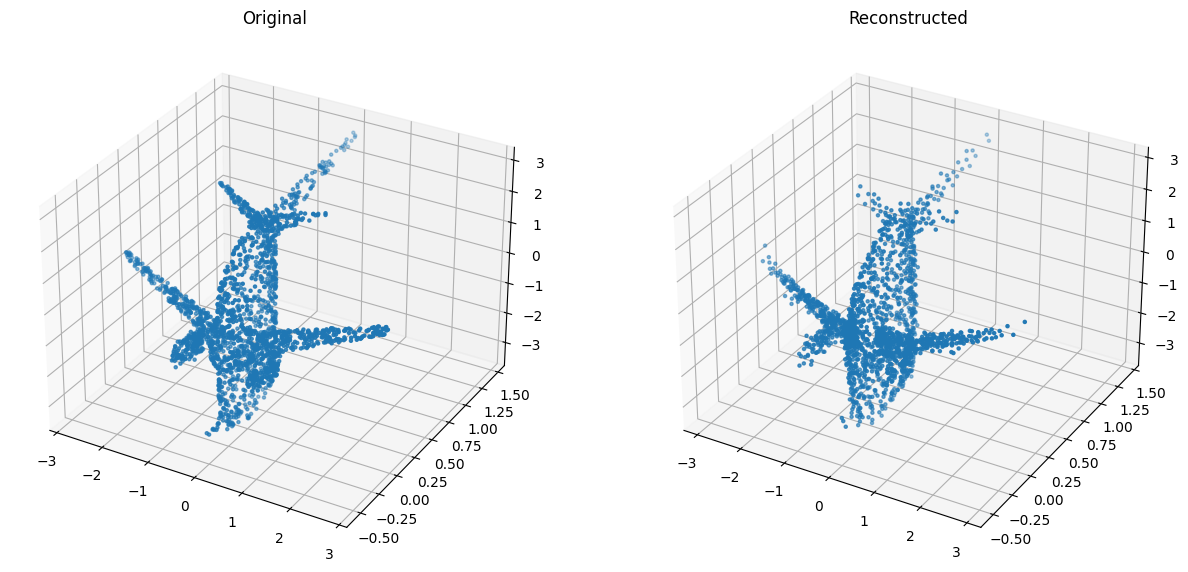

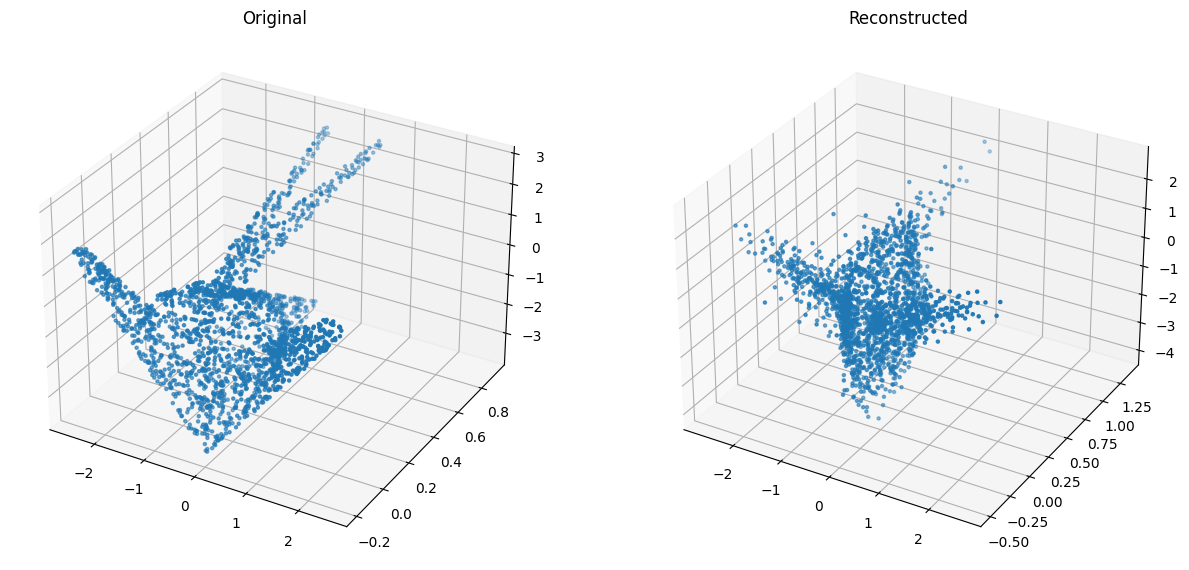

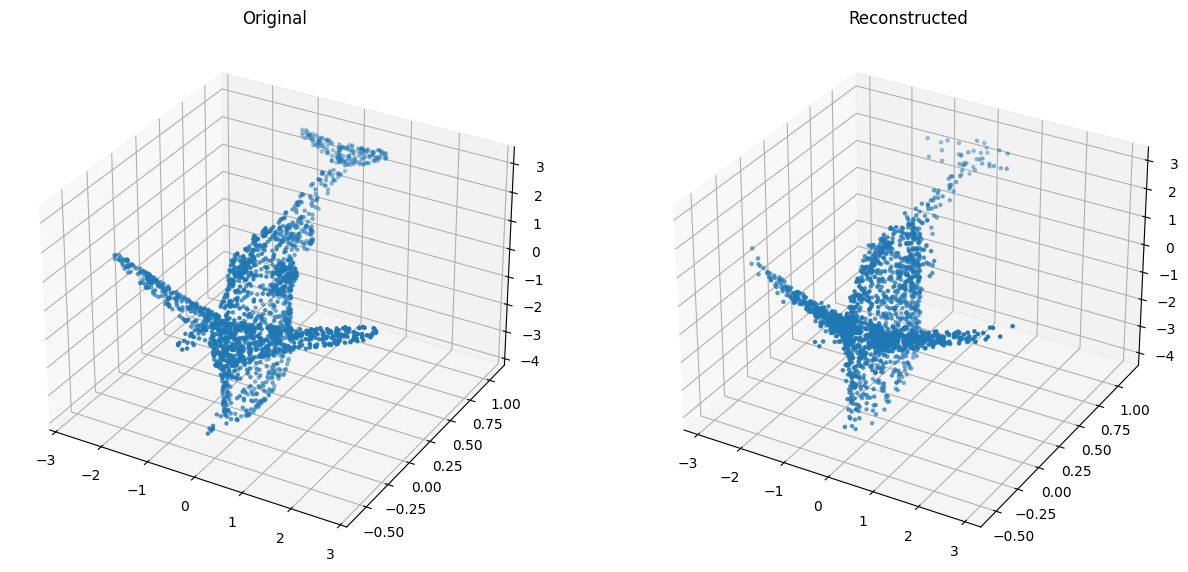

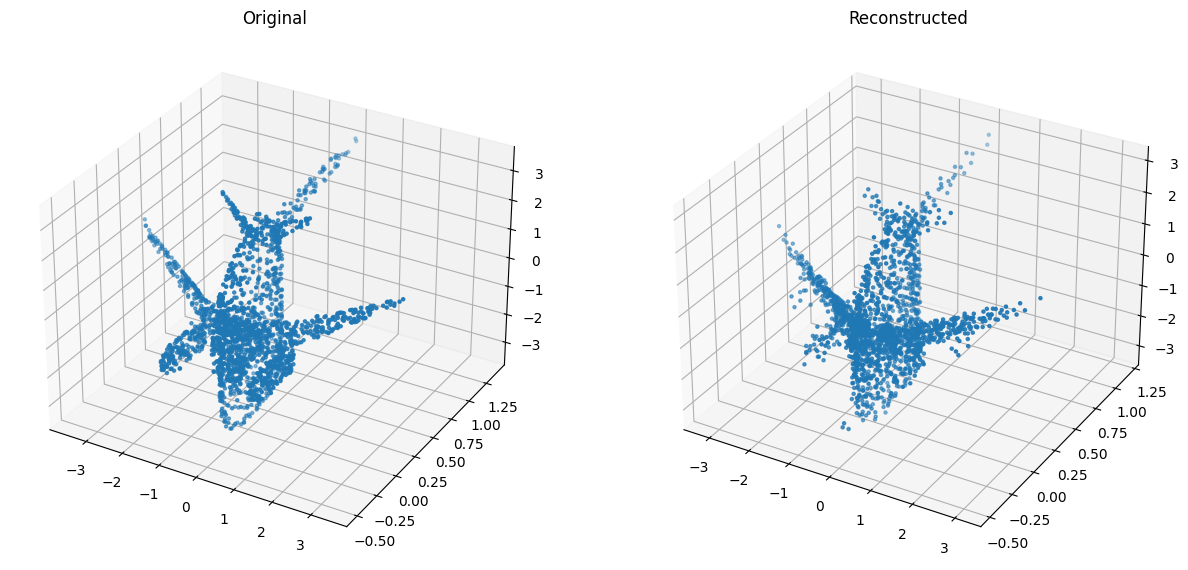

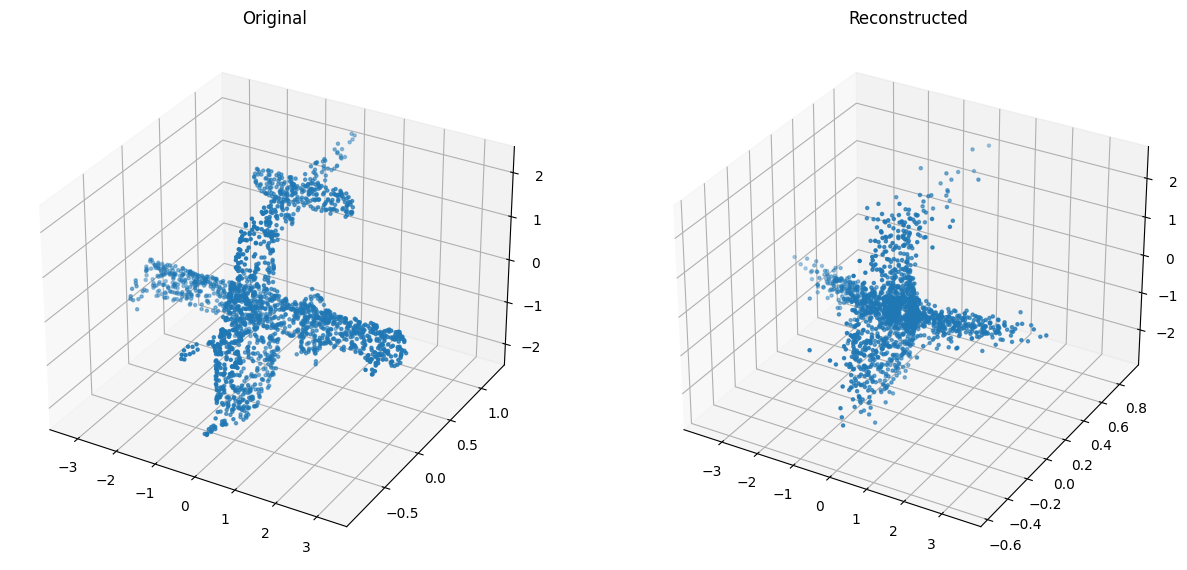

In [16]:
visualize_reconstruction(vae, val_dset) 

Generate a new model

In [17]:
def sample_from_vae(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Samples point clouds from the VAE model.
    """
    model.eval()
    with torch.no_grad():
        # 从标准正态分布中采样潜在向量
        z_sampled = torch.randn(num_samples, latent_dim).to(device)
        generated_point_clouds = model.decoder(z_sampled)
    return generated_point_clouds


In [18]:
def visualize_generated_point_clouds(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Visualizes point clouds generated from the VAE.
    """
    generated_point_clouds = sample_from_vae(model, num_samples, latent_dim, device)
    for i in range(num_samples):
        points = generated_point_clouds[i].cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax.set_title(f"Generated Point Cloud {i+1}")

        plt.show()


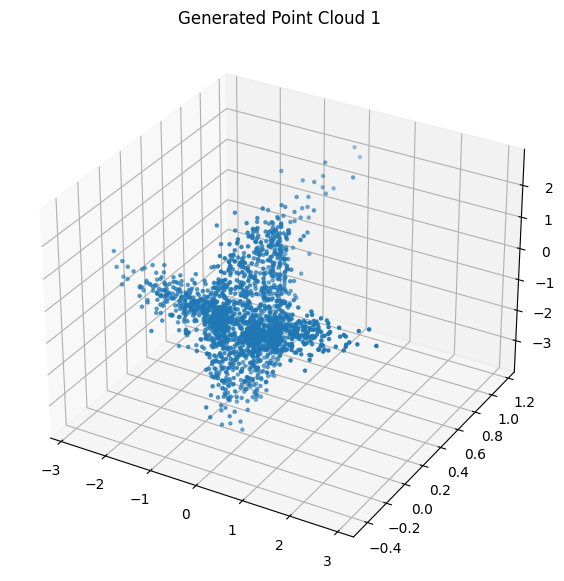

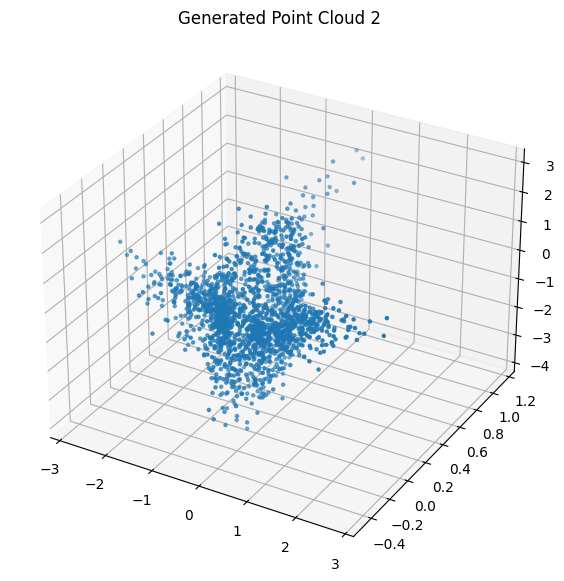

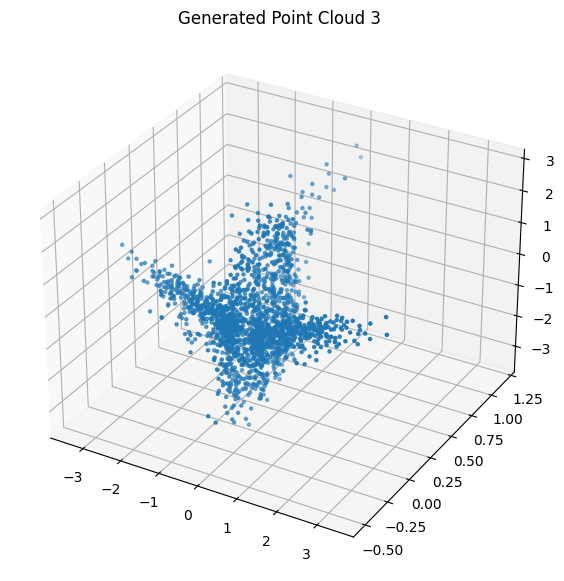

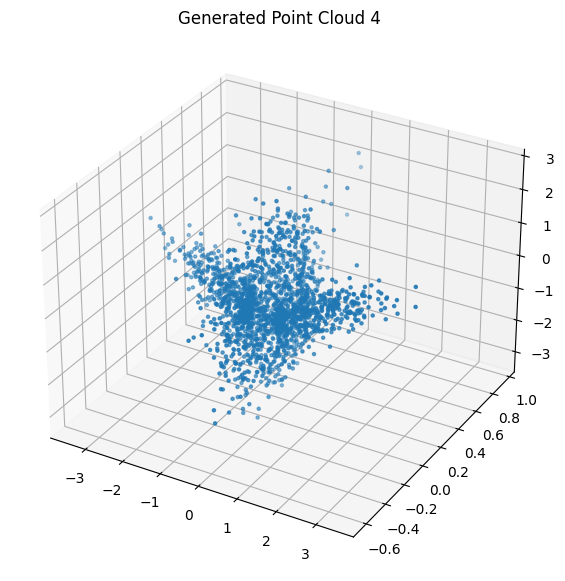

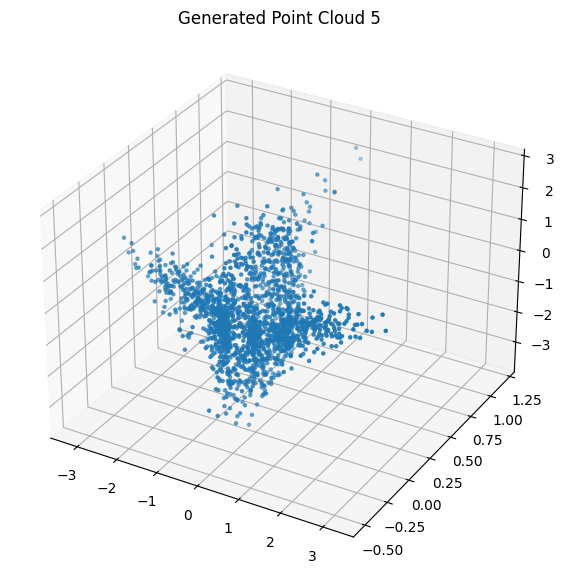

In [19]:
visualize_generated_point_clouds(vae)
